<a href="https://colab.research.google.com/github/20rashmi128/Building-a-Book-Recommender-System/blob/main/1_Notebook_BookRecommender_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Capstone Project: Books Recommender System (Unsupervised Learning)**

**Problem Statement:**

During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys.

In a very general way, **recommender systems are algorithms aimed at suggesting relevant items to users** (items being movies to watch, text to read, products to buy, or anything else depending on industries). Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from
competitors. 

**The main objective is to create a book recommendation system for users.**

**About Dataset:**

The Book-Crossing dataset comprises 3 files, namely:

* **Users**:
Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.

* **Books**:
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.

* **Ratings**:
Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

# **Part A. Dataset Preparation and EDA**

# Step 1. Loading Datasets into respective dataframes

In [336]:
# Importing Relevant python libraries - Part I
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
# Mounted google drive for file accessing
import warnings
warnings.filterwarnings('ignore')

In [337]:
# Importing Relevant python libraries - Part II
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

In [338]:
# Setting maximum display of columns and rows
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 800)

In [339]:
# Getting path addresses for all 3 csv files
path1 = '/content/drive/MyDrive/Book Recommendation - Kumari Rashmi/Problem Info & Data/Books.csv'
path2 = '/content/drive/MyDrive/Book Recommendation - Kumari Rashmi/Problem Info & Data/Ratings.csv'
path3 = '/content/drive/MyDrive/Book Recommendation - Kumari Rashmi/Problem Info & Data/Users.csv'

# Loading csv files to respective dataframes
books = pd.read_csv(path1)
ratings = pd.read_csv(path2)
users = pd.read_csv(path3)

In [340]:
# Module Function for annonting a barplot (will be used later)
def annot(xplot):
  for p in xplot.patches:
      xplot.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., 
                                                     p.get_height()), 
                     ha = 'center', va = 'center', xytext = (0, 9), 
                     textcoords = 'offset points')

# Step 2: Exploring the Books Dataset

## **A. Basic Information about Books dataset**

In [341]:
# A peek into head or top 5 observations of books dataframe
books.head(2)

ISBN           Book-Title           Book-Author Year-Of-Publication  \
0  0195153448  Classical Mythology    Mark P. O. Morford                2002   
1  0002005018         Clara Callan  Richard Bruce Wright                2001   

                 Publisher                                        Image-URL-S  \
0  Oxford University Press  http://images.amazon.com/images/P/0195153448.0...   
1    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   

                                         Image-URL-M  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   

                                         Image-URL-L  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...

In [342]:
# Basic information about books dataset
books.info()
# There are total 2,71,360 observations & each observation has 8 features.
# Year-Of-Publication should have been of int data type, but its object. (has been investigated later)
# ISBN is also object. Since ISBN values can be alphanumeric, ISBN was later investigated for any duplicates.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


**What is ISBN??**

* ISBN stands for "**International Standard Book Number**", it is either a 10-digits (if assigned before 2007) or 13-digits number which uniquely identifies a book.
* Every ISBN number contains a **check digit**. It is the Last single character of the ISBN. 
* In the case of the old 10-digit ISBN the check digit can be any number from zero to nine, and it can also be a letter "X", like a Roman ten.
* The only letter which can be in an ISBN is an **X** (Upper-case only) to represent ten, and that only in the final (checksum) position.
* An ISBN is assigned to each separate edition and variation (except re-printings) of a publication. 
* For example, an e-book, a paperback and a hardcover edition of the same book will each have a different ISBN.

In [343]:
# Checking unique values in each column
books.nunique()
# Each observation is a book, uniquely identified using ISBN.
# 2,42,135 unique book-titles and 1,02,023 unique authors 
# 202 unique years of publication and 16,807 unique publishers
# Few image urls are repeated for few books-- has to be investigated later

ISBN                   271360
Book-Title             242135
Book-Author            102023
Year-Of-Publication       202
Publisher               16807
Image-URL-S            271044
Image-URL-M            271044
Image-URL-L            271041
dtype: int64

In [344]:
books.describe()
# Books title "Selected Poems" has highest frequency of occurrence (27)
# Highest number of books (13,903) were published in year 2002.
# Publisher "Harlequin" has published maximum number of books (7535)

ISBN      Book-Title      Book-Author  Year-Of-Publication  \
count       271360          271360           271359               271360   
unique      271360          242135           102023                  202   
top     0195153448  Selected Poems  Agatha Christie                 2002   
freq             1              27              632                13903   

        Publisher                                        Image-URL-S  \
count      271358                                             271360   
unique      16807                                             271044   
top     Harlequin  http://images.amazon.com/images/P/185326119X.0...   
freq         7535                                                  2   

                                              Image-URL-M  \
count                                              271360   
unique                                             271044   
top     http://images.amazon.com/images/P/185326119X.0...   
freq                                                    2   

                                              Image-URL-L  
count                                              271357  
unique                                             271041  
top     http://images.amazon.com/images/P/225307649X.0...  
freq                                                    2

In [345]:
books[books['Book-Title'] == 'Selected Poems']['ISBN'].nunique()
# It turns out all books with title "Selected Poems" are unique and different books with different ISBN number.

27

In [346]:
# checking different unique authors with Books titled "Selected Poems"
books[books['Book-Title'] == 'Selected Poems']['Book-Author'].unique()

array(['William Carlos Williams', 'K. Patchen', 'Rita Dove',
       'Gwendolyn Brooks', 'John Donne', 'Paul Verlaine',
       'E. E. Cummings', 'T.           T Gunn', 'Ralph Gustafson',
       'Thomas Hardy', 'Kathleen Raine', 'Pablo Neruda', 'Jenny Joseph',
       'Daniel Halpern', 'Denise Levertov', 'Robert Creeley',
       'Carl Sandburg', 'Galway Kinnell', 'Edna St. Vincent Millay',
       'W. H. Auden', 'R. Jeffers', 'Michael Mc Clure', 'John Ashbery',
       'Elizabeth Barrett Browning', 'Simon Armitage'], dtype=object)

In [347]:
# Checking Null values
books.isnull().sum().sort_values(ascending = False)
# URLs of large-sized image is missing for 3 books.
# Publisher details is missing for 2 books.
# Author detail is missing for 1 book.

Image-URL-L            3
Publisher              2
Book-Author            1
ISBN                   0
Book-Title             0
Year-Of-Publication    0
Image-URL-S            0
Image-URL-M            0
dtype: int64

In [348]:
# Lets fill the missing values using "Missing"
books.fillna("Unknown", inplace =True)

In [349]:
# Checking Null values after replacing null values to ease calculation
books.isnull().sum().sort_values(ascending = False)

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

**Observations**:
1. Total 2,71,360 observations, each has 8 features (namely ISBN, Title, Author, Publisher, Year of publication and URLs of Images)
2. ISBN and Year-of-publication are of object data type--investigated later for any irregularities.
3. ISBN (International standard book number) is an alpha-numeric code to uniquely identify a particular book. Its assigned to each separate edition/variation (except re-prints) of a book.
4. There are total 2,42,135 unique book-titles, 1,02,023 unique authors, 202 unique years of publication and 16,807 unique publishers.
5. Books with title "Selected Poems" has highest frequency of occurrence (27), and Publisher "Harlequin" has published maximum number of books (7535)
6. Highest number of books (13,903) were published in year 2002.
7. Few missing values in columns Author (1), Publisher (2) and image-URL-L (3).

## **B. Data Preparation and Cleaning**

### **1. Formatting Inconsistent Data Types**

### **A. ISBN**

In [350]:
# Checking ISBN values with X-check digit (Lower case)
books[books['ISBN']== '068482440x']

ISBN                          Book-Title Book-Author  \
232262  068482440x  BEACHCOMBING FOR A SHIPWRECKED GOD  Joe Coomer   

       Year-Of-Publication   Publisher  \
232262                1997  Touchstone   

                                              Image-URL-S  \
232262  http://images.amazon.com/images/P/068482440X.0...   

                                              Image-URL-M  \
232262  http://images.amazon.com/images/P/068482440X.0...   

                                              Image-URL-L  
232262  http://images.amazon.com/images/P/068482440X.0...

In [351]:
# Checking ISBN values with X-check digit (upper case)
books[books['ISBN']== '068482440X']

ISBN                          Book-Title Book-Author  \
7446  068482440X  BEACHCOMBING FOR A SHIPWRECKED GOD  Joe Coomer   

     Year-Of-Publication   Publisher  \
7446                1997  Touchstone   

                                            Image-URL-S  \
7446  http://images.amazon.com/images/P/068482440X.0...   

                                            Image-URL-M  \
7446  http://images.amazon.com/images/P/068482440X.0...   

                                            Image-URL-L  
7446  http://images.amazon.com/images/P/068482440X.0...

**Note:**

It turns out that check-digit "X" written in both upper and lower cases and therefore has been considered different ISBNs. Let's corrrect these to upper-case only.

In [352]:
# Converting lowercase ISBN to upper case
books['ISBN'] = books['ISBN'].apply(lambda x:x.upper())

In [353]:
# Checking ISBN values with X-check digit (upper case only)
books[books['ISBN']== '068482440X']
# We can see that all ISBN with X-Check digits are corrected to upper case format.

ISBN                          Book-Title Book-Author  \
7446    068482440X  BEACHCOMBING FOR A SHIPWRECKED GOD  Joe Coomer   
232262  068482440X  BEACHCOMBING FOR A SHIPWRECKED GOD  Joe Coomer   

       Year-Of-Publication   Publisher  \
7446                  1997  Touchstone   
232262                1997  Touchstone   

                                              Image-URL-S  \
7446    http://images.amazon.com/images/P/068482440X.0...   
232262  http://images.amazon.com/images/P/068482440X.0...   

                                              Image-URL-M  \
7446    http://images.amazon.com/images/P/068482440X.0...   
232262  http://images.amazon.com/images/P/068482440X.0...   

                                              Image-URL-L  
7446    http://images.amazon.com/images/P/068482440X.0...  
232262  http://images.amazon.com/images/P/068482440X.0...

In [354]:
books['ISBN'].nunique()
# Number of unique ISBN have decreased, it implies that there only 2,71,046 unique books.

271046

In [355]:
import string
# Accessing list of punctuations from string library
punc_to_remove = string.punctuation

# Function for Removing Punctuations
def remove_punctuations(text):
  for punctuation in punc_to_remove:
    text = text.replace(punctuation, '')
  return text

In [356]:
# Removing punctuations (if any)
books['ISBN'].apply(remove_punctuations)

0         0195153448
1         0002005018
2         0060973129
3         0374157065
4         0393045218
             ...    
271355    0440400988
271356    0525447644
271357    006008667X
271358    0192126040
271359    0767409752
Name: ISBN, Length: 271360, dtype: object

In [357]:
# Final count of unique ISBNs after data cleaning
books['ISBN'].nunique()

271046

**Observations**:
1. There are total 2,71,046 different books with unique ISBN (Out of total 2,71,360 books).

### **B. Year of Publication**

In [358]:
# Checking data type of "Year-Of-Publication" values
type(books.loc[7446,'Year-Of-Publication']), type(books.loc[232262,'Year-Of-Publication']), type(books.loc[19266,'Year-Of-Publication']) 

(int, str, int)

In [359]:
# Checking unique values under Year-of-Publication column
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

**Note:** 

1. It turns out few years are given in string format and few are in integer format. We need to convert all years to int format only.
2. Few years of publication are strings as 'DK Publishing Inc' and 'Gallimard'.

In [360]:
# Looking into observations with incorrect publishing year of 'DK Publishing Inc'
pub_dk = books[books['Year-Of-Publication']=='DK Publishing Inc']
pub_dk
# It turns out column values have been wrongly fed.
# Lets correct this.

ISBN                                         Book-Title  \
209538  078946697X  DK Readers: Creating the X-Men, How It All Beg...   
221678  0789466953  DK Readers: Creating the X-Men, How Comic Book...   

       Book-Author Year-Of-Publication  \
209538        2000   DK Publishing Inc   
221678        2000   DK Publishing Inc   

                                                Publisher  \
209538  http://images.amazon.com/images/P/078946697X.0...   
221678  http://images.amazon.com/images/P/0789466953.0...   

                                              Image-URL-S  \
209538  http://images.amazon.com/images/P/078946697X.0...   
221678  http://images.amazon.com/images/P/0789466953.0...   

                                              Image-URL-M Image-URL-L  
209538  http://images.amazon.com/images/P/078946697X.0...     Unknown  
221678  http://images.amazon.com/images/P/0789466953.0...     Unknown

In [361]:
# Correcting book titles
books.loc[209538,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.loc[221678,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
# Correcting book author
books.loc[209538,'Book-Author'] = 'Michael Teitelbaum'
books.loc[221678,'Book-Author'] = 'James Buckley'
# Shifting values: Correcting Image-URL-L
books.loc[209538,'Image-URL-L'] = books.loc[209538,'Image-URL-M']
books.loc[221678,'Image-URL-L'] = books.loc[221678,'Image-URL-M']
# Shifting values: Correcting Image-URL-M
books.loc[209538,'Image-URL-M'] = books.loc[209538,'Image-URL-S']
books.loc[221678,'Image-URL-M'] = books.loc[221678,'Image-URL-S']
# Shifting values: Correcting Image-URL-S
books.loc[209538,'Image-URL-S'] = books.loc[209538,'Publisher']
books.loc[221678,'Image-URL-S'] = books.loc[221678,'Publisher']
# Shifting values: Correcting Publisher
books.loc[209538,'Publisher'] = books.loc[209538,'Year-Of-Publication']
books.loc[221678,'Publisher'] = books.loc[221678,'Year-Of-Publication']
# Shifting values: Correcting Year-Of-Publication
books.loc[209538,'Year-Of-Publication'] = 2000
books.loc[221678,'Year-Of-Publication'] = 2000

In [362]:
# Checking above observations after correction
books.loc[[209538, 221678]]

ISBN                                         Book-Title  \
209538  078946697X  DK Readers: Creating the X-Men, How It All Beg...   
221678  0789466953  DK Readers: Creating the X-Men, How Comic Book...   

               Book-Author Year-Of-Publication          Publisher  \
209538  Michael Teitelbaum                2000  DK Publishing Inc   
221678       James Buckley                2000  DK Publishing Inc   

                                              Image-URL-S  \
209538  http://images.amazon.com/images/P/078946697X.0...   
221678  http://images.amazon.com/images/P/0789466953.0...   

                                              Image-URL-M  \
209538  http://images.amazon.com/images/P/078946697X.0...   
221678  http://images.amazon.com/images/P/0789466953.0...   

                                              Image-URL-L  
209538  http://images.amazon.com/images/P/078946697X.0...  
221678  http://images.amazon.com/images/P/0789466953.0...

In [363]:
# Looking into incorrectly fed publishing year of 'Gallimard'
pub_gallimard = books[books['Year-Of-Publication']=='Gallimard']
pub_gallimard
# It turns out column values have been wrongly fed.
# Lets correct this.

ISBN                                         Book-Title  \
220731  2070426769  Peuple du ciel, suivi de 'Les Bergers\";Jean-M...   

       Book-Author Year-Of-Publication  \
220731        2003           Gallimard   

                                                Publisher  \
220731  http://images.amazon.com/images/P/2070426769.0...   

                                              Image-URL-S  \
220731  http://images.amazon.com/images/P/2070426769.0...   

                                              Image-URL-M Image-URL-L  
220731  http://images.amazon.com/images/P/2070426769.0...     Unknown

In [364]:
# getting book title
pub_gallimard.loc[220731,'Book-Title']

'Peuple du ciel, suivi de \'Les Bergers\\";Jean-Marie Gustave Le ClÃ?Â©zio"'

In [365]:
# Correcting book titles
books.loc[220731,'Book-Title'] = 'Peuple du ciel, suivi de'
# Correcting book author
books.loc[220731,'Book-Author'] = 'Les Bergers'
# Shifting values: Correcting Image-URL-L
books.loc[220731,'Image-URL-L'] = books.loc[220731,'Image-URL-M']
# Shifting values: Correcting Image-URL-M
books.loc[220731,'Image-URL-M'] = books.loc[220731,'Image-URL-S']
# Shifting values: Correcting Image-URL-S
books.loc[220731,'Image-URL-S'] = books.loc[220731,'Publisher']
# Shifting values: Correcting Publisher
books.loc[220731,'Publisher'] = books.loc[220731,'Year-Of-Publication']
# Shifting values: Correcting Year-Of-Publication
books.loc[220731,'Year-Of-Publication'] = 2003

In [366]:
# Checking above observations after correction
books.loc[[220731]]

ISBN                Book-Title  Book-Author Year-Of-Publication  \
220731  2070426769  Peuple du ciel, suivi de  Les Bergers                2003   

        Publisher                                        Image-URL-S  \
220731  Gallimard  http://images.amazon.com/images/P/2070426769.0...   

                                              Image-URL-M  \
220731  http://images.amazon.com/images/P/2070426769.0...   

                                              Image-URL-L  
220731  http://images.amazon.com/images/P/2070426769.0...

In [367]:
# After correcting entries, lets change data type of publication year to integer
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [368]:
# Checking data type of "Year-Of-Publication" values after correction
type(books.loc[7446,'Year-Of-Publication']), type(books.loc[232262,'Year-Of-Publication']), type(books.loc[19266,'Year-Of-Publication']) 

(numpy.int64, numpy.int64, numpy.int64)

**Data types of Publication years formatted correctly to Integer type!!**

### **2. Checking Duplicates**

In [369]:
# Checking repeated url links and respective books
books[books['Image-URL-L'].duplicated()]['Image-URL-L']

6635      http://images.amazon.com/images/P/002542730X.0...
11925     http://images.amazon.com/images/P/014062080X.0...
16298     http://images.amazon.com/images/P/097089726X.0...
19266     http://images.amazon.com/images/P/039592720X.0...
22339     http://images.amazon.com/images/P/042512164X.0...
24871     http://images.amazon.com/images/P/067174139X.0...
25711     http://images.amazon.com/images/P/006051406X.0...
26895     http://images.amazon.com/images/P/051513581X.0...
27167     http://images.amazon.com/images/P/038533348X.0...
27688     http://images.amazon.com/images/P/080410753X.0...
28543     http://images.amazon.com/images/P/031205436X.0...
45403     http://images.amazon.com/images/P/042515601X.0...
46642     http://images.amazon.com/images/P/038000741X.0...
49071     http://images.amazon.com/images/P/044661162X.0...
50655     http://images.amazon.com/images/P/051513449X.0...
50993     http://images.amazon.com/images/P/038531700X.0...
52087     http://images.amazon.com/image

In [370]:
books.loc[6635,'Image-URL-L'], books.loc[11925,'Image-URL-L']

('http://images.amazon.com/images/P/002542730X.01.LZZZZZZZ.jpg',
 'http://images.amazon.com/images/P/014062080X.01.LZZZZZZZ.jpg')

In [371]:
books[books['Image-URL-L'] == 'http://images.amazon.com/images/P/002542730X.01.LZZZZZZZ.jpg']

ISBN                                         Book-Title  \
3739  002542730X  Politically Correct Bedtime Stories: Modern Ta...   
6635  002542730X  Politically Correct Bedtime Stories: Modern Ta...   

            Book-Author  Year-Of-Publication                  Publisher  \
3739  James Finn Garner                 1994  John Wiley &amp; Sons Inc   
6635  James Finn Garner                 1994  John Wiley &amp; Sons Inc   

                                            Image-URL-S  \
3739  http://images.amazon.com/images/P/002542730X.0...   
6635  http://images.amazon.com/images/P/002542730X.0...   

                                            Image-URL-M  \
3739  http://images.amazon.com/images/P/002542730X.0...   
6635  http://images.amazon.com/images/P/002542730X.0...   

                                            Image-URL-L  
3739  http://images.amazon.com/images/P/002542730X.0...  
6635  http://images.amazon.com/images/P/002542730X.0...

In [372]:
# Checking count of duplicated ISBN
books['ISBN'].duplicated().sum()

314

In [373]:
# Checking duplicated observations basis ISBN and Year of publication
duplicates1 = books[books['ISBN'].duplicated() & books['Year-Of-Publication'].duplicated()]

# Checking duplicated observations basis ISBN, Year of publication and Book-Title
duplicates2 = books[books['ISBN'].duplicated() & books['Year-Of-Publication'].duplicated() & books['Book-Title'].duplicated()]

# Checking duplicated observations basis ISBN, Year of publication, Book-Title, Autjor and Publisher.
duplicates3 = books[books['ISBN'].duplicated() & books['Year-Of-Publication'].duplicated() & books['Book-Title'].duplicated() 
                    & books['Book-Author'].duplicated() & books['Publisher'].duplicated()]
# Checking overall duplicates basis complete dataframe
duplicates6 = books[books.duplicated()]

In [374]:
# Number of duplicated observations basis different criterion
len(duplicates1), len(duplicates2), len(duplicates3), len(duplicates6)
# It turns out there is one observation with ambiguity in Title name.

(314, 313, 313, 313)

In [375]:
# There is some ambiguity in Book-Title against 1 of the duplicated ISBN.
# Lets find out the details.
for i,row in duplicates1.iterrows():
  if row['ISBN'] not in list(duplicates6['ISBN']):
    print(row['ISBN'])
    # Getting respective ISBN number

051513628X


In [376]:
# Lets look at above different Book
books[books['ISBN']=='051513628X']
# As suspected, Title is different.

ISBN                              Book-Title   Book-Author  \
16202   051513628X  Key of Light (Key Trilogy (Paperback))  Nora Roberts   
213834  051513628X                            Key of Light  Nora Roberts   

        Year-Of-Publication   Publisher  \
16202                  2003  Jove Books   
213834                 2003  Jove Books   

                                              Image-URL-S  \
16202   http://images.amazon.com/images/P/051513628X.0...   
213834  http://images.amazon.com/images/P/051513628X.0...   

                                              Image-URL-M  \
16202   http://images.amazon.com/images/P/051513628X.0...   
213834  http://images.amazon.com/images/P/051513628X.0...   

                                              Image-URL-L  
16202   http://images.amazon.com/images/P/051513628X.0...  
213834  http://images.amazon.com/images/P/051513628X.0...

**Note:**

* Since there are only 2,71,046 unique ISBN out of total 2,71,360 observations, it implies that few entries are duplicate observations. 
* Let's drop duplicate entries of books

In [377]:
# Dropping duplicate observations with duplicated ISBN
books.drop_duplicates(subset='ISBN', keep='first', inplace=True)

In [378]:
# Lets check whether duplicates have been removed or not.
books[books['ISBN']=='051513628X']
# Yes, have been removed.

ISBN                              Book-Title   Book-Author  \
16202  051513628X  Key of Light (Key Trilogy (Paperback))  Nora Roberts   

       Year-Of-Publication   Publisher  \
16202                 2003  Jove Books   

                                             Image-URL-S  \
16202  http://images.amazon.com/images/P/051513628X.0...   

                                             Image-URL-M  \
16202  http://images.amazon.com/images/P/051513628X.0...   

                                             Image-URL-L  
16202  http://images.amazon.com/images/P/051513628X.0...

In [379]:
books.info()
# There are total 2,71,046 unique books.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271046 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271046 non-null  object
 1   Book-Title           271046 non-null  object
 2   Book-Author          271046 non-null  object
 3   Year-Of-Publication  271046 non-null  int64 
 4   Publisher            271046 non-null  object
 5   Image-URL-S          271046 non-null  object
 6   Image-URL-M          271046 non-null  object
 7   Image-URL-L          271046 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.6+ MB


### **3. Cleaning the textual Data**

1. Converting all String values of Title, Author and Publishers to Only one case (i.e., Lower-case)
2. Removing Punctuations from author and publisher names

**1. Lowercasing**

In [380]:
# Checking statistical parameters of non-numerical features
books.describe(include='O')

ISBN      Book-Title      Book-Author  Publisher  \
count       271046          271046           271046     271046   
unique      271046          242134           102022      16804   
top     0195153448  Selected Poems  Agatha Christie  Harlequin   
freq             1              27              631       7532   

                                              Image-URL-S  \
count                                              271046   
unique                                             271044   
top     http://images.amazon.com/images/P/0385722206.0...   
freq                                                    2   

                                              Image-URL-M  \
count                                              271046   
unique                                             271044   
top     http://images.amazon.com/images/P/0385722206.0...   
freq                                                    2   

                                              Image-URL-L  
count                                              271046  
unique                                             271044  
top     http://images.amazon.com/images/P/0385722206.0...  
freq                                                    2

In [381]:
# checking different authors with same name!! 
# Reason: Different Case used.
books[books['Book-Author'] == 'Agatha christie']
# It turned out that string values need to converted to same case in order to avoid any ambiguity.

ISBN                                         Book-Title  \
102824  0671805959  Agatha Christie the Clocks Poirot (Hercule Poi...   

            Book-Author  Year-Of-Publication     Publisher  \
102824  Agatha christie                 1976  Pocket Books   

                                              Image-URL-S  \
102824  http://images.amazon.com/images/P/0671805959.0...   

                                              Image-URL-M  \
102824  http://images.amazon.com/images/P/0671805959.0...   

                                              Image-URL-L  
102824  http://images.amazon.com/images/P/0671805959.0...

In [382]:
# Converting each value to lower-case
books['Book-Title'] = books['Book-Title'].apply(lambda x:x.lower())
books['Book-Author'] = books['Book-Author'].apply(lambda x:x.lower())
books['Publisher'] = books['Publisher'].apply(lambda x:x.lower())

**2. Removing Punctuations from author and Publisher name**

In [383]:
books['Book-Author'] = books['Book-Author'].apply(remove_punctuations)
books['Publisher'] = books['Publisher'].apply(remove_punctuations)

In [384]:
# Checking statistical parameters of non-numerical features after data cleaning
books.describe(include='O')
# Title "Selected Poems" is most frequently used title (28 books of same title)
# Author Agatha Christie has written maximum books (635 books)
# Publisher Harlequin has published maximum books (7533 books)

ISBN      Book-Title      Book-Author  Publisher  \
count       271046          271046           271046     271046   
unique      271046          238963            98089      16287   
top     0195153448  selected poems  agatha christie  harlequin   
freq             1              28              635       7533   

                                              Image-URL-S  \
count                                              271046   
unique                                             271044   
top     http://images.amazon.com/images/P/0385722206.0...   
freq                                                    2   

                                              Image-URL-M  \
count                                              271046   
unique                                             271044   
top     http://images.amazon.com/images/P/0385722206.0...   
freq                                                    2   

                                              Image-URL-L  
count                                              271046  
unique                                             271044  
top     http://images.amazon.com/images/P/0385722206.0...  
freq                                                    2

**Observations**:
1. There are 2,71,046 unique books, 98,089 unique authors, 2,38,963 unique titles and 16,287 unique publishers.
2. Book-Title "Selected Poems" is most frequently used title (28 books of same title).
3. Author Agatha Christie has written maximum books (635 books)
4. Publisher Harlequin has published maximum books (7533 books)

### **4. Renaming Columns for ease of coding**

In [385]:
# Getting column names
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [386]:
# Renaming columns
books.rename(columns={'Book-Title':'Title', 'Book-Author':'Author','Year-Of-Publication':'Published_year',
                      'Image-URL-S':'Image_url_S', 'Image-URL-M': 'Image_url_M', 'Image-URL-L':'Image_url_L'}, inplace=True)

In [387]:
# Checking columns names after renaming
books.columns

Index(['ISBN', 'Title', 'Author', 'Published_year', 'Publisher', 'Image_url_S',
       'Image_url_M', 'Image_url_L'],
      dtype='object')

### **5. Creating a column "Title_by_Author_of_Publisher" to identify unique different books**

* Different editions of a given book have different unique ISBN numbers.
* In order to avoid repeated recommendations of same book but different editions, i have decided to uniquely identify a book basis its title, author and publisher

In [388]:
# checking unique number of values in each column before change
books.nunique()

ISBN              271046
Title             238963
Author             98089
Published_year       116
Publisher          16287
Image_url_S       271044
Image_url_M       271044
Image_url_L       271044
dtype: int64

In [389]:
# Creating new feature to identify a book basis Title-author-publisher
books['Title_by_of'] = books['Title']+ "_by_"+ books['Author'] + "_of_" + books['Publisher']
books['Title_by_of'].nunique()
# It means we have 2,65,604 unique different books in our given book dataset.

265604

In [390]:
# checking unique number of values in each column after change
books.nunique()

ISBN              271046
Title             238963
Author             98089
Published_year       116
Publisher          16287
Image_url_S       271044
Image_url_M       271044
Image_url_L       271044
Title_by_of       265604
dtype: int64

## **C. Exploratory Data Analysis & Visualization**

### **1. Uni-variate Analysis**

In [391]:
# checking column names
books.columns

Index(['ISBN', 'Title', 'Author', 'Published_year', 'Publisher', 'Image_url_S',
       'Image_url_M', 'Image_url_L', 'Title_by_of'],
      dtype='object')

### **a. Title of Books**

In [392]:
# checking statistical parameters of Title column
books['Title'].describe()

count             271046
unique            238963
top       selected poems
freq                  28
Name: Title, dtype: object

In [393]:
# Top 10 most frequently used Book Titles
books['Title'].value_counts()[:10]

selected poems                    28
little women                      26
wuthering heights                 22
dracula                           21
the secret garden                 21
the night before christmas        20
adventures of huckleberry finn    20
jane eyre                         19
pride and prejudice               19
nemesis                           17
Name: Title, dtype: int64

In [394]:
# Bar chart to visualize top 10 most frequent book titles
plt1 = books['Title'].value_counts()[:10].plot(kind='bar', figsize=(18,6))
plt.title("Top 10 most frequent titles of books & their counts", fontsize=16)
plt.xlabel("Title of Books", fontsize=14)
plt.ylabel("Count of Books", fontsize=14)
plt.xticks(rotation=30)
annot(plt1)

### **b. Author of Books**

In [395]:
# checking statistical parameters of Author column
books['Author'].describe()
# 98,089 Unique book authors
# Agatha christie has written maximum books (635)

count              271046
unique              98089
top       agatha christie
freq                  635
Name: Author, dtype: object

In [396]:
# Author and their counts of books
books['Author'].value_counts()

agatha christie        635
william shakespeare    570
stephen king           532
ann m martin           428
francine pascal        418
                      ... 
peter loughran           1
roma felible             1
lela nargi               1
erik brown               1
christopher  biffle      1
Name: Author, Length: 98089, dtype: int64

In [397]:
books.groupby(['Author'])['Title'].nunique().sort_values()

Author
 d chiel                 1
lynn coleman             1
lynn cherny              1
lynn chandlerwillis      1
lynn caine               1
                      ... 
carolyn keene          371
francine pascal        396
ann m martin           399
agatha christie        446
william shakespeare    484
Name: Title, Length: 98089, dtype: int64

In [398]:
# Getting top 10 Book authors basis counts of Books
books['Author'].value_counts()[:10]

agatha christie        635
william shakespeare    570
stephen king           532
ann m martin           428
francine pascal        418
carolyn keene          372
isaac asimov           344
nora roberts           317
barbara cartland       308
charles dickens        307
Name: Author, dtype: int64

In [399]:
# Setting fontsize of x-ticks & y-ticks
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

In [400]:
# Visualizing top 10 authors basis count of books using Bar chart
plt2 = books['Author'].value_counts()[:10].plot(kind='bar', figsize=(18,6))
plt.title("Top 10 Authors basis count of books (in the whole books collection available)", fontsize=16)
plt.xlabel("Author of Book", fontsize=14)
plt.ylabel("Count of Books", fontsize=14)
plt.xticks(rotation=20)
annot(plt2)

### **c. Publication year**

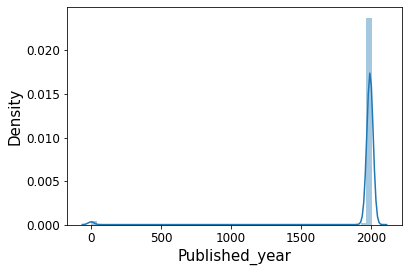

In [401]:
# Density plot for Publication years
sns.distplot(books['Published_year'])
# Majority of books were published around year 2000

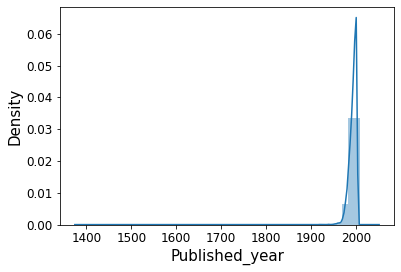

In [402]:
sns.distplot(books[books['Published_year'] != 0]['Published_year'])
# Not taking year 0 into consideration, the density plot is still skewed towards left (Negatively skewed)

In [403]:
# There are total 116 unique publication years, 
books['Published_year'].nunique(), books['Published_year'].max(), books['Published_year'].min()
# starting from 0th year---- Ambiguous
# Latest publication year is 2050 --- Ambiguous-- Future Data

(116, 2050, 0)

In [404]:
# Lets look into year 2050
books[books['Published_year']==2050]
# On exploring the internet, found that the publication year were 1950 (Typing error)
# Let's correct both ones.

ISBN                                              Title  \
80264  0140301690  alice's adventures in wonderland and through t...   
97826  0140201092      outline of european architecture (pelican s.)   

                 Author  Published_year     Publisher  \
80264     lewis carroll            2050  puffin books   
97826  nikolaus pevsner            2050   penguin usa   

                                             Image_url_S  \
80264  http://images.amazon.com/images/P/0140301690.0...   
97826  http://images.amazon.com/images/P/0140201092.0...   

                                             Image_url_M  \
80264  http://images.amazon.com/images/P/0140301690.0...   
97826  http://images.amazon.com/images/P/0140201092.0...   

                                             Image_url_L  \
80264  http://images.amazon.com/images/P/0140301690.0...   
97826  http://images.amazon.com/images/P/0140201092.0...   

                                             Title_by_of  
80264  alice's adventures in wonderland and through t...  
97826  outline of european architecture (pelican s.)_...

In [405]:
# Replace above years by 1950
books['Published_year'] = np.where(books['Published_year']==2050, 1950, books['Published_year'])

In [406]:
# Let's look into publication year set as 0.
books[books['Published_year']==0]
# There are total 4611 books, it seems data was unavailable and hence were replaced with 0.
# No simpler way to deal with this, therefore, lets keep these as given.

ISBN                                              Title  \
176     3150000335                                   kabale und liebe   
188     342311360X                            die liebe in den zelten   
288     0571197639                        poisonwood bible edition uk   
351     3596214629       herr der fliegen (fiction, poetry and drama)   
542     8845229041  biblioteca universale rizzoli: sulla sponda de...   
...            ...                                                ...   
270794  014029953X                         foe (essential.penguin s.)   
270913  0340571187                                     postmens house   
271094  8427201079                           el misterio de sittaford   
271182  0887781721                                          tom penny   
271196  3150013763                                     der hofmeister   

                        Author  Published_year  \
176                   schiller               0   
188     gabriel garcia marquez               0   
288         barbara kingsolver               0   
351                    golding               0   
542                   p coelho               0   
...                        ...             ...   
270794              jm coetzee               0   
270913        maggie hemingway               0   
271094         agatha christie               0   
271182             tony german               0   
271196              jakob lenz               0   

                               Publisher  \
176       philipp reclam jun verlag gmbh   
188     deutscher taschenbuch verlag dtv   
288                      faber faber inc   
351      fischer taschenbuch verlag gmbh   
542                    fabbri  rcs libri   
...                                  ...   
270794                 penguin books ltd   
270913                  trafalgar square   
271094                  editorial molino   
271182               p martin associates   
271196    philipp reclam jun verlag gmbh   

                                              Image_url_S  \
176     http://images.amazon.com/images/P/3150000335.0...   
188     http://images.amazon.com/images/P/342311360X.0...   
288     http://images.amazon.com/images/P/0571197639.0...   
351     http://images.amazon.com/images/P/3596214629.0...   
542     http://images.amazon.com/images/P/8845229041.0...   
...                                                   ...   
270794  http://images.amazon.com/images/P/014029953X.0...   
270913  http://images.amazon.com/images/P/0340571187.0...   
271094  http://images.amazon.com/images/P/8427201079.0...   
271182  http://images.amazon.com/images/P/0887781721.0...   
271196  http://images.amazon.com/images/P/3150013763.0...   

                                              Image_url_M  \
176     http://images.amazon.com/images/P/3150000335.0...   
188     http://images.amazon.com/images/P/342311360X.0...   
288     http://images.amazon.com/images/P/0571197639.0...   
351     http://images.amazon.com/images/P/3596214629.0...   
542     http://images.amazon.com/images/P/8845229041.0...   
...                                                   ...   
270794  http://images.amazon.com/images/P/014029953X.0...   
270913  http://images.amazon.com/images/P/0340571187.0...   
271094  http://images.amazon.com/images/P/8427201079.0...   
271182  http://images.amazon.com/images/P/0887781721.0...   
271196  http://images.amazon.com/images/P/3150013763.0...   

                                              Image_url_L  \
176     http://images.amazon.com/images/P/3150000335.0...   
188     http://images.amazon.com/images/P/342311360X.0...   
288     http://images.amazon.com/images/P/0571197639.0...   
351     http://images.amazon.com/images/P/3596214629.0...   
542     http://images.amazon.com/images/P/8845229041.0...   
...                                                   ...   
270794  http://images.amazon.com/images/P/014029953X.0...   
270913  http://images.amazon.com/images/P/0340571187.

In [407]:
# There are total 115 unique publication years now. 
books['Published_year'].nunique(), books['Published_year'].max(), books[books['Published_year']!=0]['Published_year'].min()
# starting from 1376 year---- Ambiguous
# Latest publication year is 2038 --- Ambiguous-- Future Data

(115, 2038, 1376)

In [408]:
# Lets look into year 2038
books[books['Published_year']==2038]
# On exploring the internet, found that the publication year were 1959 (Typing error)
# Let's correct this one.

ISBN                         Title         Author  \
116053  0394701658  three plays of eugene oneill  eugene oneill   

        Published_year          Publisher  \
116053            2038  vintage books usa   

                                              Image_url_S  \
116053  http://images.amazon.com/images/P/0394701658.0...   

                                              Image_url_M  \
116053  http://images.amazon.com/images/P/0394701658.0...   

                                              Image_url_L  \
116053  http://images.amazon.com/images/P/0394701658.0...   

                                              Title_by_of  
116053  three plays of eugene oneill_by_eugene oneill_...

In [409]:
# Replace above years by 1959
books['Published_year'] = np.where(books['Published_year']==2038, 1959, books['Published_year'])

In [410]:
# Lets look into year 1376
books[books['Published_year']==1376]
# starting from 1376 year---- FOUND THIS BOOK ON INTERENT-- Valid data

ISBN         Title          Author  Published_year  \
253750  964442011X  tasht-i khun  ismaâ°il fasih            1376   

            Publisher                                        Image_url_S  \
253750  nashri alburz  http://images.amazon.com/images/P/964442011X.0...   

                                              Image_url_M  \
253750  http://images.amazon.com/images/P/964442011X.0...   

                                              Image_url_L  \
253750  http://images.amazon.com/images/P/964442011X.0...   

                                            Title_by_of  
253750  tasht-i khun_by_ismaâ°il fasih_of_nashri alburz

In [411]:
# After treating above years, There are total 114 unique publication years. 
books['Published_year'].nunique(), books['Published_year'].max(), books[books['Published_year']!=0]['Published_year'].min()
# Latest publication year is 2037 --- Ambiguous-- Future Data

(114, 2037, 1376)

In [412]:
# Lets look into year 2037
books[books['Published_year']==2037]
# On exploring the internet, found that the publication year were 1937 (Typing error)
# Let's correct this one.

ISBN                 Title            Author  Published_year  \
255409  068471809X  to have and have not  ernest hemingway            2037   

                 Publisher                                        Image_url_S  \
255409  simon amp schuster  http://images.amazon.com/images/P/068471809X.0...   

                                              Image_url_M  \
255409  http://images.amazon.com/images/P/068471809X.0...   

                                              Image_url_L  \
255409  http://images.amazon.com/images/P/068471809X.0...   

                                              Title_by_of  
255409  to have and have not_by_ernest hemingway_of_si...

In [413]:
# Replace above years by 1937
books['Published_year'] = np.where(books['Published_year']==2037, 1937, books['Published_year'])

In [414]:
# There are total 113 unique publication years now
books['Published_year'].nunique(), books['Published_year'].max()

(113, 2030)

**Note:**
* As per Kaggle website, found that the given dataset was collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004).
* Therefore any publication years after 2004 must be invalid data.

In [415]:
# Lets look into books with publication year after 2004
len(books[books['Published_year'] > 2004])
# There are total 68 such books-- Ambiguous data

68

In [416]:
sorted(books['Published_year'].unique())

[0,
 1376,
 1378,
 1806,
 1897,
 1900,
 1901,
 1902,
 1904,
 1906,
 1908,
 1909,
 1910,
 1911,
 1914,
 1917,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2008,
 2010,
 2011,
 2012,
 2020,
 2021,
 2024,
 2026,
 2030]

**Note:**

* Looking at year of publication, it turns out year ranges from 0 to 2050. Year 0 and year after 2004 seems to be bad data, either typographical mistake or invalid data. (As dataset was created in year 2004).
* There are around 4611 books with year of publication as 0 and 68 with publishing year after 2004.
* Let's fill these years by np.NaN and will later be replaced by Median value of year.
* For publication years after 2019, i searched few books over internet and corrected year accordingly. However, there are still 13 books with ambiguous or incorrect publication year.


In [417]:
books['Published_year'] = np.where(books['Published_year'] ==0, np.NaN, books['Published_year'])
books['Published_year'] = np.where(books['Published_year'] > 2004, np.NaN, books['Published_year'])

In [418]:
books[['Published_year']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271046 entries, 0 to 271359
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Published_year  266367 non-null  float64
dtypes: float64(1)
memory usage: 4.1 MB


In [419]:
a = 271046 - 266367
print("Number of ambiguous publication years:", a)

Number of ambiguous publication years: 4679


In [420]:
books['Published_year'].describe()

count    266367.00000
mean       1993.68311
std           8.32229
min        1376.00000
25%        1989.00000
50%        1996.00000
75%        2000.00000
max        2004.00000
Name: Published_year, dtype: float64

In [421]:
# Replacing above invalid years of publication by Median value 1996
books['Published_year'].fillna(books['Published_year'].median(), inplace=True)

In [422]:
books['Published_year'].describe()

count    271046.000000
mean       1993.723106
std           8.255662
min        1376.000000
25%        1989.000000
50%        1996.000000
75%        2000.000000
max        2004.000000
Name: Published_year, dtype: float64

In [423]:
# checking publication year wise count of books 
pub_df = books['Published_year'].value_counts().reset_index()
pub_df.rename(columns={'index':'Published_year','Published_year':'Count'}, inplace =True)
pub_df['Published_year'] =pub_df['Published_year'].apply(lambda x:int(x))
pub_df

Published_year  Count
0              1996  18691
1              2002  17615
2              1999  17410
3              2001  17337
4              2000  17214
5              1998  15752
6              1997  14872
7              2003  14330
8              1995  13524
9              1994  11777
10             1993  10592
11             1992   9884
12             1991   9379
13             1990   8651
14             1989   7926
15             1988   7487
16             1987   6523
17             1986   5836
18             2004   5832
19             1985   5338
20             1984   4983
21             1983   4497
22             1982   4195
23             1981   3276
24             1980   2671
25             1979   2208
26             1978   2131
27             1977   1897
28             1976   1595
29             1975   1219
30             1974   1023
31             1973    922
32             1972    772
33             1971    539
34             1970    458
35             1969    339
36             1968    233
37             1966    183
38             1967    176
39             1965    173
40             1964    149
41             1960    133
42             1963    132
43             1961    132
44             1962    123
45             1959    104
46             1958     77
47             1957     75
48             1956     74
49             1955     69
50             1953     63
51             1954     53
52             1951     40
53             1940     36
54             1950     34
55             1952     34
56             1920     33
57             1911     19
58             1947     14
59             1942     14
60             1946     13
61             1930     13
62             1923     11
63             1949     11
64             1941     10
65             1948      9
66             1939      9
67             1943      8
68             1945      8
69             1936      7
70             1929      7
71             1901      7
72             1938      7
73             1937      6
74             1932      5
75             1944      4
76             1933      4
77             1900      3
78             1935      3
79             1931      3
80             1926      2
81             1925      2
82             1927      2
83             1902      2
84             1924      2
85             1921      2
86             1928      2
87             1922      2
88             1909      2
89             1897      1
90             1919      1
91             1378      1
92             1806      1
93             1914      1
94             1906      1
95             1908      1
96             1934      1
97             1917      1
98             1904      1
99             1910      1
100            1376      1

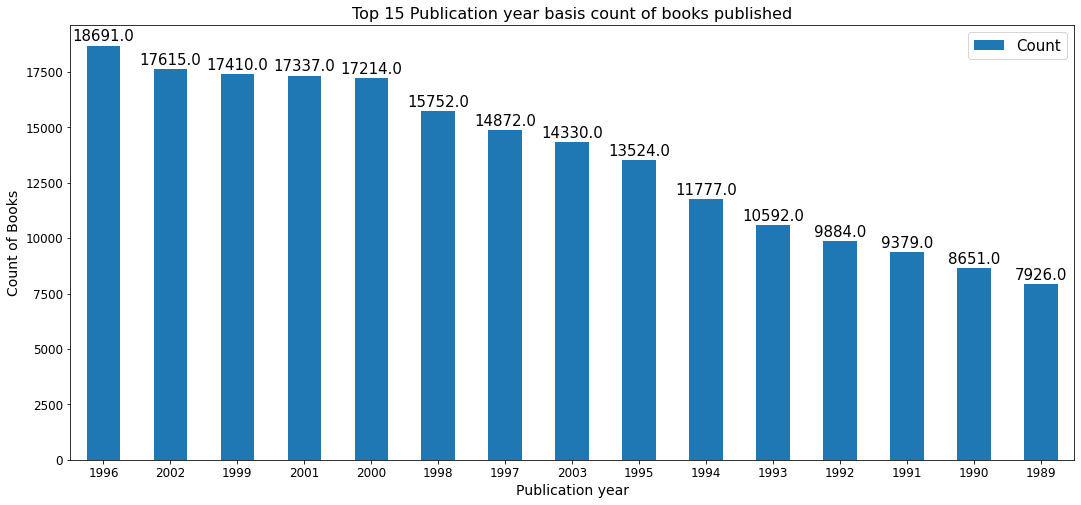

In [424]:
# Visualizing top 15 years of Publication basis count of books using Bar chart
plt3 = pub_df[:15].plot(x='Published_year', y='Count', kind='bar', figsize=(18,8))
plt.title("Top 15 Publication year basis count of books published", fontsize=16)
plt.xlabel("Publication year", fontsize=14)
plt.ylabel("Count of Books", fontsize=14)
plt.xticks(rotation=0)
annot(plt3)

### **d. Publisher of Books**

In [425]:
# list pf unique publishers
books['Publisher'].unique()

array(['oxford university press', 'harperflamingo canada',
       'harperperennial', ..., 'tempo', 'life works books', 'connaught'],
      dtype=object)

In [426]:
# Publishers and their count of books
books['Publisher'].value_counts()

harlequin              7533
silhouette             4218
pocket                 3896
ballantine books       3772
bantam books           3642
                       ... 
anita roddick books       1
d c cook pub              1
playmore                  1
blue mountain press       1
connaught                 1
Name: Publisher, Length: 16287, dtype: int64

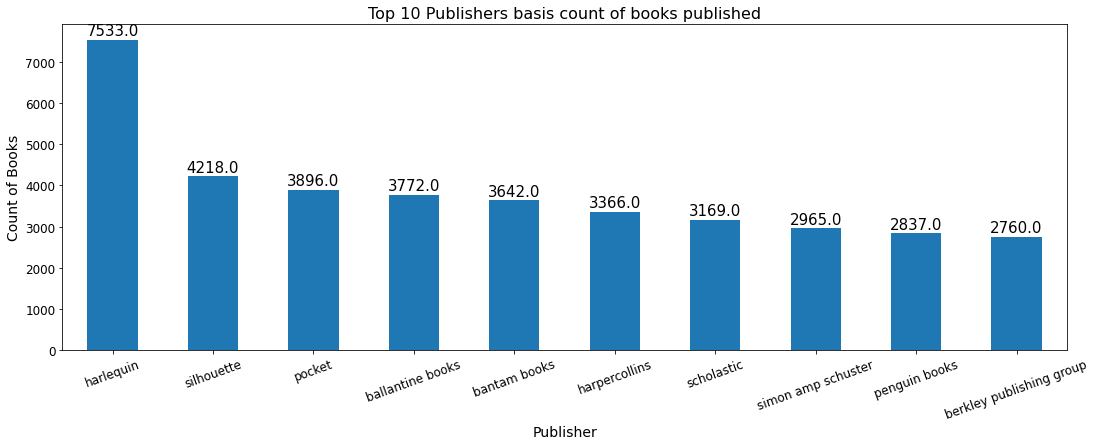

In [427]:
# Visualizing top 10 Publishers basis count of books using Bar chart
plt4 = books['Publisher'].value_counts()[:10].plot(kind='bar', figsize=(18,6))
plt.title("Top 10 Publishers basis count of books published", fontsize=16)
plt.xlabel("Publisher", fontsize=14)
plt.ylabel("Count of Books", fontsize=14)
plt.xticks(rotation=20)
annot(plt4)

# Step 3: Exploring the Ratings Dataset

## **A. Basic Information about ratings dataset**

In [428]:
# A peek into head or top 2 observations of ratings dataframe
ratings.head(2)

User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5

In [429]:
# checking data type of user id
ratings.loc[0,'User-ID']
# User ID is numeric

276725

In [430]:
# Basic information about ratings dataset
ratings.info()
# There are total 11,49,780 observations.
# Each observation has 3 features, namely User id, ISBN of book and rating given

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [431]:
# Checking unique values in each column
ratings.nunique()
# Each observation is a user-book-rating matrix
# 1,05,283 unique users 
# there are total 11 unique book-ratings ranging from 0 to 10.

User-ID        105283
ISBN           340556
Book-Rating        11
dtype: int64

In [432]:
# checking unique values of ratings by users
ratings['Book-Rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [433]:
# checking statistical parameters of numerical features of ratings dataset
ratings.describe()
# Average book-rating is ~2.87
# Atleast 50% books have ratings of 0 (Implicit rating)-- (Checked later)

User-ID   Book-Rating
count  1.149780e+06  1.149780e+06
mean   1.403864e+05  2.866950e+00
std    8.056228e+04  3.854184e+00
min    2.000000e+00  0.000000e+00
25%    7.034500e+04  0.000000e+00
50%    1.410100e+05  0.000000e+00
75%    2.110280e+05  7.000000e+00
max    2.788540e+05  1.000000e+01

In [434]:
len(ratings[ratings['Book-Rating']>0]), len(ratings[ratings['Book-Rating']>0])/len(ratings)
# Only 4,33,671 observations (~37.7%) have non-zero rating (Explicit rating)

(433671, 0.37717737306267285)

In [435]:
# Checking Null values
ratings.isnull().sum().sort_values(ascending = False)
# No missing values in any column

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

**Observations**:
1. There are total 11,49,780 observations or user-book-ratings.
2. There are 1,05,283 unique users and 11 unique ratings (from 0 to 10, 0 being implicit ratings).
3. Average rating for a book (implicit included) is ~2.87.
4. Only 4,33,671 observations (~37.7%) have non-zero rating (Explicit rating).
5. No value is missing in any column.

## **B. Data Preparation and Cleaning**

### **1. Upper-casing of ISBN**

In [436]:
# Checking ISBN values with X-check digit (Lower case)
ratings[ratings['ISBN']== '068482440x']

User-ID        ISBN  Book-Rating
595687   143497  068482440x            0

In [437]:
# Checking ISBN values with X-check digit (upper case)
ratings[ratings['ISBN']== '068482440X']

User-ID        ISBN  Book-Rating
28725       6575  068482440X            0
33685       7982  068482440X            0
260955     60244  068482440X            0
284883     68029  068482440X            9
321420     76532  068482440X            9
343265     81781  068482440X            0
421109    100648  068482440X            0
453590    108753  068482440X            0
480577    114698  068482440X            0
506828    123410  068482440X            0
560091    135045  068482440X            0
562043    135149  068482440X            8
591092    142524  068482440X            0
773104    187145  068482440X            0
802464    194803  068482440X           10
917035    223501  068482440X            8
921363    224430  068482440X            0
990339    238120  068482440X            0
1085206   259626  068482440X            0
1116214   267830  068482440X            0
1123921   269566  068482440X            0

**Note:**

It turns out that check-digit "X" is wrongly written in both upper and lower cases. Let's corrrect these to upper-case only.

In [438]:
# Converting lowercase ISBN to upper case
ratings['ISBN'] = ratings['ISBN'].apply(lambda x:x.upper())

In [439]:
# Checking ISBN values with X-check digit (upper case only)
ratings[ratings['ISBN']== '068482440X']
# We can see that all ISBN with X-Check digits are corrected to upper case format.

User-ID        ISBN  Book-Rating
28725       6575  068482440X            0
33685       7982  068482440X            0
260955     60244  068482440X            0
284883     68029  068482440X            9
321420     76532  068482440X            9
343265     81781  068482440X            0
421109    100648  068482440X            0
453590    108753  068482440X            0
480577    114698  068482440X            0
506828    123410  068482440X            0
560091    135045  068482440X            0
562043    135149  068482440X            8
591092    142524  068482440X            0
595687    143497  068482440X            0
773104    187145  068482440X            0
802464    194803  068482440X           10
917035    223501  068482440X            8
921363    224430  068482440X            0
990339    238120  068482440X            0
1085206   259626  068482440X            0
1116214   267830  068482440X            0
1123921   269566  068482440X            0

In [440]:
# Number of unique ISBN in ratings dataset
ratings['ISBN'].nunique()
# Number of unique ISBN have decreased, it implies that there only 3,40,218 unique books.

340218

In [441]:
# Removing punctuations (if any)
ratings['ISBN'].apply(remove_punctuations)

0           034545104X
1           0155061224
2           0446520802
3           052165615X
4           0521795028
              ...     
1149775     1563526298
1149776     0679447156
1149777     0515107662
1149778     0590442449
1149779    05162443314
Name: ISBN, Length: 1149780, dtype: object

In [442]:
# Checking count of unique ISBN in ratings dataset
ratings['ISBN'].nunique()

340218

**Observations**:
1. Before upercasing ISBN, total unique ISBN were 3,40,556. After uppercasing, unique ISBN dropped to 3,40,218 only.
2. **There are only 3,40,218 unique books in ratings dataset.**

### **2. Checking Duplicates**

In [443]:
# Checking repeated/duplicate observations in ratings dataset
ratings.duplicated().sum()
# No duplicates present

0

In [444]:
# checking basic info about ratings dataset
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


**There are no duplicated observation in ratings dataset!!**

### **3. Renaming Columns for ease of coding**

In [445]:
# checking column names before renaming
ratings.columns

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

In [446]:
# Renaming columns
ratings.rename(columns={'User-ID':'User_ID', 'Book-Rating':'Book_rating'}, inplace=True)

## **C. Exploratory Data Analysis & Visualization**

In [447]:
# getting column names after re-naming
ratings.columns

Index(['User_ID', 'ISBN', 'Book_rating'], dtype='object')

### **1. Univariate Analysis: Ratings Column**

In [448]:
# Ratings and their count of user-book pairs
ratings[['Book_rating']].value_counts(normalize = True)

Book_rating
0              0.622823
8              0.090222
10             0.068370
7              0.066497
9              0.058743
5              0.044334
6              0.032114
4              0.007744
3              0.005215
2              0.002400
1              0.001539
dtype: float64

In [449]:
# Ratings distribution by count of user-book pairs
plt.rc("font", size = 15)
ratings['Book_rating'].value_counts(sort=False).sort_index().plot(kind = 'bar', figsize = (12,6))
plt.title('Ratings Distribution by count')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.plot()

[]

In [450]:
# Dividing ratings data into explicit and implicit ratings data
explicit_r = ratings[ratings['Book_rating'] != 0]
implicit_r = ratings[ratings['Book_rating'] == 0]

In [451]:
# getting percentage of user-book interactions with explicit ratings
exp_count = round(len(explicit_r)*100/len(ratings), 2)
# getting percentage of user-book interactions with implicit ratings
imp_count = round(len(implicit_r)*100/len(ratings), 2)
# creating a dataframe to store above results
rat_count = pd.DataFrame(columns=['rating_type', 'count'])
rat_count.loc[0,:] = ['Explicit ratings', exp_count]
rat_count.loc[1,:] = ['Implicit ratings', imp_count]
rat_count.set_index('rating_type', inplace=True)

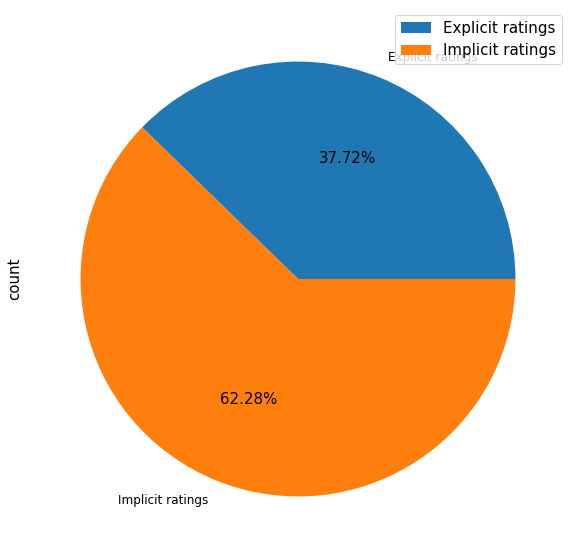

In [452]:
# Plotting distribution of user-book interactions basis type of ratings
rat_count.plot(kind='pie', y='count', x='rating_type', figsize =(10,10), autopct='%.2f%%')

In [453]:
# Explicit Ratings distribution
plt.rc("font", size = 15)
explicit_r['Book_rating'].value_counts(sort=False).sort_index().plot(kind = 'bar', figsize = (12,6))
plt.title('Distribution of Explicit Ratings basis count (for the whole ratings dataset)')
plt.xlabel('Explicit Ratings')
plt.ylabel('Count of books')
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

**Observations**:
1. Majority of ratings are implicit (~62%).
2. Among user-book pairs with explicit ratings, rating value of 8 has the highest count, followed by 10 and 7.

### **2. Univariate Analysis: ISBN**

In [454]:
# Getting count of unique ISBN in ratings dataset
ratings['ISBN'].nunique()

340218

In [455]:
# Getting count of ISBNs with implicit ratings & respective percentage share of total unique ISBN of books rated
print('Count of ISBN with implicit ratings:', implicit_r['ISBN'].nunique(), '& percentage of total ISBN with implicit ratings:', 
      round((implicit_r['ISBN'].nunique()*100)/ratings['ISBN'].nunique(),2) )

Count of ISBN with implicit ratings: 246520 & percentage of total ISBN with implicit ratings: 72.46


In [456]:
# Getting count of ISBNs with explicit ratings & respective percentage share of total unique ISBN of books rated
print('Count of ISBN with explicit ratings:', explicit_r['ISBN'].nunique(), '& percentage of total ISBN with explicit ratings:', 
      round((explicit_r['ISBN'].nunique()*100)/ratings['ISBN'].nunique(),2) )

Count of ISBN with explicit ratings: 185842 & percentage of total ISBN with explicit ratings: 54.62


### **3. Univariate Analysis: User IDs**

In [457]:
# checking count of unique users in complete dataset and in separated implicit and explicit datasets
ratings['User_ID'].nunique(), implicit_r['User_ID'].nunique(), explicit_r['User_ID'].nunique()

(105283, 59517, 77805)

In [458]:
# Total observations in dataset
len(ratings)

1149780

In [459]:
# What percent of total observations are unique users?
print( 'Percent of total observations, that are unique users:', round((ratings['User_ID'].nunique() * 100)/len(ratings),2))

Percent of total observations, that are unique users: 9.16


In [460]:
# What percent of total unique users have given implicit ratings?
print( 'Percent of total unique users, who have given implicit ratings:', round((implicit_r['User_ID'].nunique()* 100)/
                                                                     ratings['User_ID'].nunique(),2))

Percent of total unique users, who have given implicit ratings: 56.53


In [461]:
# What percent of total unique users have given explicit ratings?
print( 'Percent of total unique users, who have given explicit ratings:', round((explicit_r['User_ID'].nunique()* 100)/
                                                                     ratings['User_ID'].nunique(),2))

Percent of total unique users, who have given explicit ratings: 73.9


### **Bi-variate Analysis**

### **a. User and their respective count of books rated**

In [462]:
# For whole rating (implicit included)
ratings.groupby(['User_ID'])['User_ID'].count().sort_values(ascending=False)

User_ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
118579        1
118576        1
118574        1
118563        1
139146        1
Name: User_ID, Length: 105283, dtype: int64

In [463]:
# For explicit ratings only
explicit_r.groupby(['User_ID'])['User_ID'].count().sort_values(ascending=False)

User_ID
11676     8524
98391     5802
153662    1969
189835    1906
23902     1395
          ... 
84129        1
165812       1
34231        1
165826       1
41658        1
Name: User_ID, Length: 77805, dtype: int64

In [464]:
# For Implicit ratings only
implicit_r.groupby(['User_ID'])['User_ID'].count().sort_values(ascending=False)

User_ID
198711    7533
11676     5078
35859     5021
212898    4782
278418    4416
          ... 
120942       1
120947       1
120956       1
120962       1
139814       1
Name: User_ID, Length: 59517, dtype: int64

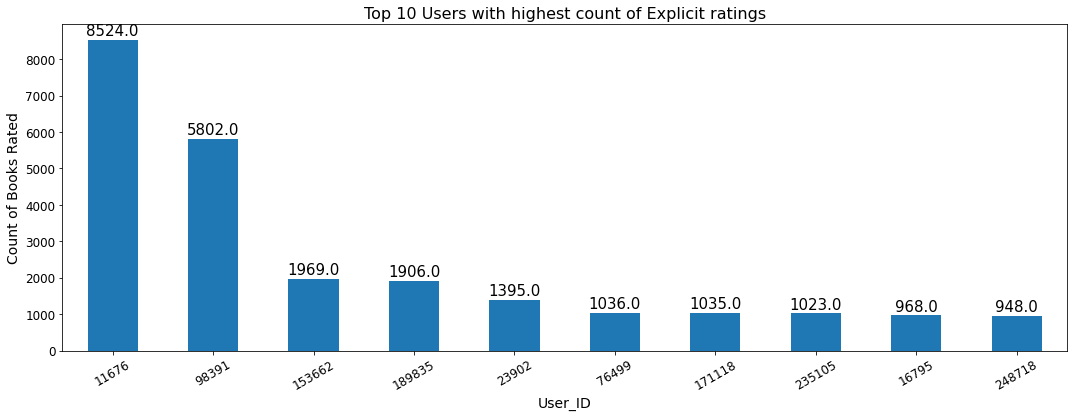

In [465]:
# Bar chart to visualize top 10 Users with highest count of Explicit ratings
plt_1 = explicit_r.groupby(['User_ID'])['User_ID'].count().sort_values(ascending=False)[:10].plot(kind='bar', figsize=(18,6))
plt.title("Top 10 Users with highest count of Explicit ratings", fontsize=16)
plt.xlabel("User_ID", fontsize=14)
plt.ylabel("Count of Books Rated", fontsize=14)
plt.xticks(rotation=30)
annot(plt_1)

In [466]:
# User 11676 with highest count of explicit ratings
users[users['User-ID']==11676]

User-ID       Location  Age
11675    11676  n/a, n/a, n/a  NaN

In [467]:
# User 11676 with 2nd highest count of explicit ratings
users[users['User-ID']==98391]

User-ID              Location   Age
98390    98391  morrow, georgia, usa  52.0

**Observations**:
1. There are total 77,805 users who have given explicit ratings.
2. 59,517 users have given 0 ratings (Implicit).
3. We have information missing for User (11676) with highest count of explicit ratings.
4. User (98391) with 2nd highest count of explicit ratings is 52 years old and from Georgia, USA.

### **b. User-wise average book-ratings**

In [468]:
# Checking average of ratings given by each user
# For whole ratings data (implicit included)
user_avg_rating = ratings.groupby(['User_ID'])['Book_rating'].mean().sort_values(ascending=False)
user_avg_rating = user_avg_rating.to_frame()
user_avg_rating.head()

Book_rating
User_ID             
162951          10.0
21620           10.0
210063          10.0
250956          10.0
21611           10.0

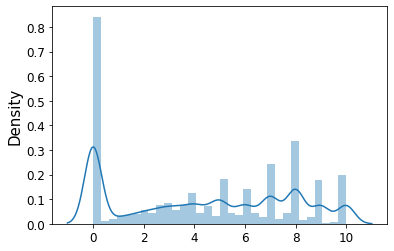

In [469]:
# Density plot of "Average of ratings given by each user"
sns.distplot(user_avg_rating)

In [470]:
# Checking statistical parameters of "average of ratings given by each user"
user_avg_rating.describe()

Book_rating
count  105283.000000
mean        4.394235
std         3.411761
min         0.000000
25%         0.000000
50%         4.600000
75%         7.500000
max        10.000000

In [471]:
# Checking percentage of users who gave solid 10 ratings
round(len(user_avg_rating[user_avg_rating['Book_rating']==10])*100/len(user_avg_rating), 2)
# Around 6% users have given average ratings of 10

6.12

In [472]:
# Checking percentage of users with implicit ratings
round(len(user_avg_rating[user_avg_rating['Book_rating']==0])*100/len(user_avg_rating),2)
# Around 26% users have given average ratings of 0 (Implicit ratings)

26.1

### **c. Book-wise Average Ratings**

In [473]:
# Checking average of ratings against each Book
# For whole rating (implicit included)
book_avg_rating = ratings.groupby(['ISBN'])['Book_rating'].mean().sort_values(ascending=False)
book_avg_rating = book_avg_rating.to_frame()

In [474]:
# Renaming column
book_avg_rating.rename(columns ={'Book_rating':'Avg_rating'}, inplace=True)

In [475]:
# Top 10 books basis highest average ratings
book_avg_rating[:10]

Avg_rating
ISBN                  
4770027443        10.0
1554040302        10.0
0399517006        10.0
0155017969        10.0
0440401925        10.0
0552547166        10.0
0425198014        10.0
0312158343        10.0
0312162154        10.0
1555000363        10.0

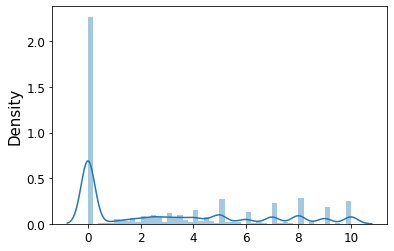

In [476]:
# Density plot of "average of ratings against each Book"
sns.distplot(book_avg_rating)

In [477]:
# Checking statistical parameters of "average of ratings against each Book"
book_avg_rating.describe(percentiles =[0,0.25,0.5,0.75,0.9,0.95,1])

Avg_rating
count  340218.000000
mean        2.943490
std         3.344963
min         0.000000
0%          0.000000
25%         0.000000
50%         1.800000
75%         5.000000
90%         8.000000
95%         9.500000
100%       10.000000
max        10.000000

In [478]:
# Checking count of books with solid 10 as their average rating
round(len(book_avg_rating[book_avg_rating['Avg_rating']==10])*100/len(book_avg_rating),2)
# Around 5% books have average ratings of 10

4.92

In [479]:
# Checking count of books with 0 as their average rating (Implicit Rating)
round(len(book_avg_rating[book_avg_rating['Avg_rating']==0])*100/len(book_avg_rating), 2)
# Around 45% books have average ratings of 0 (Implicit ratings)

45.38

# Step 4: Exploring the Users Dataset

## **A. Basic Information about ratings dataset**

In [480]:
# A peek into head or top 5 observations of users dataframe
users.head()

User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

In [481]:
# Checking 1st entries of each column
users.loc[0,'User-ID'], users.loc[0,'Location'], users.loc[1,'Age']
# User ID and age is numeric
# Location is of string data type.

(1, 'nyc, new york, usa', 18.0)

In [482]:
# Basic information about users dataset
users.info()
# There are total 2,78,858 observations.
# Each observation has 3 features, namely User id, Location and age

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [483]:
# Checking unique values in each column
users.nunique()
# 2,78,858 unique users 

User-ID     278858
Location     57339
Age            165
dtype: int64

In [484]:
# Checking statistical parameters of numerical features of users data
users.describe()
# Average age of users is ~35 years.
# Minimum age os 0 year and Maximum age is 244 years -- Ambiguous data (Investigated and treated later)

User-ID            Age
count  278858.00000  168096.000000
mean   139429.50000      34.751434
std     80499.51502      14.428097
min         1.00000       0.000000
25%     69715.25000      24.000000
50%    139429.50000      32.000000
75%    209143.75000      44.000000
max    278858.00000     244.000000

In [485]:
# Checking Null values
users.isnull().sum().sort_values(ascending = False)
# Total 1,10,762 usera have missing age values.

Age         110762
User-ID          0
Location         0
dtype: int64

**Observations**:
1. There are total 2,78,858 observations.
2. Each observation has 3 features, namely User id, Location and age
3. There are total 2,78,858 unique users in this dataset.
4. There are 1,10,762 values missing in age column and there are few age values as 0 and 244 (Something wrong --> was checked and treated later)

## **B. Data Cleaning**

In [486]:
# Checking data types of each column
users.info()
# All are correct data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


### **1. Handling Missing and Invalid Ages**

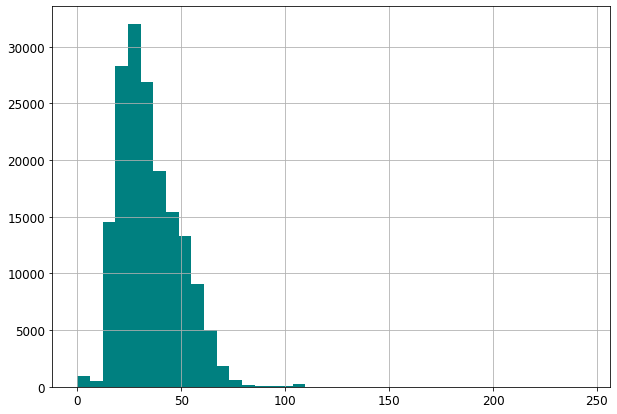

In [487]:
# Plotting histogram for age column
plt.figure(figsize=(10, 7))
users['Age'].hist(bins=40, color='teal')
# Age column has some invalid entries like nan, 0 and very high values like 100 and above

In [488]:
# Checking statistical parameters of age before Treatment
users['Age'].describe(percentiles=[0,0.25,0.5,0.75,0.95, 0.99,1])

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
0%            0.000000
25%          24.000000
50%          32.000000
75%          44.000000
95%          60.000000
99%          71.000000
100%        244.000000
max         244.000000
Name: Age, dtype: float64

In [489]:
# Checking count of users and unique users in users dataset
len(users), users['User-ID'].nunique()

(278858, 278858)

In [490]:
# Checking out users of age 0.
users[users['Age']==0]
# It seems that these values are either incorrect data or missing data

User-ID                                           Location  Age
219         220                           bogota, bogota, colombia  0.0
469         470                         indianapolis, indiana, usa  0.0
561         562      adfdaf, australian capital territory, albania  0.0
1460       1461                             kolding, none, denmark  0.0
1909       1910                               vigo, galicia, spain  0.0
3610       3611                        santa rosa, california, usa  0.0
4041       4042                             san marcos, texas, usa  0.0
5501       5502                          bloomington, indiana, usa  0.0
5569       5570                            jhang, punjab, pakistan  0.0
6361       6362     puracic - lukavac, n/a, bosnia and herzegovina  0.0
6625       6626                udine, friuli venezia giulia, italy  0.0
7111       7112                      bakum, niedersachsen, germany  0.0
7736       7737                        barcelona, catalunya, spain  0.0
8432       8433                           santiago, galicia, spain  0.0
8549       8550                      palm springs, california, usa  0.0
8594       8595                              soldotna, alaska, usa  0.0
8799       8800                                 luan, anhui, china  0.0
9167       9168                   chapel hill, north carolina, usa  0.0
9698       9699                   valencia, yukon territory, spain  0.0
9967       9968                               omaha, nebraska, usa  0.0
13913     13914           tel aviv, no states in israel :), israel  0.0
14487     14488               aachen, nordrhein-westfalen, germany  0.0
14531     14532                              aveiro, n/a, portugal  0.0
16273     16274                     seremange-erzange, n/a, france  0.0
16512     16513                            berlin, berlin, germany  0.0
16686     16687                              orlando, florida, usa  0.0
17177     17178                                cairo, cairo, egypt  0.0
17215     17216                       halifax, nova scotia, canada  0.0
17389     17390                              phoenix, arizona, usa  0.0
17405     17406                         winnipeg, manitoba, canada  0.0
20844     20845                            berlin, berlin, germany  0.0
20850     20851                lübeck, schleswig-holstein, germany  0.0
20852     20853                                        nürnberg, ,  0.0
20855     20856            schaffhausen, schaffhausen, switzerland  0.0
20858     20859               tübingen, baden-württemberg, germany  0.0
20925     20926                              phoenix, arizona, usa  0.0
21463     21464                 sydney, new south wales, australia  0.0
21911     21912                       oxford, oxon, united kingdom  0.0
22345     22346                   amersfoort, utrecht, netherlands  0.0
23819     23820                              madrid, madrid, spain  0.0
24167     24168                             corning, new york, usa  0.0
24506     24507                                  nice, n/a, france  0.0
24674     24675                           lisboa, lisboa, portugal  0.0
24870     24871                 bonn, nordrhein-westfalen, germany  0.0
25110     25111                 aylesbury, england, united kingdom  0.0
25143     25144                          kingston, ontario, canada  0.0
26883     26884                 sydney, new south wales, australia  0.0
27013     27014                    london, england, united kingdom  0.0
27551     27552                        minneapolis, minnesota, usa  0.0
28367     28368                          leipzig, sachsen, germany  0.0
28564     28565                   southport, queensland, australia  0.0
29327     29328                          utrecht, n/a, netherlands  0.0
29626     29627                    bolton, england, united kingdom  0.0
30619     30620                          crookston, minnesota, usa  0.0
32479     32480                                 

In [491]:
# Checking percentage of users of 0 year age value
round(len(users[users['Age']==0])*100/users['User-ID'].nunique(), 2)
# ~0.15% users have given their age as 0 --- Invalid data

0.15

In [492]:
# Checking percentage of users of less than 6 years age value
round(len(users[users['Age']<6])*100/users['User-ID'].nunique(), 2)
# ~0.33% users have given their age less than 6 years --- Invalid data

0.33

In [493]:
# Checking perCentage of users of more than 90 years age value
round(len(users[users['Age']>90])*100/users['User-ID'].nunique(), 2)
# ~0.15% users have given their age more than 90 years --- Invalid data

0.15

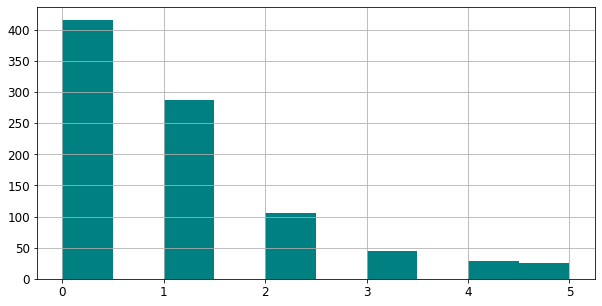

In [494]:
# Checking count distribution of users of less than 6 years age
plt.figure(figsize=(10, 5))
users[users['Age']<6]['Age'].hist(color='teal')
# Age column has some invalid entries like nan, 0 and very high values like 100 and above

In [495]:
# Getting percentage of users with missing ages
round(len(users[users['Age'].isnull()])*100/len(users), 2)
# ~11 lakhs user have missing ages
# Around 40% users have missing ages

39.72

**Ambiguous age values:**
1. Ages below 6 years  -- 0.33% users
2. Ages above 90 years  -- 0.15% users
3. Missing ages  --- ~40% users

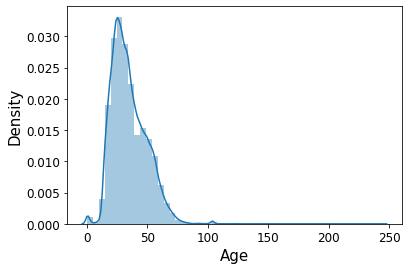

In [496]:
# Density plot of age column
sns.distplot(users['Age'])
# Density plot is skewed towards right, meaning outliers on the positive side.

In [497]:
# Ages below 6 and above 90 years do not make much sense 
# I have decided to replace these by Median age value
users.loc[(users.Age > 90) | (users.Age < 6), 'Age'] = np.nan

# Replacing all NaNs with median (as age density plot is positively-skewed)
users.Age = users.Age.fillna(users.Age.median())

# setting the data type as int
users.Age = users.Age.astype(np.int32)

**Note:**

* To deal with anbiguous age values such as below 6 years, more than 90 years and missing age values, i have decided to subsitute all these with Median age value.
* Median age was selected instead of mean age due to presence of lot of outliers on the right-side of age-density plot (Positively-skewewd)

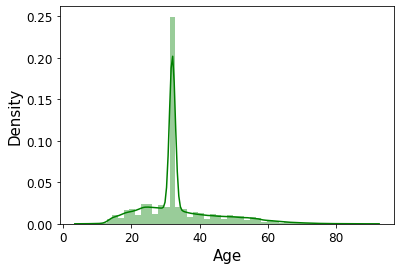

In [498]:
# Density plot off age column after substitution
sns.distplot(users['Age'], color='green')
# Density plot is skewed towards right, meaning outliers on the positive side.

In [499]:
# Checking statistical parameters of age after substitution
users['Age'].describe(percentiles=[0,0.25,0.5,0.75,0.95, 0.99,1])

count    278858.000000
mean         33.631637
std          10.587700
min           6.000000
0%            6.000000
25%          29.000000
50%          32.000000
75%          35.000000
95%          56.000000
99%          67.000000
100%         90.000000
max          90.000000
Name: Age, dtype: float64

Text(0, 0.5, 'Count')

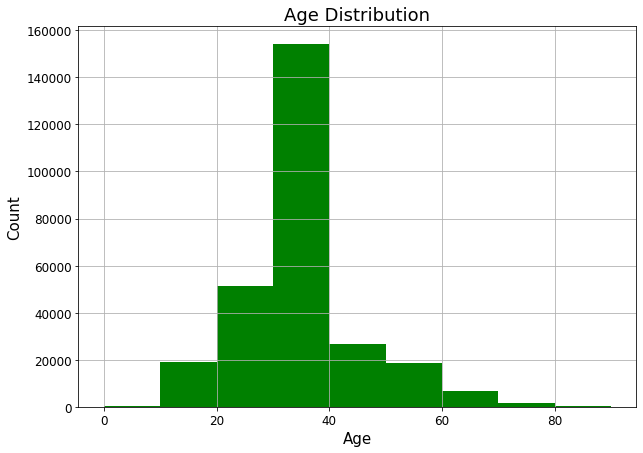

In [500]:
# Age histograms after cleaning invalid ages
plt.figure(figsize=(10, 7))
users['Age'].hist(bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90], color='green')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

### **2. Renaming Columns**

In [501]:
# getting names of columns of users dataset Before renaming
users.columns

Index(['User-ID', 'Location', 'Age'], dtype='object')

In [502]:
# renaming columns of users dataset
users.rename(columns={'User-ID':'User_ID'}, inplace = True)

In [503]:
# Checking names of columns of users dataset after renaming
users.columns

Index(['User_ID', 'Location', 'Age'], dtype='object')

## **C. Extracting User's Country**

In [504]:
# Taking a glance at locations of users
users['Location']

0                         nyc, new york, usa
1                  stockton, california, usa
2            moscow, yukon territory, russia
3                  porto, v.n.gaia, portugal
4         farnborough, hants, united kingdom
                         ...                
278853                 portland, oregon, usa
278854    tacoma, washington, united kingdom
278855             brampton, ontario, canada
278856             knoxville, tennessee, usa
278857                  dublin, n/a, ireland
Name: Location, Length: 278858, dtype: object

In [505]:
# Extracting country of user from location values
users['country'] = users['Location'].apply(lambda x:((x.split(','))[-1]).split(' ')[-1])

In [506]:
# checking country column
users['country']

0              usa
1              usa
2           russia
3         portugal
4          kingdom
            ...   
278853         usa
278854     kingdom
278855      canada
278856         usa
278857     ireland
Name: country, Length: 278858, dtype: object

In [507]:
# Checking count of unique countries of users
users['country'].nunique()
# 649 unique countries 
# -- AMBIGUOUS RESULT as there are total 195 countries only!! 
# We either have spelling-errors or a lot of garbage values filled in by users!!

649

### **Let's remove punctuations first**

In [508]:
# removing punctuations
users['country'] = users['country'].apply(remove_punctuations)

In [509]:
# Now checking unique country names for our users/readers
users['country'].nunique()

550

### **Correcting incorrectly spelled country names!!**

In [510]:
users['country'] = np.where(users['country']=='kingdom', 'united kingdom', users['country'])
users['country'] = np.where(users['country']=='uk', 'united kingdom', users['country'])
users['country'] = np.where(users['country']=='kindgonm', 'united kingdom', users['country'])
users['country'] = np.where(users['country']=='london', 'united kingdom', users['country'])
users['country'] = np.where(users['country']=='kindgdom', 'united kingdom', users['country'])
users['country'] = np.where(users['country']=='prchina', 'china', users['country'])
users['country'] = np.where(users['country']=='chian', 'china', users['country'])
users['country'] = np.where(users['country']=='germay', 'germany', users['country'])
users['country'] = np.where(users['country']=='lanka', 'srilanka', users['country'])
users['country'] = np.where(users['country']=='states', 'usa', users['country'])
users['country'] = np.where(users['country']=='staes', 'usa', users['country'])
users['country'] = np.where(users['country']=='hernando', 'usa', users['country'])
users['country'] = np.where(users['country']=='victoria', 'australia', users['country'])

In [511]:
users['country'] = np.where(users['country']=='geuinea', 'germany', users['country'])
users['country'] = np.where(users['country']=='belgique', 'belgium', users['country'])
users['country'] = np.where(users['country']=='mãâ©xico', 'mexico', users['country'])
users['country'] = np.where(users['country']=='phils', 'Philippines', users['country'])
users['country'] = np.where(users['country']=='lake', 'usa', users['country'])
users['country'] = np.where(users['country']=='csa', 'usa', users['country'])
users['country'] = np.where(users['country']=='america', 'usa', users['country'])
users['country'] = np.where(users['country']=='town', 'south africa', users['country'])
users['country'] = np.where(users['country']=='sea', 'caribbean sea', users['country'])

In [512]:
users['country'] = np.where(users['country']=='nrw', 'germany', users['country'])
users['country'] = np.where(users['country']=='méxico', 'mexico', users['country'])
users['country'] = np.where(users['country']=='pasco', 'usa', users['country'])
users['country'] = np.where(users['country']=='empire', 'usa', users['country'])
users['country'] = np.where(users['country']=='catalunyacatalonia', 'spain', users['country'])
users['country'] = np.where(users['country']=='salvador', 'el salvador', users['country'])

In [513]:
users['country'] = np.where(users['country']=='algérie', 'france', users['country'])
users['country'] = np.where(users['country']=='italia', 'italy', users['country'])
users['country'] = np.where(users['country']=='ksa', 'saudi arabia', users['country'])
users['country'] = np.where(users['country']=='ua', 'usa', users['country'])
users['country'] = np.where(users['country']=='baxter', 'usa', users['country'])
users['country'] = np.where(users['country']=='guinea', 'papua new guinea', users['country'])

In [514]:
users['country'] = np.where(users['country']=='england', 'united kingdom', users['country'])
users['country'] = np.where(users['country']=='catalonia', 'spain', users['country'])
users['country'] = np.where(users['country']=='stated', 'usa', users['country'])
users['country'] = np.where(users['country']=='hennipen', 'usa', users['country'])
users['country'] = np.where(users['country']=='rice', 'usa', users['country'])
users['country'] = np.where(users['country']=='nederlands', 'netherlands', users['country'])

In [515]:
users['country'] = np.where(users['country']=='framingham', 'usa', users['country'])
users['country'] = np.where(users['country']=='reich', 'germany', users['country'])
users['country'] = np.where(users['country']=='ust', 'usa', users['country'])
users['country'] = np.where(users['country']=='baltimore', 'usa', users['country'])
users['country'] = np.where(users['country']=='turkei', 'turkey', users['country'])
users['country'] = np.where(users['country']=='philippine', 'philippines', users['country'])

In [516]:
users['country'] = np.where(users['country']=='county', 'usa', users['country'])
users['country'] = np.where(users['country']=='jersey', 'usa', users['country'])
users['country'] = np.where(users['country']=='collin', 'usa', users['country'])
users['country'] = np.where(users['country']=='ukrain', 'ukraine', users['country'])
users['country'] = np.where(users['country']=='cnina', 'china', users['country'])

In [517]:
users['country'] = np.where(users['country']=='catalunya', 'spain', users['country']) 
users['country'] = np.where(users['country']=='texas', 'usa', users['country'])
users['country'] = np.where(users['country']=='burma', 'myanmar', users['country'])

In [518]:
users['country'] = np.where(users['country']=='zealand', 'new zealand', users['country'])
users['country'] = np.where(users['country']=='auckland', 'new zealand', users['country'])
users['country'] = np.where(users['country']=='nyc', 'usa', users['country'])
users['country'] = np.where(users['country']=='kong', 'hong kong', users['country'])
users['country'] = np.where(users['country']=='jackson', 'usa', users['country'])
users['country'] = np.where(users['country']=='thailoand', 'thailand', users['country'])

In [519]:
users['country'] = np.where(users['country']=='autralia', 'australia', users['country'])
users['country'] = np.where(users['country']=='belgi', 'belgium', users['country'])
users['country'] = np.where(users['country']=='franicsco', 'usa', users['country'])
users['country'] = np.where(users['country']=='emirates', 'uae', users['country'])
users['country'] = np.where(users['country']=='cananda', 'canada', users['country'])

In [520]:
users['country'] = np.where(users['country']=='az', 'usa', users['country'])
users['country'] = np.where(users['country']=='ysa', 'usa', users['country'])
users['country'] = np.where(users['country']=='ca', 'belize', users['country']) 
users['country'] = np.where(users['country']=='us', 'usa', users['country'])
users['country'] = np.where(users['country']=='statea', 'usa', users['country'])
users['country'] = np.where(users['country']=='kz', 'kazakhstan', users['country'])
users['country'] = np.where(users['country']=='california', 'usa', users['country'])
users['country'] = np.where(users['country']=='europa', 'slovenia', users['country'])

In [521]:
# Europe??
users[users['country'] == 'europe']

User_ID                            Location  Age country
45601     45602                milan, italy, europe   32  europe
89730     89731              gorizia, italy, europe   32  europe
224714   224715  il-mosta, il-mosta, malta, europe.   32  europe
228162   228163                oslo, norway, europe   32  europe

In [522]:
users.loc[45601,'country'] = 'italy'
users.loc[89730,'country'] = 'italy'
users.loc[224714,'country'] = 'malta'
users.loc[228162,'country'] = 'norway'

In [523]:
users['country'] = np.where(users['country']=='phippines', 'philippines', users['country'])
users['country'] = np.where(users['country']=='pinallas', 'usa', users['country'])
users['country'] = np.where(users['country']=='ct', 'usa', users['country'])
users['country'] = np.where(users['country']=='effingham', 'usa', users['country'])
users['country'] = np.where(users['country']=='svizzera', 'switzerland', users['country'])

In [524]:
users['country'] = np.where(users['country']=='canda', 'canada', users['country'])
users['country'] = np.where(users['country']=='pa', 'panama', users['country'])
users['country'] = np.where(users['country']=='hongkong', 'hong kong', users['country'])
users['country'] = np.where(users['country']=='hillsborough', 'usa', users['country'])
users['country'] = np.where(users['country']=='dublin', 'ireland', users['country'])

In [525]:
users['country'] = np.where(users['country']=='granville', 'usa', users['country'])
users['country'] = np.where(users['country']=='oakland', 'usa', users['country'])
users['country'] = np.where(users['country']=='isreal', 'israel', users['country'])
users['country'] = np.where(users['country']=='newzealand', 'new zealand', users['country'])
users['country'] = np.where(users['country']=='missouri', 'usa', users['country'])

In [526]:
users['country'] = np.where(users['country']=='itlay', 'italy', users['country'])
users['country'] = np.where(users['country']=='republik', 'slovakia', users['country'])
users['country'] = np.where(users['country']=='safrica', 'south africa', users['country'])
users['country'] = np.where(users['country']=='philippinies', 'philippines', users['country'])
users['country'] = np.where(users['country']=='lankana', 'srilanka', users['country'])
users['country'] = np.where(users['country']=='geermany', 'germany', users['country'])

In [527]:
users['country'] = np.where(users['country']=='trinidadtobago', 'trinidad and tobago', users['country'])
users['country'] = np.where(users['country']=='tobago', 'trinidad and tobago', users['country'])
users['country'] = np.where(users['country']=='madrid', 'spain', users['country'])
users['country'] = np.where(users['country']=='worcester', 'usa', users['country'])
users['country'] = np.where(users['country']=='sri lanka', 'srilanka', users['country'])

In [528]:
users['country'] = np.where(users['country']=='Philippines', 'philippines', users['country'])
users['country'] = np.where(users['country']=='ohio', 'usa', users['country'])
users['country'] = np.where(users['country']=='carolina', 'usa', users['country'])
users['country'] = np.where(users['country']=='houston', 'usa', users['country'])
users['country'] = np.where(users['country']=='city', 'vatican city', users['country'])

In [529]:
users['country'] = np.where(users['country']=='chinaöð¹ú', 'china', users['country'])
users['country'] = np.where(users['country']=='sates', 'usa', users['country'])
users['country'] = np.where(users['country']=='australii', 'australia', users['country'])
users['country'] = np.where(users['country']=='queensland', 'australia', users['country'])

In [530]:
users['country'] = np.where(users['country']=='türkiye', 'turkey', users['country'])
users['country'] = np.where(users['country']=='state', 'usa', users['country'])
users['country'] = np.where(users['country']=='indiai', 'india', users['country'])
users['country'] = np.where(users['country']=='malaysian', 'malaysia', users['country'])
users['country'] = np.where(users['country']=='roma', 'italy', users['country'])
users['country'] = np.where(users['country']=='litalia', 'italy', users['country'])

In [531]:
users['country'] = np.where(users['country']=='nz', 'new zealand', users['country'])
users['country'] = np.where(users['country']=='uusa', 'usa', users['country'])

In [532]:
users[users['country'] == 'uusa']

Empty DataFrame
Columns: [User_ID, Location, Age, country]
Index: []

In [533]:
users['country'].nunique()
# Still 445 unknown countries

445

In [534]:
# Top 10 countries basis count of users
country_counts = users['country'].value_counts(normalize=True).to_frame().reset_index()
country_counts.rename(columns={'index':'country', 'country':'percentage'}, inplace=True)
country_counts

country  percentage
0                    usa    0.501323
1                 canada    0.077688
2         united kingdom    0.066704
3                germany    0.061246
4                  spain    0.047634
5              australia    0.042276
6                  italy    0.040580
7                           0.016478
8                 france    0.012630
9               portugal    0.012157
10           new zealand    0.011199
11           netherlands    0.010952
12           switzerland    0.006322
13                brazil    0.006028
14                 china    0.005368
15                sweden    0.005221
16                 india    0.004673
17               austria    0.004120
18              malaysia    0.004041
19             argentina    0.003930
20               finland    0.003382
21             singapore    0.003328
22               denmark    0.003073
23                mexico    0.003062
24               belgium    0.002973
25               ireland    0.002733
26           philippines    0.002715
27                turkey    0.001789
28                poland    0.001646
29              pakistan    0.001592
30                greece    0.001546
31                  iran    0.001460
32               romania    0.001302
33                 chile    0.001298
34                israel    0.001252
35                africa    0.001226
36             indonesia    0.001105
37                norway    0.001069
38                 japan    0.000975
39               croatia    0.000900
40               nigeria    0.000839
41              republic    0.000839
42                 korea    0.000839
43              slovakia    0.000782
44            yugoslavia    0.000638
45                russia    0.000638
46             hong kong    0.000620
47                  rica    0.000602
48                taiwan    0.000595
49              slovenia    0.000531
50                 egypt    0.000509
51                  peru    0.000506
52               vietnam    0.000506
53             venezuela    0.000502
54              colombia    0.000484
55              bulgaria    0.000477
56            luxembourg    0.000380
57               hungary    0.000355
58              thailand    0.000316
59                   uae    0.000301
60                 ghana    0.000287
61                arabia    0.000237
62                españa    0.000230
63              srilanka    0.000215
64           herzegovina    0.000212
65               iceland    0.000197
66            bangladesh    0.000179
67             guatemala    0.000165
68              paraguay    0.000165
69               andorra    0.000158
70               ukraine    0.000154
71             lithuania    0.000151
72                latvia    0.000143
73               bahamas    0.000143
74               bolivia    0.000140
75                panama    0.000140
76               jamaica    0.000136
77   trinidad and tobago    0.000136
78                kuwait    0.000133
79               ecuador    0.000133
80               lebanon    0.000129
81                  cuba    0.000129
82               morocco    0.000126
83                 malta    0.000122
84             macedonia    0.000115
85              scotland    0.000115
86           afghanistan    0.000111
87               albania    0.000111
88                urugua    0.000104
89               algeria    0.000104
90           deutschland    0.000104
91                 kenya    0.000097
92              honduras    0.000097
93                cyprus    0.000097
94            antarctica    0.000097
95                  oman    0.000093
96               bermuda    0.000093
97           el salvador    0.000093
98            uzbekistan    0.000086
99                belize    0.000086
100             zimbabwe    0.000086
101              islands    0.000082
102              estonia    0.000079
103               jordan    0.000079
104            mauritius    0.000075
105                nepal    0.000075
106                 rico    0.000075
107              urug

In [535]:
country = list(country_counts[country_counts['percentage']<0.01]['country'])

In [536]:
# Where country count is less than 1%, take it as "Other" country
for i,row in users.iterrows():
  if row['country'] in country:
    users.loc[i,'country'] = 'Other'

In [537]:
# Blank space as country??
users[users['country'] == '']
# 4595 rows

User_ID                Location  Age country
18           19               weston, ,   14        
90           91    toronto/newmarket, ,   32        
311         312                lk, jlk,   32        
317         318            berlin, n/a,   32        
536         537      davis, california,   32        
...         ...                     ...  ...     ...
278624   278625               savona, ,   36        
278651   278652             murrieta, ,   32        
278697   278698     pasadena, maryland,   32        
278716   278717  mayagüez, puerto rico,   53        
278776   278777  overland park, kansas,   32        

[4595 rows x 4 columns]

In [538]:
# Replacing missing country values by Other
users['country'] = np.where(users['country']=='', 'Other', users['country'])

In [539]:
users['country'].value_counts(normalize=True)

usa               0.501323
Other             0.115611
canada            0.077688
united kingdom    0.066704
germany           0.061246
spain             0.047634
australia         0.042276
italy             0.040580
france            0.012630
portugal          0.012157
new zealand       0.011199
netherlands       0.010952
Name: country, dtype: float64

Text(0.5, 1.0, 'Distribution of users basis their countries')

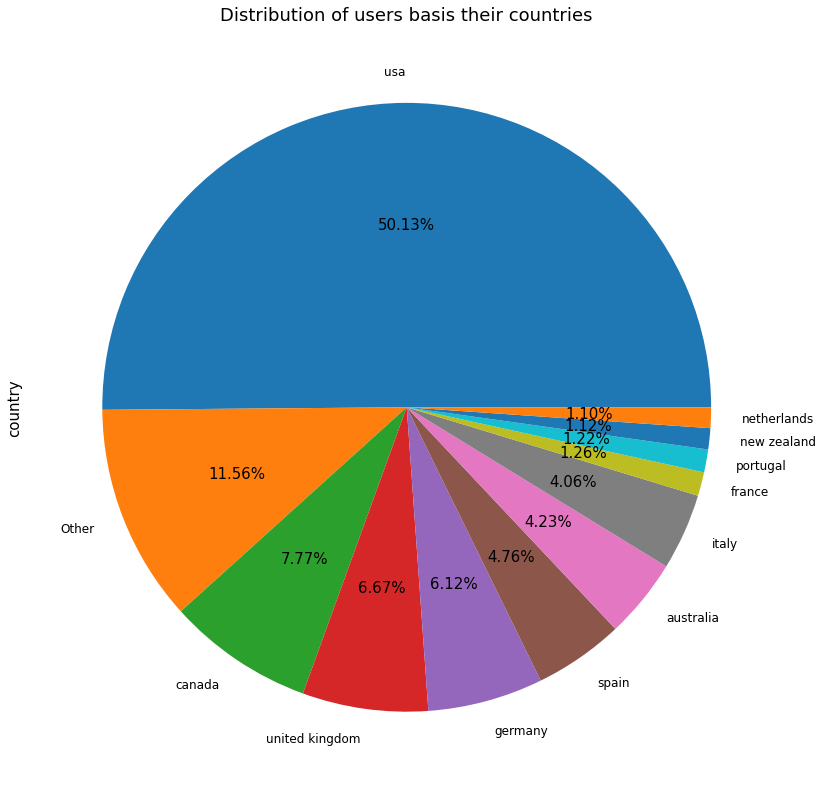

In [540]:
users['country'].value_counts(normalize=True).plot(kind='pie', figsize=(14,14), autopct='%.2f%%')
plt.title("Distribution of users basis their countries", fontsize=18)

Text(0.5, 1.0, 'Top 10 countries basis number of readers')

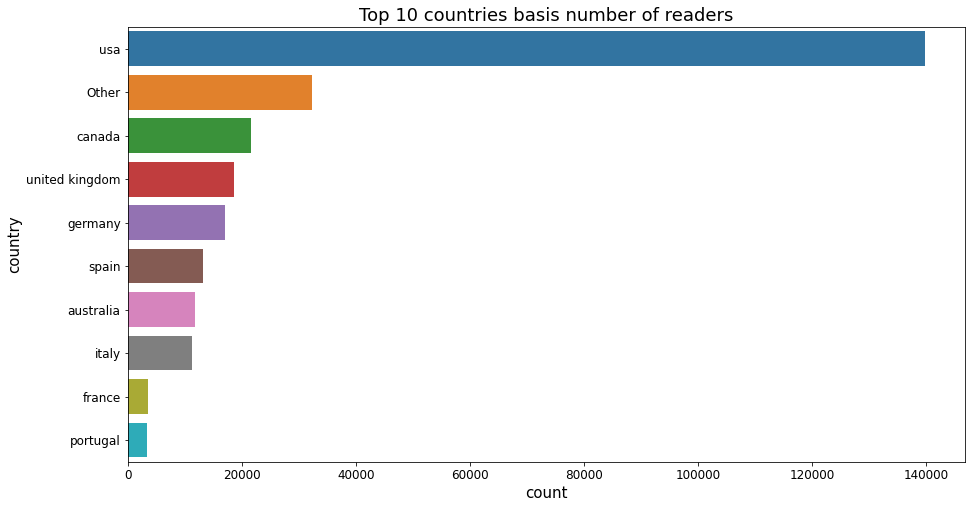

In [541]:
plt.figure(figsize=(15,8))
sns.countplot(y="country", data=users, order=users['country'].value_counts().index[0:10])
plt.title("Top 10 countries basis number of readers")

# Step 5. Merging all Datasets together

In [542]:
# Merging books, ratings and users (Inner Join)
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User_ID', how='inner')
dataset.head(2)

ISBN                Title                Author  Published_year  \
0  0195153448  classical mythology      mark p o morford          2002.0   
1  0002005018         clara callan  richard bruce wright          2001.0   

                 Publisher                                        Image_url_S  \
0  oxford university press  http://images.amazon.com/images/P/0195153448.0...   
1    harperflamingo canada  http://images.amazon.com/images/P/0002005018.0...   

                                         Image_url_M  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   

                                         Image_url_L  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   

                                         Title_by_of  User_ID  Book_rating  \
0  classical mythology_by_mark p o morford_of_oxf...        2            0   
1  clara callan_by_richard bruce wright_of_harper...        8            5   

                    Location  Age country  
0  stockton, california, usa   18     usa  
1   timmins, ontario, canada   32  canada

## **1. Basic Information about Merged dataset**

In [543]:
# Published year is of float data type.
# Let's convert it to integer type (without decimals)
dataset['Published_year'] = dataset['Published_year'].astype(int)

In [544]:
# checking data type after correction
dataset.loc[0,'Published_year']

2002

In [545]:
# Basic info about merged dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ISBN            1031136 non-null  object
 1   Title           1031136 non-null  object
 2   Author          1031136 non-null  object
 3   Published_year  1031136 non-null  int64 
 4   Publisher       1031136 non-null  object
 5   Image_url_S     1031136 non-null  object
 6   Image_url_M     1031136 non-null  object
 7   Image_url_L     1031136 non-null  object
 8   Title_by_of     1031136 non-null  object
 9   User_ID         1031136 non-null  int64 
 10  Book_rating     1031136 non-null  int64 
 11  Location        1031136 non-null  object
 12  Age             1031136 non-null  int32 
 13  country         1031136 non-null  object
dtypes: int32(1), int64(3), object(10)
memory usage: 146.3+ MB


In [546]:
# Checking number of unique values in each column
dataset.nunique()

ISBN              269843
Title             237911
Author             97664
Published_year       101
Publisher          16211
Image_url_S       269842
Image_url_M       269842
Image_url_L       269842
Title_by_of       264438
User_ID            92106
Book_rating           11
Location           22480
Age                   83
country               12
dtype: int64

In [547]:
# Checking statistical parameters of numerical features
dataset.describe()

Published_year       User_ID   Book_rating           Age
count    1.031136e+06  1.031136e+06  1.031136e+06  1.031136e+06
mean     1.995308e+03  1.405945e+05  2.839051e+00  3.566708e+01
std      7.309089e+00  8.052466e+04  3.854157e+00  1.050217e+01
min      1.376000e+03  2.000000e+00  0.000000e+00  6.000000e+00
25%      1.992000e+03  7.041500e+04  0.000000e+00  3.100000e+01
50%      1.997000e+03  1.412100e+05  0.000000e+00  3.200000e+01
75%      2.001000e+03  2.114260e+05  7.000000e+00  4.100000e+01
max      2.004000e+03  2.788540e+05  1.000000e+01  9.000000e+01

In [548]:
# Checking statistical parameters of Non-numerical features
dataset.describe(include='O')

ISBN        Title        Author         Publisher  \
count      1031136      1031136       1031136           1031136   
unique      269843       237911         97664             16211   
top     0971880107  wild animus  stephen king  ballantine books   
freq          2502         2502         10179             34724   

                                              Image_url_S  \
count                                             1031136   
unique                                             269842   
top     http://images.amazon.com/images/P/0971880107.0...   
freq                                                 2502   

                                              Image_url_M  \
count                                             1031136   
unique                                             269842   
top     http://images.amazon.com/images/P/0971880107.0...   
freq                                                 2502   

                                              Image_url_L  \
count                                             1031136   
unique                                             269842   
top     http://images.amazon.com/images/P/0971880107.0...   
freq                                                 2502   

                                   Title_by_of                  Location  \
count                                  1031136                   1031136   
unique                                  264438                     22480   
top     wild animus_by_rich shapero_of_too far  toronto, ontario, canada   
freq                                      2502                     14782   

        country  
count   1031136  
unique       12  
top         usa  
freq     747076

In [549]:
# Checking missing values in complete dataset
dataset.isnull().sum()
# No null values present

ISBN              0
Title             0
Author            0
Published_year    0
Publisher         0
Image_url_S       0
Image_url_M       0
Image_url_L       0
Title_by_of       0
User_ID           0
Book_rating       0
Location          0
Age               0
country           0
dtype: int64

In [550]:
# checking unique user-item interactions
user_item_df = dataset.groupby(['User_ID', 'Title_by_of'])['Book_rating'].count().reset_index()
user_item_df.head(1)

User_ID                                        Title_by_of  Book_rating
0        2  classical mythology_by_mark p o morford_of_oxf...            1

In [551]:
user_item_df['Book_rating'].unique()
# It turns out few users have given multiple ratings to same book. 
# Reason could be due to different ISBN, user gave different ratings to eah ISBN.

array([ 1,  2,  4,  3, 12])

In [552]:
# Lets look into user-item pairs with 4 counts of ratings
user_item_df[user_item_df['Book_rating']==4]

User_ID                                        Title_by_of  \
25131      9227             chobits (chobits)_by_clamp_of_tokyopop   
37755     11676        pet sematary_by_stephen king_of_signet book   
45970     12824             chobits (chobits)_by_clamp_of_tokyopop   
148328    38023             chobits (chobits)_by_clamp_of_tokyopop   
235469    63714  dinosaurs: a celebration_by_dan abnett_of_clie...   
235885    63714  zoids chaotic century (zoids: chaotic century ...   
569351   156111  ranma 1/2 (ranma 1/2)_by_rumiko takahashi_of_v...   
685193   187763  life and teaching of the masters of the far ea...   
707685   194653  storia del cinema italiano_by_g brunetta_of_ed...   
713636   196160             chobits (chobits)_by_clamp_of_tokyopop   
817612   224904             chobits (chobits)_by_clamp_of_tokyopop   
843234   230522  glimmer train stories_by_susan burmeisterbrown...   

        Book_rating  
25131             4  
37755             4  
45970             4  
148328            4  
235469            4  
235885            4  
569351            4  
685193            4  
707685            4  
713636            4  
817612            4  
843234            4

In [553]:
# Checking one of users (11676)
b1 = dataset[dataset['User_ID']==11676]
b1[b1['Title']=='pet sematary']

ISBN         Title        Author  Published_year    Publisher  \
159   0451162072  pet sematary  stephen king            1994  signet book   
3033  0451150244  pet sematary  stephen king            1984  signet book   
3746  0451132378  pet sematary  stephen king            1984  signet book   
4028  0451157753  pet sematary  stephen king            1984  signet book   

                                            Image_url_S  \
159   http://images.amazon.com/images/P/0451162072.0...   
3033  http://images.amazon.com/images/P/0451150244.0...   
3746  http://images.amazon.com/images/P/0451132378.0...   
4028  http://images.amazon.com/images/P/0451157753.0...   

                                            Image_url_M  \
159   http://images.amazon.com/images/P/0451162072.0...   
3033  http://images.amazon.com/images/P/0451150244.0...   
3746  http://images.amazon.com/images/P/0451132378.0...   
4028  http://images.amazon.com/images/P/0451157753.0...   

                                            Image_url_L  \
159   http://images.amazon.com/images/P/0451162072.0...   
3033  http://images.amazon.com/images/P/0451150244.0...   
3746  http://images.amazon.com/images/P/0451132378.0...   
4028  http://images.amazon.com/images/P/0451157753.0...   

                                      Title_by_of  User_ID  Book_rating  \
159   pet sematary_by_stephen king_of_signet book    11676            8   
3033  pet sematary_by_stephen king_of_signet book    11676            6   
3746  pet sematary_by_stephen king_of_signet book    11676            8   
4028  pet sematary_by_stephen king_of_signet book    11676            2   

           Location  Age country  
159   n/a, n/a, n/a   32   Other  
3033  n/a, n/a, n/a   32   Other  
3746  n/a, n/a, n/a   32   Other  
4028  n/a, n/a, n/a   32   Other

In [554]:
# Lets look into user-item pairs with 12 counts of ratings
a = user_item_df[user_item_df['Book_rating']==12]
a.loc[676187,'Title_by_of']

'phonics fun: reading program, pack 4 (clifford the big red dog)_by_francie alexander_of_scholastic'

In [555]:
# checking out one of the users
b = dataset[dataset['User_ID']==185233]
b[b['Title']=='phonics fun: reading program, pack 4 (clifford the big red dog)']

ISBN                                              Title  \
317913  0439409292  phonics fun: reading program, pack 4 (clifford...   
317914  0439409314  phonics fun: reading program, pack 4 (clifford...   
317915  0439409322  phonics fun: reading program, pack 4 (clifford...   
317916  0439409349  phonics fun: reading program, pack 4 (clifford...   
317917  0439409284  phonics fun: reading program, pack 4 (clifford...   
317918  0439409276  phonics fun: reading program, pack 4 (clifford...   
317919  0439409373  phonics fun: reading program, pack 4 (clifford...   
317920  0439409330  phonics fun: reading program, pack 4 (clifford...   
317921  0439409365  phonics fun: reading program, pack 4 (clifford...   
317922  0439409357  phonics fun: reading program, pack 4 (clifford...   
317923  0439409381  phonics fun: reading program, pack 4 (clifford...   
317924  0439409306  phonics fun: reading program, pack 4 (clifford...   

                   Author  Published_year   Publisher  \
317913  francie alexander            2003  scholastic   
317914  francie alexander            2003  scholastic   
317915  francie alexander            2003  scholastic   
317916  francie alexander            2003  scholastic   
317917  francie alexander            2003  scholastic   
317918  francie alexander            2003  scholastic   
317919  francie alexander            2003  scholastic   
317920  francie alexander            2003  scholastic   
317921  francie alexander            2003  scholastic   
317922  francie alexander            2003  scholastic   
317923  francie alexander            2003  scholastic   
317924  francie alexander            2003  scholastic   

                                              Image_url_S  \
317913  http://images.amazon.com/images/P/0439409292.0...   
317914  http://images.amazon.com/images/P/0439409314.0...   
317915  http://images.amazon.com/images/P/0439409322.0...   
317916  http://images.amazon.com/images/P/0439409349.0...   
317917  http://images.amazon.com/images/P/0439409284.0...   
317918  http://images.amazon.com/images/P/0439409276.0...   
317919  http://images.amazon.com/images/P/0439409373.0...   
317920  http://images.amazon.com/images/P/0439409330.0...   
317921  http://images.amazon.com/images/P/0439409365.0...   
317922  http://images.amazon.com/images/P/0439409357.0...   
317923  http://images.amazon.com/images/P/0439409381.0...   
317924  http://images.amazon.com/images/P/0439409306.0...   

                                              Image_url_M  \
317913  http://images.amazon.com/images/P/0439409292.0...   
317914  http://images.amazon.com/images/P/0439409314.0...   
317915  http://images.amazon.com/images/P/0439409322.0...   
317916  http://images.amazon.com/images/P/0439409349.0...   
317917  http://images.amazon.com/images/P/0439409284.0...   
317918  http://images.amazon.com/images/P/0439409276.0...   
317919  http://images.amazon.com/images/P/0439409373.0...   
317920  http://images.amazon.com/images/P/0439409330.0...   
317921  http://images.amazon.com/images/P/0439409365.0...   
317922  http://images.amazon.com/images/P/0439409357.0...   
317923  http://images.amazon.com/images/P/0439409381.0...   
317924  http://images.amazon.com/images/P/0439409306.0...   

                                              Image_url_L  \
317913  http://images.amazon.com/images/P/0439409292.0...   
317914  http://images.amazon.com/images/P/0439409314.0...   
317915  http://images.amazon.com/images/P/0439409322.0...   
317916  http://images.amazon.com/images/P/0439409349.0...   
317917  http://images.amazon.com/images/P/0439409284.0...   
317918  http://images.amazon.com/images/P/0439409276.0...   
317919  http://images.amazon.com/images/P/0439409373.0...   
317920  http://images.amazon.com/images/P/0439409330.0...   
317921  http://images.amazon.com/images/P/0439409365.0...   
317922  http://images.amazon.com/images/P/0439409357.0...   
317923  http://images.amazon.com/images/P/0439409381.0...   
31

**Note:**

Since, a single user have given multiple ratings to different ISBN of same book/its series, i will take average of all their ratings per single book with unique title-author-publisher

## **2. Feature Extraction**

### **A. Readers labelling basis Age:**

1. < 13 years: kid
2. Older than 12 years but younger than 20 years: teenager
3. Older than 19 years but younger than 36 years: youth
4. Older than 35 years but younger than 51 years: adult
5. Older than 50 years: senior

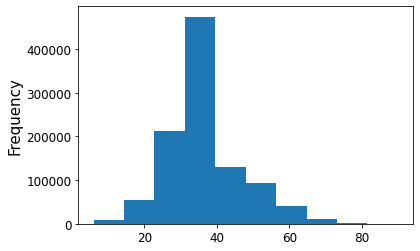

In [556]:
# Plotting histogram for age values
dataset['Age'].plot(kind='hist')

In [557]:
# Creating 5 age groups using age column
bins = [6,12,20,35,50,100]
labels = ['kid', 'teenager', 'youth', 'adult', 'senior']
dataset['age_group'] = pd.cut(x=dataset['Age'], bins=bins, labels=labels, include_lowest=True)

In [558]:
# Checking statistical parameters of age column
dataset['age_group'].describe()

count     1031136
unique          5
top         youth
freq       623251
Name: age_group, dtype: object

In [559]:
# checking value counts of each age group
dataset['age_group'].value_counts()

youth       623251
adult       249028
senior      117934
teenager     36676
kid           4247
Name: age_group, dtype: int64

In [560]:
readers_age = dataset['age_group'].value_counts(normalize=True, sort=False).reset_index()
readers_age.rename(columns={'index':'age_group','age_group':'share(%)'}, inplace=True)
readers_age['share(%)'] = round(readers_age['share(%)']*100,2)
readers_age

age_group  share(%)
0       kid      0.41
1  teenager      3.56
2     youth     60.44
3     adult     24.15
4    senior     11.44

In [561]:
# Distribution of users in merged dataset basis age groups
plt.figure(figsize=(9,6))
sns.barplot(x='age_group', y='share(%)', data=readers_age,  order=readers_age.age_group).set(title='Distribution of Readers basis various age groups')

[Text(0.5, 1.0, 'Distribution of Readers basis various age groups')]

### **b. Count of Ratings and Mean rating**

In [562]:
# getting column names
dataset.columns

Index(['ISBN', 'Title', 'Author', 'Published_year', 'Publisher', 'Image_url_S',
       'Image_url_M', 'Image_url_L', 'Title_by_of', 'User_ID', 'Book_rating',
       'Location', 'Age', 'country', 'age_group'],
      dtype='object')

In [563]:
# Calculating the rating count and mean rating given to each unique book (i.e., Title-auth-publisher) by the users
num_rating = dataset.groupby('Title_by_of')['Book_rating'].count().to_frame()
avg_rating = dataset.groupby('Title_by_of')['Book_rating'].mean().to_frame()

# Renaming the column names before merging them with the final dataset.
num_rating.rename(columns={'Book_rating':'Rating_count'}, inplace=True)
avg_rating.rename(columns={'Book_rating':'Rating_mean'}, inplace=True)

In [564]:
# Merging with our complete dataset
dataset = pd.merge(dataset, num_rating, on='Title_by_of', how='inner')
dataset = pd.merge(dataset, avg_rating, on='Title_by_of', how='inner')

In [565]:
# Rounding off the average ratings
dataset['Rating_mean'] = dataset['Rating_mean'].round(2)
# dropping unnecessary image-url columns
dataset.drop(columns=['Image_url_S','Image_url_M','Image_url_L'],inplace=True)
# Looking at head
dataset.head()

ISBN                Title                Author  Published_year  \
0  0195153448  classical mythology      mark p o morford            2002   
1  0002005018         clara callan  richard bruce wright            2001   
2  0002005018         clara callan  richard bruce wright            2001   
3  0002005018         clara callan  richard bruce wright            2001   
4  0002005018         clara callan  richard bruce wright            2001   

                 Publisher                                        Title_by_of  \
0  oxford university press  classical mythology_by_mark p o morford_of_oxf...   
1    harperflamingo canada  clara callan_by_richard bruce wright_of_harper...   
2    harperflamingo canada  clara callan_by_richard bruce wright_of_harper...   
3    harperflamingo canada  clara callan_by_richard bruce wright_of_harper...   
4    harperflamingo canada  clara callan_by_richard bruce wright_of_harper...   

   User_ID  Book_rating                   Location  Age country age_group  \
0        2            0  stockton, california, usa   18     usa  teenager   
1        8            5   timmins, ontario, canada   32  canada     youth   
2    11400            0    ottawa, ontario, canada   49  canada     adult   
3    11676            8              n/a, n/a, n/a   32   Other     youth   
4    41385            0   sudbury, ontario, canada   32  canada     youth   

   Rating_count  Rating_mean  
0             1         0.00  
1            14         4.93  
2            14         4.93  
3            14         4.93  
4            14         4.93

### Let's divide datasets into 2 parts basis type of ratings:
1. **Explicit ratings dataset**
2. **Implicit Ratings dataset**

In [566]:
# Explicit dataset (Non-zero ratings)
exp_data = dataset[dataset['Book_rating']!=0]
# Implicit dataset (Zero ratings assigned)
imp_data = dataset[dataset['Book_rating']==0]
print("Shape of datasets:")
print("1. Explicit dataset:", exp_data.shape)
print("2. Implicit dataset:", imp_data.shape)

Shape of datasets:
1. Explicit dataset: (383842, 14)
2. Implicit dataset: (647294, 14)


In [567]:
exp_data.head(2)

ISBN         Title                Author  Published_year  \
1  0002005018  clara callan  richard bruce wright            2001   
3  0002005018  clara callan  richard bruce wright            2001   

               Publisher                                        Title_by_of  \
1  harperflamingo canada  clara callan_by_richard bruce wright_of_harper...   
3  harperflamingo canada  clara callan_by_richard bruce wright_of_harper...   

   User_ID  Book_rating                  Location  Age country age_group  \
1        8            5  timmins, ontario, canada   32  canada     youth   
3    11676            8             n/a, n/a, n/a   32   Other     youth   

   Rating_count  Rating_mean  
1            14         4.93  
3            14         4.93

## **3. Exploratory Data Analysis & Visualization**

In [568]:
# getting column names
dataset.columns

Index(['ISBN', 'Title', 'Author', 'Published_year', 'Publisher', 'Title_by_of',
       'User_ID', 'Book_rating', 'Location', 'Age', 'country', 'age_group',
       'Rating_count', 'Rating_mean'],
      dtype='object')

## **Univariate Analysis: Rating count**

In [569]:
# Checking statistical parameters of count of ratings per book
dataset['Rating_count'].describe()

count    1.031136e+06
mean     5.645798e+01
std      1.619195e+02
min      1.000000e+00
25%      3.000000e+00
50%      1.000000e+01
75%      4.500000e+01
max      2.502000e+03
Name: Rating_count, dtype: float64

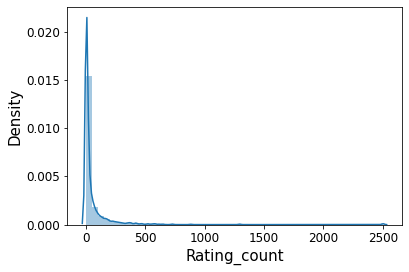

In [570]:
# Density plot of "count of ratings per book"
sns.distplot(dataset['Rating_count'])

In [571]:
# Histogram of "count of ratings per book"
dataset['Rating_count'].hist()

In [572]:
# Histogram of "count of ratings per book"
dataset['Rating_count'].hist(bins=[0,5,10,20,30,40,50,60,70,80,90,100])

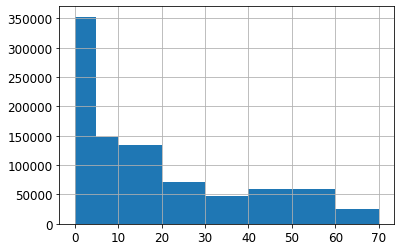

In [573]:
# Histogram of "count of ratings per book"
dataset['Rating_count'].hist(bins=[0,5,10,20,30,40,60,70])

## **3(A). Bi-variate Analysis:**

### **A. Count of Book Ratings**

Text(0.5, 1.0, 'Count of all ratings from 0 to 10 (Implicit Included)')

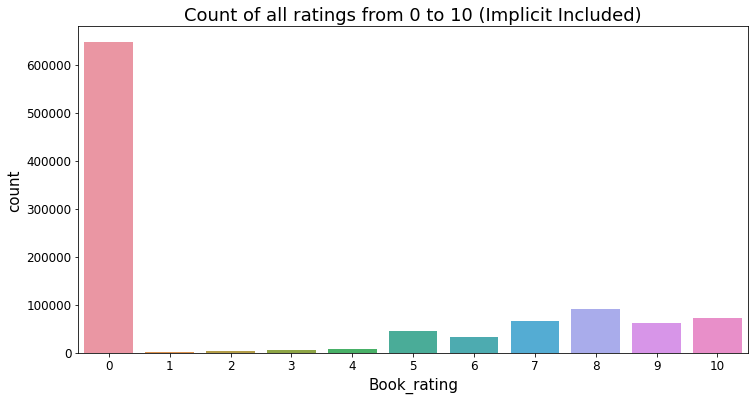

In [574]:
# Count of all ratings from 0 to 10 (Implicit Included)
plt.figure(figsize=(12,6))
sns.countplot(x="Book_rating", data=dataset)
plt.title("Count of all ratings from 0 to 10 (Implicit Included)")

In [575]:
# Count of only explicit ratings from 1 to 10
plt.figure(figsize=(12,6))
sns.countplot(x="Book_rating", data=exp_data)
plt.title("Count of Explicit ratings from 1 to 10")

Text(0.5, 1.0, 'Count of Explicit ratings from 1 to 10')

### **B. Book Title and its Number of Ratings**

Text(0.5, 1.0, 'Top 15 Book titles basis count of ratings (including Implicit)')

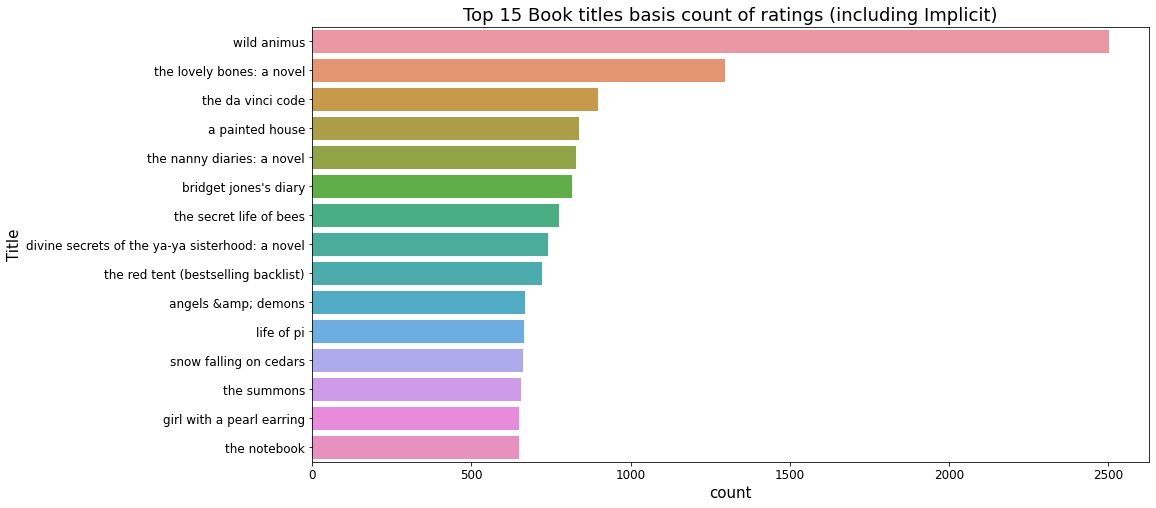

In [576]:
# Top 15 Book Titles basis highest count of ratings (Implicit Included)
plt.figure(figsize=(15,8))
sns.countplot(y="Title", data=dataset, order=dataset['Title'].value_counts().index[0:15])
plt.title("Top 15 Book titles basis count of ratings (including Implicit)")

Text(0.5, 1.0, 'Top 15 Book titles basis count of ratings (Only Explicit)')

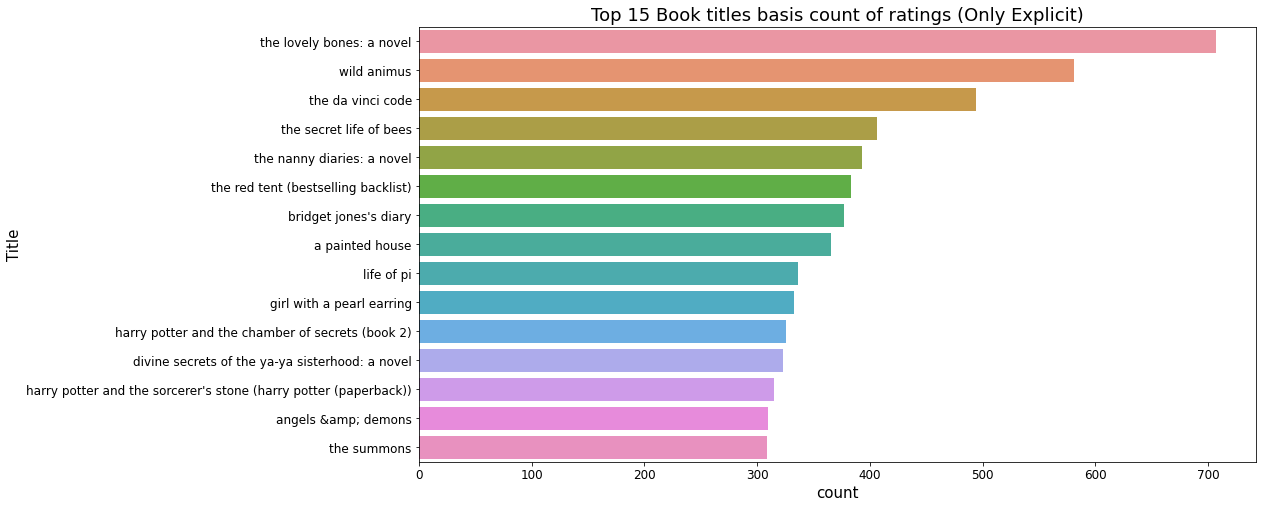

In [577]:
# Top 15 Book Titles basis highest count of ratings (Only Explicit)
plt.figure(figsize=(15,8))
sns.countplot(y="Title", data=exp_data, order=exp_data['Title'].value_counts().index[0:15])
plt.title("Top 15 Book titles basis count of ratings (Only Explicit)")

### **C. Authors and their Number of Ratings**

Text(0.5, 1.0, 'Top 15 Book Authors basis count of ratings (including Implicit)')

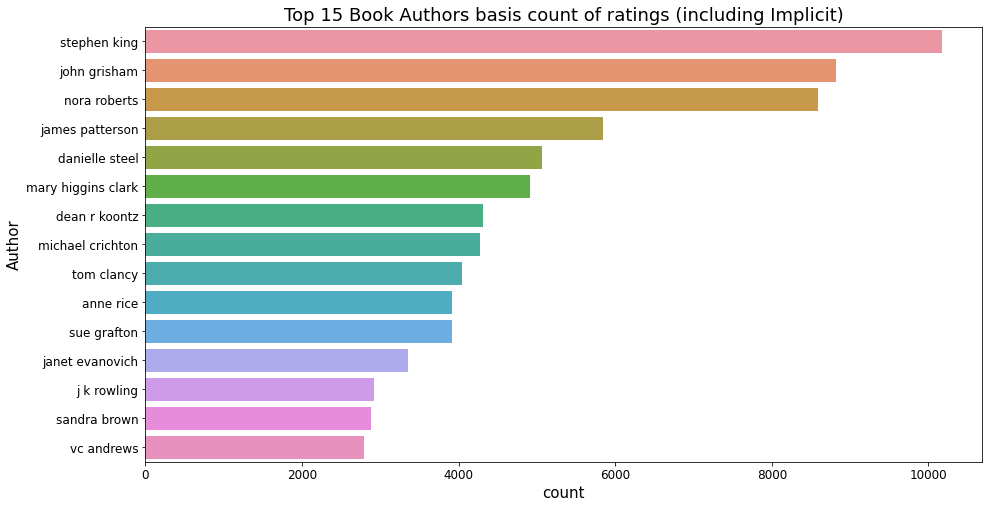

In [578]:
# Top 15 Book Authors basis highest count of ratings (Implicit Included)
plt.figure(figsize=(15,8))
sns.countplot(y="Author", data=dataset, order=dataset['Author'].value_counts().index[0:15])
plt.title("Top 15 Book Authors basis count of ratings (including Implicit)")

Text(0.5, 1.0, 'Top 15 Book Author basis count of ratings (Only Explicit)')

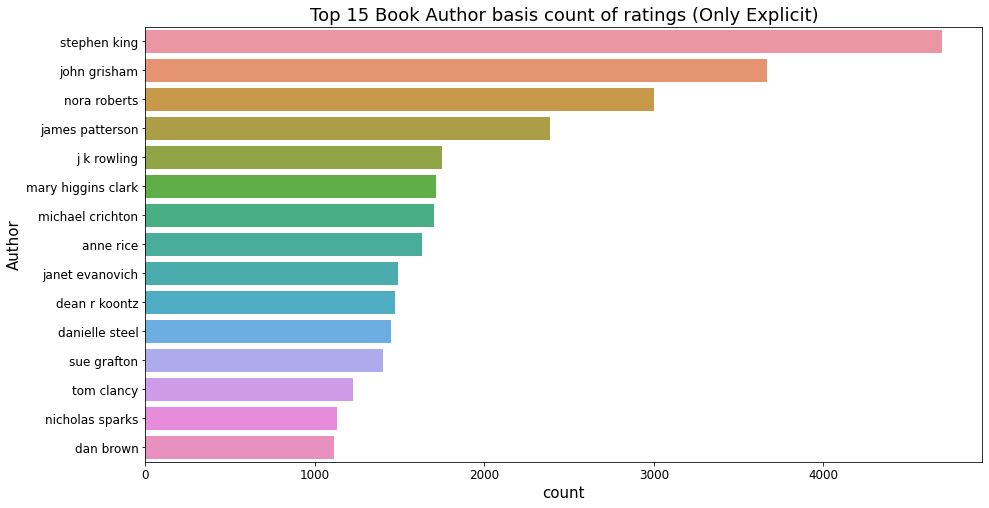

In [579]:
# Top 15 Book Author basis highest count of ratings (Only Explicit)
plt.figure(figsize=(15,8))
sns.countplot(y="Author", data=exp_data, order=exp_data['Author'].value_counts().index[0:15])
plt.title("Top 15 Book Author basis count of ratings (Only Explicit)")

In [580]:
# Creating a dataframe with author-wise count of ratings
auth_df = exp_data['Author'].value_counts().index[0:15]
auth_df

Index(['stephen king', 'john grisham', 'nora roberts', 'james patterson',
       'j k rowling', 'mary higgins clark', 'michael crichton', 'anne rice',
       'janet evanovich', 'dean r koontz', 'danielle steel', 'sue grafton',
       'tom clancy', 'nicholas sparks', 'dan brown'],
      dtype='object')

In [581]:
# Getting a dataframe with author-wise average ratings
auth_rating = exp_data.groupby('Author')['Rating_mean'].mean().sort_values(ascending=False).reset_index()
auth_rating.rename(columns={'Rating_mean':'Avg_rating'}, inplace = True)
auth_rating.sort_values(by='Avg_rating', ascending=False, inplace=True)
auth_rating.head()

Author  Avg_rating
0        ecobham brewer        10.0
3892         roy marsaw        10.0
3890  christian f feest        10.0
3889     richard hodges        10.0
3888     galway kinnell        10.0

In [582]:
# Getting average ratings of all top-15 authors with highest count of ratings
authors =[]
avg_rating =[]
for author in auth_df:
 authors.append(author)
 avg_rating.append(round(float(auth_rating[auth_rating.Author == author]['Avg_rating']),2))

# Storing results in dictionary 
dict_auth = {}
dict_auth['Author'] = authors
dict_auth['Avg_rating'] = avg_rating

# creating a dataframe
top_authors1 = pd.DataFrame.from_dict(dict_auth)

In [583]:
# Checking average ratiings of Top-15 authors with highest count of ratings
top_authors1

Author  Avg_rating
0         stephen king        3.84
1         john grisham        3.26
2         nora roberts        2.88
3      james patterson        3.26
4          j k rowling        5.48
5   mary higgins clark        2.94
6     michael crichton        3.14
7            anne rice        3.29
8      janet evanovich        3.63
9        dean r koontz        2.72
10      danielle steel        2.36
11         sue grafton        2.90
12          tom clancy        2.54
13     nicholas sparks        3.39
14           dan brown        4.11

Text(0, 0.5, 'Average ratings')

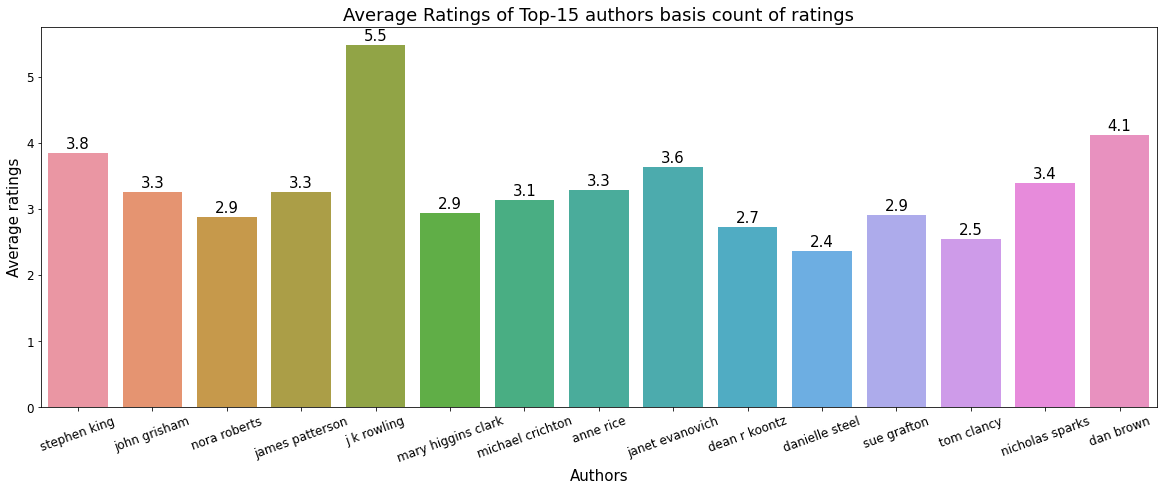

In [584]:
# Plotting Average ratings given by "Top-15 authors basis count of ratings"
plt.figure(figsize=(20,7))
ax1 = sns.barplot(x='Author', y='Avg_rating', data = top_authors1)
annot(ax1)
plt.xticks(rotation=20)
plt.title("Average Ratings of Top-15 authors basis count of ratings")
plt.xlabel("Authors")
plt.ylabel("Average ratings")

**Observations**:
1. Among Top-15 Authors basis highest count of ratings, J.K.Rowling has the highest average rating of 5.5 and Danielle Steel has lowest value of 2.4.

### **D. Publishers and their Number of Ratings**

Text(0.5, 1.0, 'Top 15 Book Publishers basis count of ratings (including Implicit)')

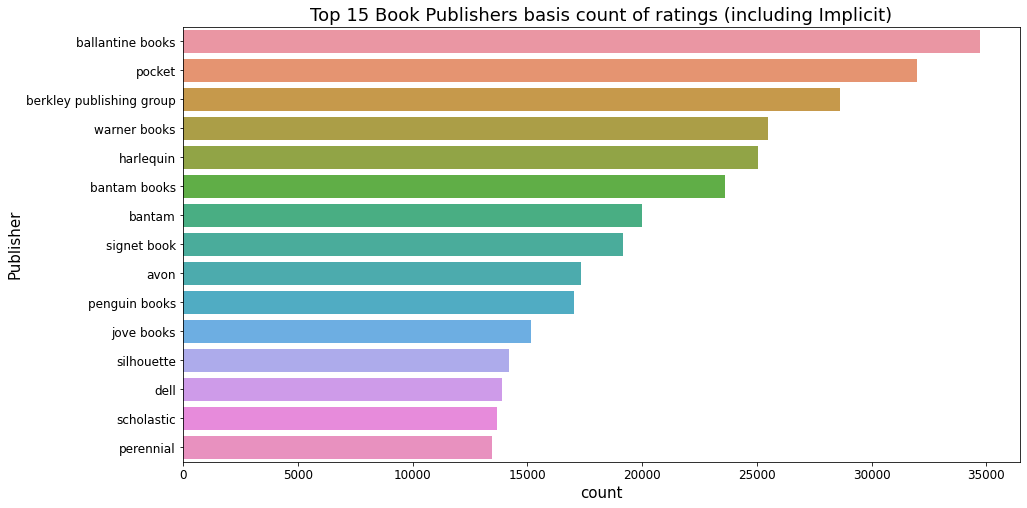

In [585]:
# Top 15 Book Publishers basis highest count of ratings (Implicit Included)
plt.figure(figsize=(15,8))
sns.countplot(y="Publisher", data=dataset, order=dataset['Publisher'].value_counts().index[0:15])
plt.title("Top 15 Book Publishers basis count of ratings (including Implicit)")

Text(0.5, 1.0, 'Top 15 Book Publishers basis count of ratings (Only Explicit)')

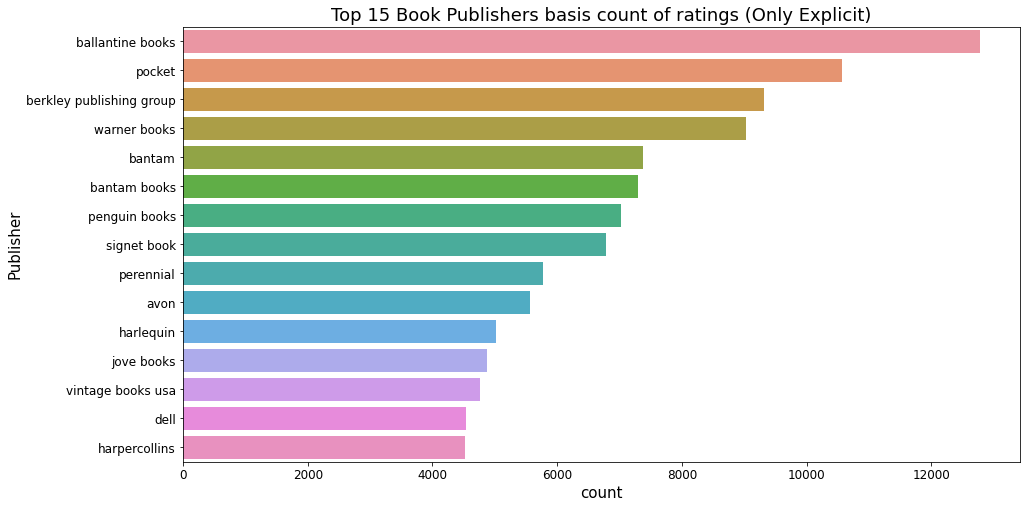

In [586]:
# Top 15 Book Publishers basis highest count of ratings (Only Explicit)
plt.figure(figsize=(15,8))
sns.countplot(y="Publisher", data=exp_data, order=exp_data['Publisher'].value_counts().index[0:15])
plt.title("Top 15 Book Publishers basis count of ratings (Only Explicit)")

### **E. How Ratings varied during Years of Publication?**

In [587]:
# Checking duplicated observations in merged dataset
dataset.duplicated().sum()
# There are no duplicate records
# Means each observation is a book with unique ISBN and rating by unique user

0

In [588]:
# Looking at top 2 observations
dataset.head(2)

ISBN                Title                Author  Published_year  \
0  0195153448  classical mythology      mark p o morford            2002   
1  0002005018         clara callan  richard bruce wright            2001   

                 Publisher                                        Title_by_of  \
0  oxford university press  classical mythology_by_mark p o morford_of_oxf...   
1    harperflamingo canada  clara callan_by_richard bruce wright_of_harper...   

   User_ID  Book_rating                   Location  Age country age_group  \
0        2            0  stockton, california, usa   18     usa  teenager   
1        8            5   timmins, ontario, canada   32  canada     youth   

   Rating_count  Rating_mean  
0             1         0.00  
1            14         4.93

Text(0.5, 1.0, 'Top 15 years of Publications basis highest count of ratings (including Implicit)')

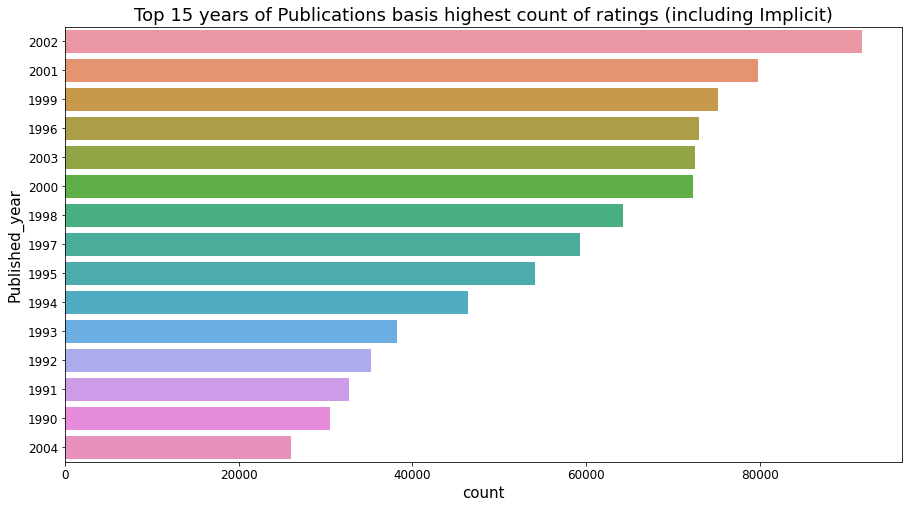

In [589]:
# Top 15 years of Publications basis highest count of ratings (Implicit Included)
# Books pubished in what years are mostly rated by readers??
plt.figure(figsize=(15,8))
sns.countplot(y="Published_year", data=dataset, order=dataset['Published_year'].value_counts().index[0:15])
plt.title("Top 15 years of Publications basis highest count of ratings (including Implicit)")

Text(0.5, 1.0, 'Top 15 years of Publications basis highest count of ratings (Only Explicit)')

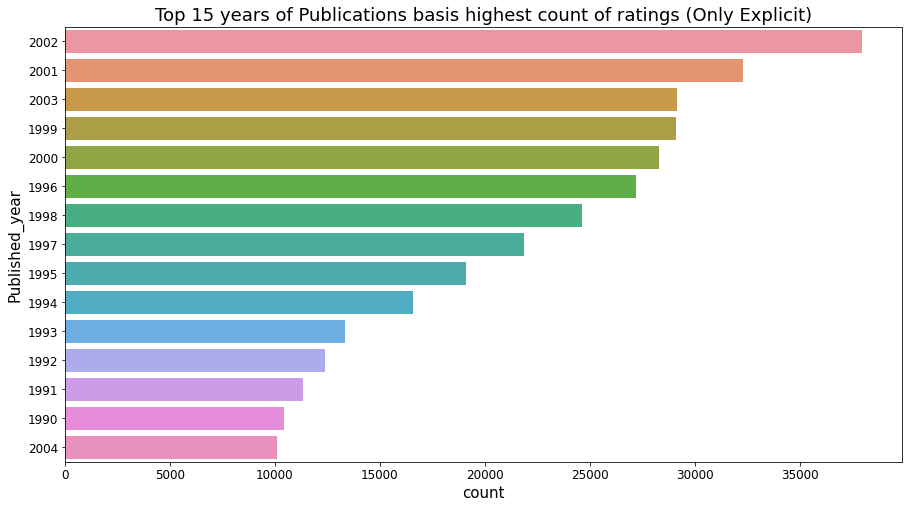

In [590]:
# Top 15 years of Publications basis highest count of ratings (Only Explicit)
plt.figure(figsize=(15,8))
sns.countplot(y="Published_year", data=exp_data, order=exp_data['Published_year'].value_counts().index[0:15])
plt.title("Top 15 years of Publications basis highest count of ratings (Only Explicit)")

In [591]:
# Average ratings given by readers for books published in different years
year_rating = exp_data.groupby('Published_year')['Rating_mean'].mean().sort_values(ascending=False).reset_index()
year_rating.rename(columns={'Rating_mean':'Avg_rating'}, inplace = True)
year_rating.sort_values(by='Avg_rating', ascending=False, inplace=True)
year_rating = year_rating[:15]

In [592]:
year_rating

Published_year  Avg_rating
0             1378   10.000000
2             1908   10.000000
1             1904   10.000000
3             1901    8.000000
4             1924    8.000000
5             1944    7.500000
6             1938    7.483636
7             1939    6.666667
8             1948    6.619167
9             1949    6.334615
10            1936    6.252000
12            1941    6.000000
11            1931    6.000000
13            1952    5.974286
14            1971    5.636230

Text(0, 0.5, 'Average ratings by readers')

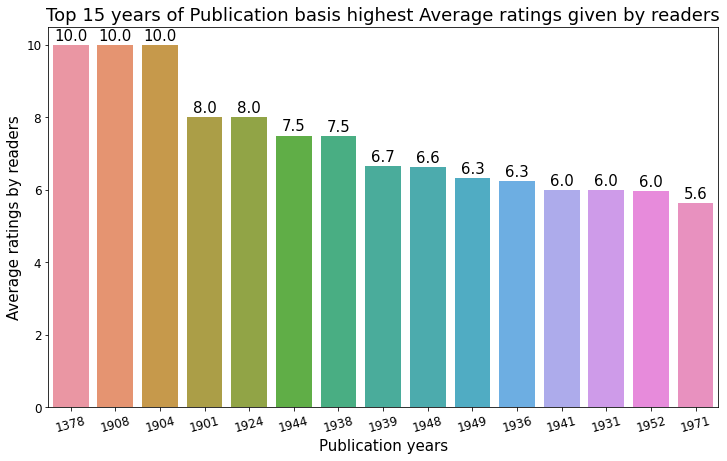

In [593]:
# Plotting Top 15 years of Publication basis highest Average ratings given by readers
plt.figure(figsize=(12,7))
ax1 = sns.barplot(x='Published_year', y='Avg_rating', data = year_rating, order=year_rating['Published_year'].value_counts().index[0:15])
annot(ax1)
plt.xticks(rotation=15)
plt.title("Top 15 years of Publication basis highest Average ratings given by readers")
plt.xlabel("Publication years")
plt.ylabel("Average ratings by readers")

### **F. Reader's Age/age-groups Vs their Number of Ratings**

Text(0.5, 1.0, 'Age groups of readers basis count of ratings (including Implicit)')

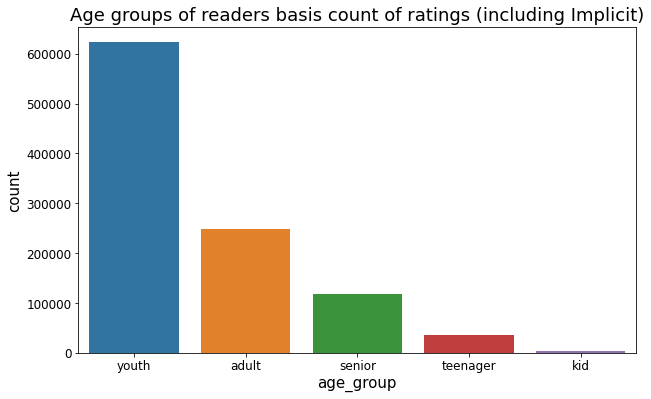

In [594]:
# Age groups of readers basis highest count of ratings (Implicit Included)
plt.figure(figsize=(10,6))
sns.countplot(x="age_group", data=dataset, order=dataset['age_group'].value_counts().index[:])
plt.title("Age groups of readers basis count of ratings (including Implicit)")

Text(0.5, 1.0, 'Age groups of readers basis count of ratings (Only Explicit)')

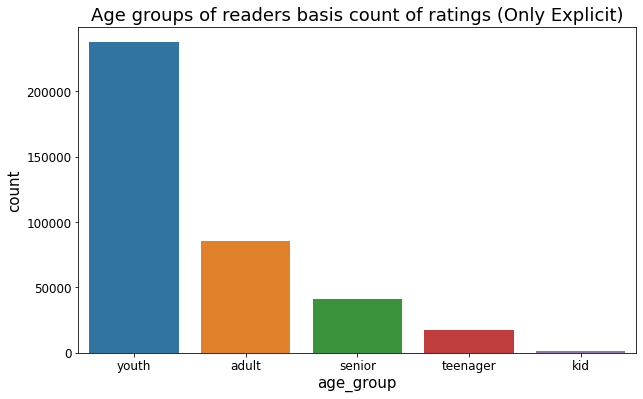

In [595]:
# Age groups of readers basis highest count of ratings (Only Explicit)
plt.figure(figsize=(10,6))
sns.countplot(x="age_group", data=exp_data, order=exp_data['age_group'].value_counts().index[0:15])
plt.title("Age groups of readers basis count of ratings (Only Explicit)")

In [596]:
# Average ratings given by readers of different Age groups
age_rating = exp_data.groupby('age_group')['Rating_mean'].mean().sort_values(ascending=False).reset_index()
age_rating.rename(columns={'Rating_mean':'Avg_rating'}, inplace = True)
age_rating.sort_values(by='Avg_rating', ascending=False, inplace=True)
age_rating

age_group  Avg_rating
0       kid    4.760931
1    senior    4.461224
2  teenager    4.386450
3     adult    4.328153
4     youth    4.186184

Text(0, 0.5, 'Average ratings by readers')

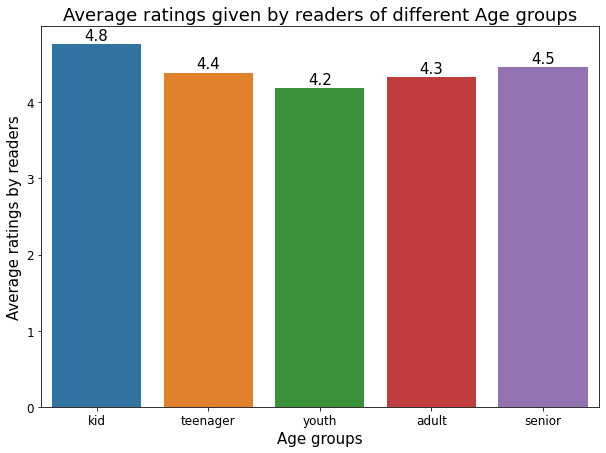

In [597]:
# Plotting Average ratings given by readers of different Age groups
plt.figure(figsize=(10,7))
ax1 = sns.barplot(x='age_group', y='Avg_rating', data = age_rating)
annot(ax1)
plt.xticks(rotation=0)
plt.title("Average ratings given by readers of different Age groups")
plt.xlabel("Age groups")
plt.ylabel("Average ratings by readers")

**Observations**:
1. Youth readers have highest count of ratings, while kids have lowest count of ratings.
2. Average rating by a kid reader is highest (4.8), while that of a youth reader is the lowest (4.2).

### **G. Reader's Country and their Ratings**

Text(0.5, 1.0, 'Countries basis count of ratings (including Implicit)')

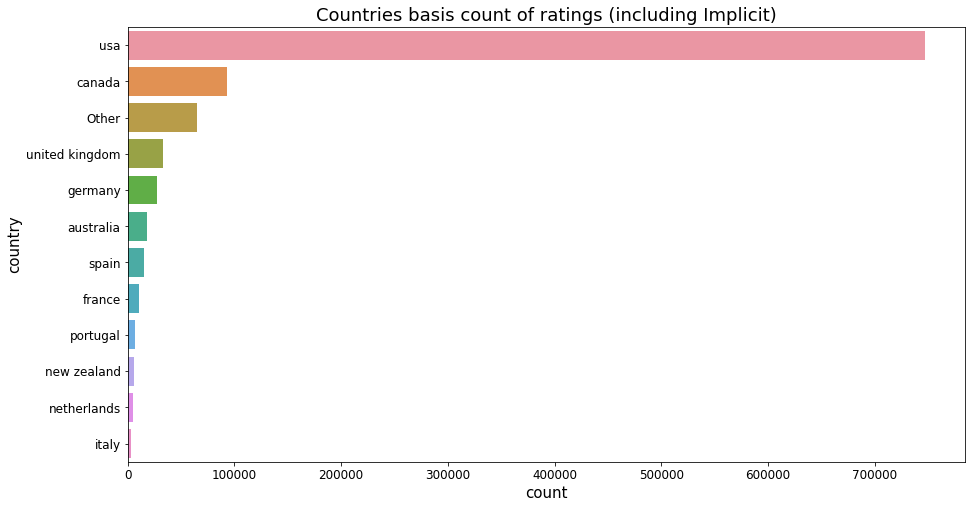

In [598]:
# Countries basis highest count of ratings (Implicit Included)
plt.figure(figsize=(15,8))
sns.countplot(y="country", data=dataset, order=dataset['country'].value_counts().index[0:15])
plt.title("Countries basis count of ratings (including Implicit)")

Text(0.5, 1.0, 'Countries basis count of ratings (Only Explicit)')

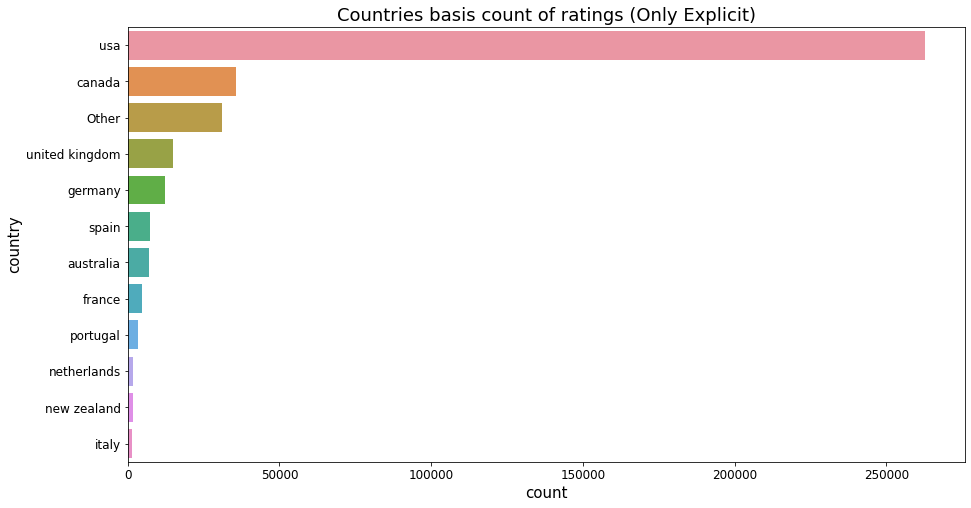

In [599]:
# Countries basis highest count of ratings (Only Explicit)
plt.figure(figsize=(15,8))
sns.countplot(y="country", data=exp_data, order=exp_data['country'].value_counts().index[0:15])
plt.title("Countries basis count of ratings (Only Explicit)")

In [600]:
# Average ratings given by readers of different Countries
loc_rating = exp_data.groupby('country')['Rating_mean'].mean().sort_values(ascending=False).reset_index()
loc_rating.rename(columns={'Rating_mean':'Avg_rating'}, inplace = True)
loc_rating.sort_values(by='Avg_rating', ascending=False, inplace=True)
loc_rating

country  Avg_rating
0            spain    5.335811
1           france    5.267947
2   united kingdom    5.087667
3          germany    4.847233
4         portugal    4.804697
5            italy    4.686485
6        australia    4.685942
7      new zealand    4.564773
8      netherlands    4.250296
9            Other    4.206713
10          canada    4.164634
11             usa    4.132977

In [601]:
# Plotting Average ratings given by readers of different Countries
plt.figure(figsize=(18,10))
ax1 = sns.barplot(x='country', y='Avg_rating', data = loc_rating)
annot(ax1)
plt.xticks(rotation=15)
plt.title("Average ratings given by readers of different Countries")
plt.xlabel("Countries")
plt.ylabel("Average ratings by readers")

Text(0, 0.5, 'Average ratings by readers')

**Observations**:
1. Majority of ratings are from readers of USA (~50%).
2. Average rating by readers of spain and France is the highest (5.3), while that of USA is the lowest (4.1).

## **3(B) Multi-variate Analysis**

### **1. Ratings basis age and country of Readers**

In [602]:
# How number of ratings varies basis age and country of readers
# Countries-Age of Readers basis highest count of ratings (Implicit Included)
plt.figure(figsize=(20,8))
sns.countplot(x="country", hue='age_group', data=dataset, order=dataset['country'].value_counts().index[:])
plt.xticks(rotation=15)
plt.title("Count of ratings basis Reader's Country-Age (including Implicit)")

Text(0.5, 1.0, "Count of ratings basis Reader's Country-Age (including Implicit)")

Text(0.5, 1.0, "Count of ratings basis Reader's Country-Age (Only Explicit)")

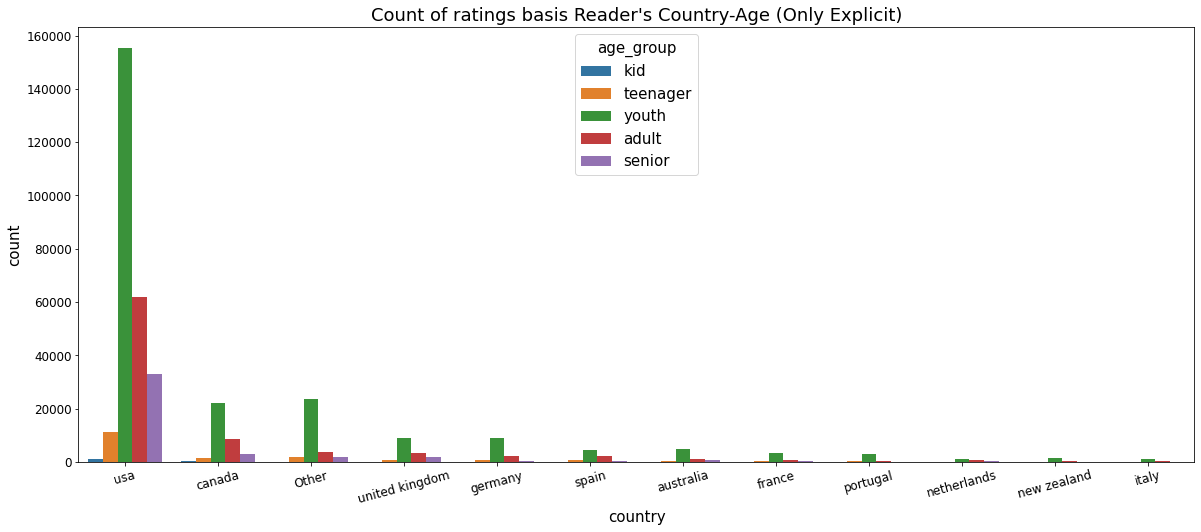

In [603]:
# How number of explicit ratings varies basis age and country of readers
# Countries-Age of Readers basis highest count of ratings (Only Explicit)
plt.figure(figsize=(20,8))
sns.countplot(x="country", hue='age_group', data=exp_data, order=exp_data['country'].value_counts().index[:])
plt.xticks(rotation=15)
plt.title("Count of ratings basis Reader's Country-Age (Only Explicit)")

## **Storing the merged dataset as csv file for next stage**

In [604]:
dataset = dataset.to_csv('/content/drive/MyDrive/Book Recommendation - Kumari Rashmi/Problem Info & Data/dataset.csv')

# **Part B. Building Recommender System**

**Approach Taken:**

1. **Home-Page Recommendations**: 
* These recommendations will be displayed to our readers on the home page. Now this has been further sub-divided into 3 parts:-
  1. **New User** (Cold-Start Problem: we know nothing about this new user):
    * For completely new users, we have built Global recommendations based on Popularity (basis threshold of minimum ratings)  and score based on rating (will use IMDB weighted-ratings method).
  2. **Users with Demographics data only** (i.e, Users who have logged in for the first time and have given information about their age and location only)
    * For such users, we have built age-based and country-based popularity recommendations.
  3. **Active Users** (Users who are registered and whose "Ratings-history" is available with us): 
    * For such users with available ratings history data, we have built collaborative, content-based and hybrid recommendations.

2. **After-Selecting a Book Recommendations**: Once a user has clicked a particular book, Let's show him further recommendations on that second-page also. These second-page recommendations will be as follows:
  1. Books with similar Titles
  2. Top-N Popular books by same author
  3. Books with similar ratings

**Note:**
1. For arriving at Popular books basis highest count of ratings, i have decided to use both explicit and implicit ratings. Reason being implicit ratings indicate that the reader was curious about a given book and therefore had either viewed or purchased it. So, here **Popularity indicates how much curiosity surrounds a particular book?**
2. For arriving at Popular books basis highest weighted-average ratings, i have decided to use only data with explicit ratings (makes more senes).
3. Similarly for rest of recommendations using users' ratings history, i have considered data of explictit ratings only.
4. ISBN is unique for each new edition of a given book. In order to not have duplicate recommendations of same book basis different editions or languages, i have decided to go with recommendations basis unique Title-Author-Publisher details.

## Step 1. Getting a smaller subset of potential candidates for Recommender system

In [605]:
# Loading merged dataset as processed in earlier stage
data = pd.read_csv('/content/drive/MyDrive/Book Recommendation - Kumari Rashmi/Problem Info & Data/dataset.csv', index_col=0)
data.head(2)

ISBN                Title                Author  Published_year  \
0  0195153448  classical mythology      mark p o morford            2002   
1  0002005018         clara callan  richard bruce wright            2001   

                 Publisher                                        Title_by_of  \
0  oxford university press  classical mythology_by_mark p o morford_of_oxf...   
1    harperflamingo canada  clara callan_by_richard bruce wright_of_harper...   

   User_ID  Book_rating                   Location  Age country age_group  \
0        2            0  stockton, california, usa   18     usa  teenager   
1        8            5   timmins, ontario, canada   32  canada     youth   

   Rating_count  Rating_mean  
0             1         0.00  
1            14         4.93

In [606]:
# Basic information about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   ISBN            1031136 non-null  object 
 1   Title           1031136 non-null  object 
 2   Author          1031136 non-null  object 
 3   Published_year  1031136 non-null  int64  
 4   Publisher       1031136 non-null  object 
 5   Title_by_of     1031136 non-null  object 
 6   User_ID         1031136 non-null  int64  
 7   Book_rating     1031136 non-null  int64  
 8   Location        1031136 non-null  object 
 9   Age             1031136 non-null  int64  
 10  country         1031136 non-null  object 
 11  age_group       1031136 non-null  object 
 12  Rating_count    1031136 non-null  int64  
 13  Rating_mean     1031136 non-null  float64
dtypes: float64(1), int64(5), object(8)
memory usage: 118.0+ MB


### **A. Selecting Books with minimum number of ratings (Threshold ratings)**

* A book with low count of ratings is not very much reliable. Therefore i have decided to consider only those books that meets the minimum threshold of number of ratings.

In [607]:
# Explicit ratings dataset
exp_data = data[data['Book_rating']!=0]
exp_data.shape

(383842, 14)

In [608]:
# Checking count of ratings per book
thres_df = exp_data.groupby('Title_by_of')['Book_rating'].count().reset_index()
thres_df.rename(columns={'Book_rating':'Count_of_votes'}, inplace=True)
thres_df.head()

Title_by_of  Count_of_votes
0   a light in the storm: the civil war diary of ...               1
1   ask lily (young women of faith: lily series, ...               1
2   dark justice_by_jack higgins_of_putnam publis...               1
3   earth prayers from around the world: 365 pray...               7
4   final fantasy anthology: official strategy gu...               2

In [609]:
# checking statistical parameters of count of ratings per book
thres_df['Count_of_votes'].describe(percentiles=[0,0.25,0.50,0.75,0.90,0.95,0.99,1])

count    147039.000000
mean          2.610477
std           7.807930
min           1.000000
0%            1.000000
25%           1.000000
50%           1.000000
75%           2.000000
90%           4.000000
95%           8.000000
99%          25.000000
100%        707.000000
max         707.000000
Name: Count_of_votes, dtype: float64

In [610]:
# Calculating the minimum votes required to be listed in the top 5%
m = thres_df['Count_of_votes'].quantile(0.95)
m

8.0

**Basis above, we can see that Top-5-percentile of book-titles have more than 8 votes. In view of above, i have decided to take threshold of minimum votes received on a book title to be 8.**

In [611]:
# complete dataset shape
data.shape

(1031136, 14)

In [612]:
# Filtering Complete dataset (Including Implicit Ratings)
# This will be used where recommendations is done without considering the book ratings by readers.
# Considering only those books with titles that have received minimum 8 ratings
both_data = data.copy().loc[data['Rating_count'] >= m]
both_data.shape

(575907, 14)

In [613]:
# Filtering Dataset with Explicit Ratings Only
# This will be used where recommendations is done considering the book ratings by readers.
# Considering only those books with titles that have received minimum 8 ratings
exp_data = exp_data.copy().loc[exp_data['Rating_count'] >= m]
exp_data.shape

(217961, 14)

### **B. Selecting Books basis the worthiness of Users** 
* Rating given by a voracious reader, who has read more books (say atleast 10 books) is more reliable than ratings given by a novice user who has read only 2 books.
* To consider above, i have decided to select users that satisfy the minimum threshold of count of ratings.

In [614]:
# Storing the count of ratings of each User
thres_df2 = exp_data.groupby('User_ID')['Book_rating'].count().reset_index()
thres_df2.rename(columns={'Book_rating':'Count_of_votes'}, inplace=True)
thres_df2.head()

User_ID  Count_of_votes
0        8               1
1        9               1
2       16               1
3       17               4
4       19               1

In [615]:
# Checking statistical parameters of number of votes per user
thres_df2['Count_of_votes'].describe(percentiles=[0,0.25,0.50,0.75,0.80,0.90,0.95,0.99,1])

count    50182.000000
mean         4.343410
std         21.974843
min          1.000000
0%           1.000000
25%          1.000000
50%          1.000000
75%          3.000000
80%          4.000000
90%          8.000000
95%         15.000000
99%         53.000000
100%      3704.000000
max       3704.000000
Name: Count_of_votes, dtype: float64

In [616]:
# Calculating the minimum votes by Users required to be listed in the top 5%
user_min_votes = thres_df2['Count_of_votes'].quantile(0.95)
user_min_votes

15.0

**Basis above, we can see that Top-5-percentile of Users basis their number of ratings is arount 15 votes per user. In view of above, i have decided to consider a reader as reliable, who has given minimum votes of atleast 15.**

In [617]:
thres_df2[thres_df2['Count_of_votes'] >= user_min_votes].shape

(2624, 2)

In [618]:
# complete dataset shape
both_data.shape

(575907, 14)

In [619]:
# Removing the User_ID's who have rated less than 15 books.
both_data= both_data[both_data['User_ID'].isin(thres_df2[thres_df2['Count_of_votes'] >= user_min_votes].User_ID)].reset_index()
both_data.shape

(329199, 15)

In [620]:
both_data.drop(columns='index', inplace=True)
both_data.head(1)

ISBN         Title                Author  Published_year  \
0  0002005018  clara callan  richard bruce wright            2001   

               Publisher                                        Title_by_of  \
0  harperflamingo canada  clara callan_by_richard bruce wright_of_harper...   

   User_ID  Book_rating                 Location  Age country age_group  \
0    11400            0  ottawa, ontario, canada   49  canada     adult   

   Rating_count  Rating_mean  
0            14         4.93

In [621]:
# Statistical parameters of ratings for complete dataset
both_data['Book_rating'].describe()

count    329199.000000
mean          2.622317
std           3.831773
min           0.000000
25%           0.000000
50%           0.000000
75%           7.000000
max          10.000000
Name: Book_rating, dtype: float64

In [622]:
# Dataset with explicit ratings only
# Removing the User_ID's which have rated less than 15 books.
exp_data= exp_data[exp_data['User_ID'].isin(thres_df2[thres_df2['Count_of_votes'] >= user_min_votes].User_ID)].reset_index()
exp_data.shape

(110362, 15)

In [623]:
# Statistical parameters of ratings for explicit dataset
exp_data['Book_rating'].describe()

count    110362.000000
mean          7.822113
std           1.767176
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: Book_rating, dtype: float64

In [624]:
# Storing the count of ratings of each User
thres_df3 = exp_data.groupby('User_ID')['Book_rating'].count().reset_index()
thres_df3.rename(columns={'Book_rating':'Count_of_votes'}, inplace=True)
thres_df3.head(2)

User_ID  Count_of_votes
0      243              16
1      254              39

In [625]:
# Statistical parameters of count of ratings per user
thres_df3['Count_of_votes'].describe()

count    2624.000000
mean       42.058689
std        87.365370
min        15.000000
25%        19.000000
50%        26.500000
75%        44.000000
max      3704.000000
Name: Count_of_votes, dtype: float64

In [628]:
# Checking unique values in each column of explicit dataset
exp_data.nunique()

index             110362
ISBN               21936
Title              18531
Author              6376
Published_year        68
Publisher           1217
Title_by_of        20727
User_ID             2624
Book_rating           10
Location            1664
Age                   72
country               12
age_group              5
Rating_count         342
Rating_mean          674
dtype: int64

## Step 2. Scoring Method: Only for explicit ratings and for Popularity-based recommenders

A standard procedure to make a weighted average between the individual rating and the 'a priori' rating (also called '**bayesian average**') is as :

> 𝑅𝑎   = 𝑊 * 𝑅  +  (1−𝑊) * 𝑅o

where, 
* 𝑅𝑎= averaged ('bayesian') rating
* 𝑅= individual rating: average rating for this item.
* 𝑅o= a priori rating: global average rating, for all items in your database.
* 𝑊= weight factor: it should tend to 0 if this items has few votes, and it should tend to 1 if it has many.

**Scoring Method: Weighted Average Rating using Bayesian average:**

Simply taking average rating per book does not capture the varying importance of **Number of votes**
* It means, if we have book A and B with exactly same average rating but different number of votes, then book with more votes is more reliable and hence wins!!

* In view of the above concerns, we must come up with some scoring metric that can address the above concern (some Bayesian average score). However, to arrive at such perfect metric needs a lot of domain knowledge.

While searching and doing calculations for above such metric, i came across IMDB's weighted rating criteria on the internet, which is as below:-

    𝑊𝑅 = (𝑣𝑅/(𝑣+𝑚))  +  (𝑚𝐶/(𝑣+𝑚))
    
    where:
    1. 𝑅 = average rating for the movie (mean Rating)
    2. 𝑣 = number of votes for the movie
    3. 𝑚 = minimum votes required to be listed in the Top 50 (currently 1000 for IMDB)
    4. 𝐶 = the mean rating across the whole report (currently 6.8 for IMDB)

Upon analyzing the above IMDB scoring criteria, i found it to be in-line with Bayesian average method. Therefore, i have decided to use this score.

* **The logic behind is as**:
> * If a particular book has very few votes (**v**), we can't put much trust on it, and therefore will prefer to go with a more conservative estimate, the "a priori" non-committal rating i.e., average rating for all books.
> * Similarly, when the number of votes (**v**) for a particular book gets bigger, we will trust that individual rating more.

In [629]:
# Let's get mean ratings of all books
C = data['Rating_mean'].mean().round(2)
print(C)

2.84


In [630]:
# IMDB formula for weighted scores
def weighted_rating(x, m=m, C=C):
    v = x['Rating_count']
    R = x['Rating_mean']
    return (v/(v+m) * R) + (m/(m+v) * C)

**Let's get weighted ratings as scores for chosen small subset of explicit ratings dataset (Potential candidates for Books).**

In [631]:
# Creating score feature for all those books with atleast 8 number of ratings
data['score'] = data.apply(weighted_rating, axis=1)
data.head(1)

ISBN                Title            Author  Published_year  \
0  0195153448  classical mythology  mark p o morford            2002   

                 Publisher                                        Title_by_of  \
0  oxford university press  classical mythology_by_mark p o morford_of_oxf...   

   User_ID  Book_rating                   Location  Age country age_group  \
0        2            0  stockton, california, usa   18     usa  teenager   

   Rating_count  Rating_mean     score  
0             1          0.0  2.524444

In [632]:
# Creating score feature for all those books with atleast 8 number of ratings
exp_data['score'] = exp_data.apply(weighted_rating, axis=1)
exp_data.head(1)

index        ISBN         Title                Author  Published_year  \
0      3  0002005018  clara callan  richard bruce wright            2001   

               Publisher                                        Title_by_of  \
0  harperflamingo canada  clara callan_by_richard bruce wright_of_harper...   

   User_ID  Book_rating       Location  Age country age_group  Rating_count  \
0    11676            8  n/a, n/a, n/a   32   Other     youth            14   

   Rating_mean  score  
0         4.93   4.17

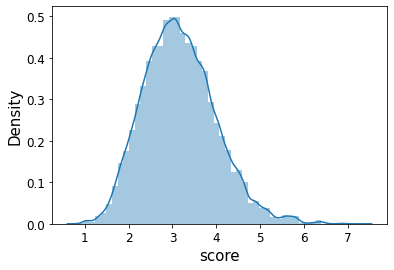

In [633]:
# Density plot of Score (weighted-average-ratings)
sns.distplot(exp_data['score'])

In [635]:
# Statistical parameters of weighted-average ratings for explicit dataset
exp_data['score'].describe()

count    110362.000000
mean          3.163694
std           0.821539
min           0.844118
25%           2.576792
50%           3.110000
75%           3.682564
max           7.299355
Name: score, dtype: float64

In [636]:
# Statistical parameters of weighted-average ratings for complete dataset (implicit included)
data['score'].describe()

count    1.031136e+06
mean     2.867269e+00
std      7.459643e-01
min      7.892308e-01
25%      2.337059e+00
50%      2.781983e+00
75%      3.346667e+00
max      7.299355e+00
Name: score, dtype: float64

## Step 3. Home Page Recommendations for New Users (Popularity-based)

### **A. Global Recommendations: Top "N" Most Popular Books basis count of Ratings/Interactions**

* For these recommendations, i have considered complete interactions dataset (i.e., no filtering based on minimum number of votes per book and minimum votes per reader)
* Interactions can be either explicit or implicit.

In [637]:
# Module function to get top-N books basis count of ratings
def popular_books(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        dataset = pd.DataFrame(dataframe.groupby('Title_by_of')['Book_rating'].count()).sort_values('Book_rating', ascending=False).head(n)
        return dataset
    return "Invalid number of books entered!!"

In [638]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))

Enter number of books to recommend: 10


In [639]:
print("Top", number, "Popular books basis count of ratings (implict included) are: ")
popular_books(data, number)

Top 10 Popular books basis count of ratings (implict included) are: 


Book_rating
Title_by_of                                                    
wild animus_by_rich shapero_of_too far                     2502
the lovely bones: a novel_by_alice sebold_of_li...         1295
the da vinci code_by_dan brown_of_doubleday                 884
divine secrets of the ya-ya sisterhood: a novel...          732
the red tent (bestselling backlist)_by_anita di...          723
a painted house_by_john grisham_of_dell publish...          649
the notebook_by_nicholas sparks_of_warner books             647
snow falling on cedars_by_david guterson_of_vin...          618
the secret life of bees_by_sue monk kidd_of_pen...          615
angels &amp; demons_by_dan brown_of_pocket star             586

In [640]:
print("Top", number, "Popular books basis count of ratings (explicit only) are: ")
popular_books(data[data['Book_rating']!=0], number)

Top 10 Popular books basis count of ratings (explicit only) are: 


Book_rating
Title_by_of                                                    
the lovely bones: a novel_by_alice sebold_of_li...          707
wild animus_by_rich shapero_of_too far                      581
the da vinci code_by_dan brown_of_doubleday                 487
the red tent (bestselling backlist)_by_anita di...          383
harry potter and the chamber of secrets (book 2...          326
divine secrets of the ya-ya sisterhood: a novel...          320
harry potter and the sorcerer's stone (harry po...          315
the secret life of bees_by_sue monk kidd_of_pen...          307
girl with a pearl earring_by_tracy chevalier_of...          299
where the heart is (oprah's book club (paperbac...          295

### **B. Global Recommendations: Top-N Books with highest Average-weighted scores**

In [676]:
# Module function to get top-N popular books basis weighted-average ratings
def top_rated_books(dataframe, n):
    ''' This function takes a dataset and number of recommendations as input,
    and returns list of Top-N popular books basis weighted-average ratings.
    '''
    dataframe.drop_duplicates(subset=['Title','Author','Publisher','score'], keep='first', inplace=True)
    if n >= 1 and n <= len(dataframe):
      dataset = dataframe.groupby('Title_by_of')['score'].mean().to_frame()
      return dataset.sort_values('score', ascending=False).head(n)
    return "Invalid number of books entered!!"

In [642]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))

Enter number of books to recommend: 10


In [643]:
print("Top", number, "Highly rated books basis IMDB's weighted-average score are: ")
top_rated_books(exp_data, number)

Top 10 Highly rated books basis IMDB's weighted-average score are: 


score
Title_by_of                                                 
free_by_paul vincent_of_upfront publishing          7.299355
chobits (chobits)_by_clamp_of_tokyopop              6.884444
el hobbit_by_j r r tolkien_of_minotauro             6.548824
the blue day book: a lesson in cheering yoursel...  6.510526
harry potter and the goblet of fire (book 4)_by...  6.393465
death: the high cost of living_by_neil gaiman_o...  6.334118
the baby book: everything you need to know abou...  6.319048
where the sidewalk ends : poems and drawings_by...  6.284878
there's treasure everywhere--a calvin and hobbe...  6.267200
falling up_by_shel silverstein_of_harpercollins     6.210435

## Step 4. Home Page Recommendations for Users with Demographics data only

* We will have global recommendations as found in Step 3.
* In addition to above, we will also get contextual recommendations, based on Reader's Age group and Country location.

### **A. Books Popular among Readers of your age group basis count of ratings/interactions**

In [644]:
# Module function to get Top-N books basis count of ratings for the age group of selected User
def popular_books(dataframe, n, user_id):
  user_age = list(set(data.loc[data['User_ID']==user_id,'age_group'].values)).pop()
  print("Age group to which reader belongs:", user_age)
  if user_age in list(dataframe['age_group'].unique()):
    # getting all candidates from the age group of given reader only
    data_new = dataframe[dataframe['age_group']== user_age]
    if n >= 1 and n <= len(data_new):
      # Now grouping by Title-author-publisher and getting books with maximum count of Book Ratings
      dataset = pd.DataFrame(data_new.groupby('Title_by_of')['Book_rating'].count()).sort_values('Book_rating', ascending=False).head(n)
      return dataset
    return "Invalid number of books entered!!"
  return "User's age group not found in potential books dataset!!"

In [645]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))
# 4057-youth

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 4057


In [646]:
print("Top", number, "Popular books for user id", reader, "basis count of ratings (Implicit Included) are:")
popular_books(both_data, number, reader)

Top 5 Popular books for user id 4057 basis count of ratings (Implicit Included) are:
Age group to which reader belongs: youth


Book_rating
Title_by_of                                                    
wild animus_by_rich shapero_of_too far                      361
the lovely bones: a novel_by_alice sebold_of_li...          321
the da vinci code_by_dan brown_of_doubleday                 258
divine secrets of the ya-ya sisterhood: a novel...          216
the red tent (bestselling backlist)_by_anita di...          213

In [320]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))
# 269566-kid

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 269566


In [321]:
print("Top", number, "Popular books for user id", reader, "basis count of ratings (Implicit Included) are:")
popular_books(both_data, number, reader)

Top 5 Popular books for user id 269566 basis count of ratings (Implicit Included) are:
Age group to which reader belongs: kid


Book_rating
Title_by_of                                                    
stay out of the basement (goosebumps, no 2)_by_...            2
winnie the pooh and the honey tree (little gold...            2
ella enchanted (trophy newbery)_by_gail carson ...            2
belle prater's boy_by_ruth white_of_yearling                  2
harry potter and the sorcerer's stone (harry po...            2

In [670]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))
# 16916-senior

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 16916


In [671]:
print("Top", number, "Popular books for user id", reader, "basis count of ratings (Implicit Included) are:")
popular_books(both_data, number, reader)

Top 5 Popular books for user id 16916 basis count of ratings (Implicit Included) are:
Age group to which reader belongs: senior


Book_rating
Title_by_of                                                    
wild animus_by_rich shapero_of_too far                       56
the da vinci code_by_dan brown_of_doubleday                  44
the lovely bones: a novel_by_alice sebold_of_li...           42
the notebook_by_nicholas sparks_of_warner books              30
the horse whisperer_by_nicholas evans_of_dell                28

In [ ]:
both_data[both_data['age_group']=='adult']
# 46398 adult

In [672]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))
# 46398-adult

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 46398


In [673]:
print("Top", number, "Popular books for user id", reader, "basis count of ratings (Implicit Included) are:")
popular_books(both_data, number, reader)

Top 5 Popular books for user id 46398 basis count of ratings (Implicit Included) are:
Age group to which reader belongs: adult


Book_rating
Title_by_of                                                    
wild animus_by_rich shapero_of_too far                      157
the lovely bones: a novel_by_alice sebold_of_li...          139
the da vinci code_by_dan brown_of_doubleday                 103
the notebook_by_nicholas sparks_of_warner books              97
divine secrets of the ya-ya sisterhood: a novel...           92

### **B. Top-N Books with highest scores by readers of your Age group**

In [677]:
# Module function to get Top-N books basis weighted-average ratings for the age group of selected User
def top_rated_age(data, dataframe, n, user_id):
  ''' This function takes dataset, number of recommendations and user id as inputs;
  and returns list of Top-N popular books with heightest weighted-average ratings 
  for age group of selected user.
  '''
  user_age = list(set(data.loc[data['User_ID']==user_id,'age_group'].values)).pop()
  print("Age group to which reader belongs:", user_age)
  if user_age in list(dataframe['age_group'].unique()):
    # getting all candidates from the age group of given reader only
    data_new = dataframe[dataframe['age_group']== user_age]
    data_new.drop_duplicates(subset=['Title','Author','Publisher','score'], keep='first', inplace=True)
    if n >= 1 and n <= len(dataframe):
      dataset = data_new.groupby('Title_by_of')['score'].mean().to_frame()
      return dataset.sort_values('score', ascending=False).head(n)
    return "Invalid number of books entered!!"

In [648]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 4057


In [649]:
print("Top", number, "highly rated books basis IMDB's score for age group of user id", reader, "are:")
top_rated_age(data, exp_data, number, reader)

Top 5 highly rated books basis IMDB's score for age group of user id 4057 are:
Age group to which reader belongs: youth


score
Title_by_of                                                 
free_by_paul vincent_of_upfront publishing          7.299355
chobits (chobits)_by_clamp_of_tokyopop              6.884444
the blue day book: a lesson in cheering yoursel...  6.510526
harry potter and the goblet of fire (book 4)_by...  6.393465
death: the high cost of living_by_neil gaiman_o...  6.334118

In [650]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))
# 16916-senior

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 16916


In [651]:
print("Top", number, "highly rated books basis IMDB's score for age group of user id", reader, "are:")
top_rated_age(data, exp_data, number, reader)

Top 5 highly rated books basis IMDB's score for age group of user id 16916 are:
Age group to which reader belongs: senior


score
Title_by_of                                                 
the two towers (the lord of the rings, part 2)_...  5.691707
dark magic_by_christine feehan_of_love spell        5.308400
the return of the king_by_j r r tolkien_of_not ...  4.988800
the hobbit : the enchanting prelude to the lord...  4.949931
fake (fake)_by_sanami matoh_of_tokyopop             4.930000

In [652]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))
# 46398-adult

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 46398


In [653]:
print("Top", number, "highly rated books basis IMDB's score for age group of user id", reader, "are:")
top_rated_age(data, exp_data, number, reader)

Top 5 highly rated books basis IMDB's score for age group of user id 46398 are:
Age group to which reader belongs: adult


score
Title_by_of                                                 
el hobbit_by_j r r tolkien_of_minotauro             6.548824
there's treasure everywhere--a calvin and hobbe...  6.267200
falling up_by_shel silverstein_of_harpercollins     6.210435
the lorax_by_dr seuss_of_random house childrens...  6.038000
a kiss for little bear_by_else holmelund minari...  5.882857

### **C. Books Popular in your country basis count of ratings/interactions**

In [654]:
# Module function to get Top-N books basis count of ratings in the country of selected User
def pop_in_country(dataframe, n, user_id):
  user_country = list(set(data.loc[data['User_ID']==user_id,'country'].values)).pop()
  print("Country to which reader belongs:", user_country)
  if user_country in list(dataframe['country'].unique()):
    # getting all candidates from the age group of given reader only
    data_new = dataframe[dataframe['country']== user_country]
    if n >= 1 and n <= len(data_new):
      # Now grouping by Title-author-publisher and getting books with maximum count of Book Ratings
      dataset = pd.DataFrame(data_new.groupby('Title_by_of')['Book_rating'].count()).sort_values('Book_rating', ascending=False).head(n)
      return dataset
    return "Invalid number of books entered!!"
  return "User's country not found in potential books dataset!!"

In [655]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 4057


In [656]:
print("Top", number, "Popular books in your country (user:", reader, ") basis count of ratings/interactions are:")
pop_in_country(both_data, number, reader)

Top 5 Popular books in your country (user: 4057 ) basis count of ratings/interactions are:
Country to which reader belongs: united kingdom


Book_rating
Title_by_of                                                    
wild animus_by_rich shapero_of_too far                       27
memoirs of a geisha uk_by_arthur golden_of_traf...           24
chocolat_by_joanne harris_of_black swan                      23
bridget jones's diary_by_helen fielding_of_pica...           21
the lovely bones: a novel_by_alice sebold_of_li...           17

In [664]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))
# 46398-adult

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 46398


In [665]:
print("Top", number, "Popular books in your country (user:", reader, ") basis count of ratings/interactions are:")
pop_in_country(both_data, number, reader)

Top 5 Popular books in your country (user: 46398 ) basis count of ratings/interactions are:
Country to which reader belongs: usa


Book_rating
Title_by_of                                                    
wild animus_by_rich shapero_of_too far                      418
the lovely bones: a novel_by_alice sebold_of_li...          387
the da vinci code_by_dan brown_of_doubleday                 334
divine secrets of the ya-ya sisterhood: a novel...          286
the notebook_by_nicholas sparks_of_warner books             277

In [666]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))
# 32721-france

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 32721


In [667]:
print("Top", number, "Popular books in your country (user:", reader, ") basis count of ratings/interactions are:")
pop_in_country(both_data, number, reader)

Top 5 Popular books in your country (user: 32721 ) basis count of ratings/interactions are:
Country to which reader belongs: france


Book_rating
Title_by_of                                                    
la cantatrice chauve: anti-piece / la lecon: dr...            7
ceux qui vont mourir te saluent_by_fred vargas_...            7
haute fidã?â©litã?â©_by_nick hornby_of_editions...            6
antigone (french language edition)_by_jean anou...            5
petit traitã?â© de toutes vã?â©ritã?â©s sur l'e...            5

In [668]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))
# 74833 - germany

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 74833


In [669]:
print("Top", number, "Popular books in your (user:", reader, ") country basis count of ratings/interactions are:")
pop_in_country(both_data, number, reader)

Top 5 Popular books in your (user: 74833 ) country basis count of ratings/interactions are:
Country to which reader belongs: germany


Book_rating
Title_by_of                                                    
wild animus_by_rich shapero_of_too far                       14
die pã?â¤pstin._by_donna woolfolk cross_of_aufb...            7
das parfum: die geschichte eines morders_by_pat...            7
gottes werk und teufels beitrag_by_john irving_...            6
sick puppy_by_carl hiaasen_of_warner vision                   6

### **D. Top-N Books with highest scores by readers of your country**

In [678]:
# Module function to get Top-N books basis weighted-average ratings in the country of selected User
def top_rated_country(dataframe, n, user_id):
  ''' This function takes dataset, number of recommendations and user id as inputs,
  and returns Top-N popular books with highest weighted-average ratings in the country of selected user.
  '''
  user_country = list(set(data.loc[data['User_ID']==user_id,'country'].values)).pop()
  print("Country to which reader belongs:", user_country)
  if user_country in list(dataframe['country'].unique()):
    # getting all candidates from the age group of given reader only
    data_new = dataframe[dataframe['country']== user_country]
    data_new.drop_duplicates(subset=['Title','Author','Publisher','score'], keep='first', inplace=True)
    if n >= 1 and n <= len(dataframe):
      dataset = data_new.groupby('Title_by_of')['score'].mean().to_frame()
      return dataset.sort_values('score', ascending=False).head(n)
    return "Invalid number of books entered!!"

In [658]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 4057


In [659]:
print("Top", number, "Highly rated books in country of user id", reader, "basis weighted-average-ratings are:")
top_rated_country(exp_data, number, reader)

Top 5 Highly rated books in country of user id 4057 basis weighted-average-ratings are:
Country to which reader belongs: united kingdom


score
Title_by_of                                                 
dave gorman's googlewhack adventure_by_dave gor...  5.170000
brat farrar_by_josephine tey_of_touchstone          4.934000
losing my virginity: the autobiography_by_richa...  4.928889
swimmer_by_bill broady_of_trafalgar square          4.873333
to the edge of the sky_by_anhua gao_of_penguin ...  4.838000

In [660]:
# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))
# 74833 - germany

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 74833


In [661]:
print("Top", number, "Highly rated books in country of user id", reader, "basis weighted-average-ratings are:")
top_rated_country(exp_data, number, reader)

Top 5 Highly rated books in country of user id 74833 basis weighted-average-ratings are:
Country to which reader belongs: germany


score
Title_by_of                                                 
der kleine hobbit_by_j r r tolkien_of_distribooks   6.074783
harry potter und der feuerkelch_by_joanne k row...  5.936000
the chronicles of narnia boxed set_by_c s lewis...  5.630000
mittsommermord. roman._by_henning mankell_of_dtv    5.546400
harry potter und die kammer des schreckens_by_j...  5.376957

In [662]:
11# Let's make it interactive
# Lets get desired value of N from user
number = int(input("Enter number of books to recommend: "))
# Lets have the user id for the given reader
reader = int(input("Enter user id to whom books to be recommended: "))
# 16916 - USA

Enter number of books to recommend: 5
Enter user id to whom books to be recommended: 16916


In [663]:
print("Top", number, "Highly rated books in country of user id", reader, "basis weighted-average-ratings are:")
top_rated_country(exp_data, number, reader)

Top 5 Highly rated books in country of user id 16916 basis weighted-average-ratings are:
Country to which reader belongs: usa


score
Title_by_of                                                 
chobits (chobits)_by_clamp_of_tokyopop              6.884444
death: the high cost of living_by_neil gaiman_o...  6.334118
the baby book: everything you need to know abou...  6.319048
there's treasure everywhere--a calvin and hobbe...  6.267200
falling up_by_shel silverstein_of_harpercollins     6.210435

## Step 5. Home Page Recommendations: Users with demographics data and past rating history data

### **Strategy and approaches:**

To get recommendaions for those users, who have shared their demographics data as well as their history of rated books, followings were used:

1. Memory-based approach using KNN (User-based i.e., Similarity among readers basis books read by them) - Collaborative Filtering
2. Memory-based approach using KNN (Item-based i.e., Similarity among books basis ratings by all readers) - Collaborative Filtering
3. Model Based approach using SVD (User-Item Matrix) - Collaborative Filtering
4. Content Based Filtering
5. Hybrid of collaborative and content based filterings

**Collaborative Filtering**: 
* This method approaches to build a model from  user's past behaviour as well as Similar decisions made by other users.
* It is based on following asssumption:
  * "If a person A has the same opinion as a person B on a set of items, then A is more likely to have B's opinion for a new item than that of a randomly chosen person".
* Its like asking friends for recommendations.
* It generates recommendations by locating peer users/items ith a rating history, similar to the current user/item.


**There are 2 ways to implement collaborative approach**:

**A. Memory-based approach**: In this approach, the recommendation engine learns/memorises all user-item interactions, i.e., what all users like or don't like or how they rated different items, and based on this memory, the engine recommends most-suited items to a user. Similar users or items are identified using basic arithmetic operations such as cosine similarity, pearson's coefficients etc, or using non-parametric algorithms such as KNN. This can be done in 2 ways:
  1. **User-based (UB-CF) approach**: 
  * It uses the logic that "**Similar people will have similar taste**". 
  * It recommends items by first finding N-similar users to the current user and then calculating weighted-average ratings for books that are not read by current user yet. 
  * Once the system has predicted ratings for all books not read by current users, it will then rank order these basis weighted-average ratings and then recommends Top-N books to current user.
  2. **Item-based (IB-CF) approach**: 
  * It is based on assumption that "**A user gives similar ratings to similar items**". 
  * It looks for the items the user has not consumed yet & then finds other items similar to these. Similarity between items is calculated by considering ratings given by all users. 
  * After getting similar items to each non-consumed item, we then compute the rating prediction on a non-consumed item **i** for a user **u**, by computing the weighted-average of the ratings given by the current user on all items (j) similar to i. 
  * Each rating is weighted by the corresponding similarity s(i,j). And final weighted sum is divided by the sum of similarity to get normalized prediction value. 
  

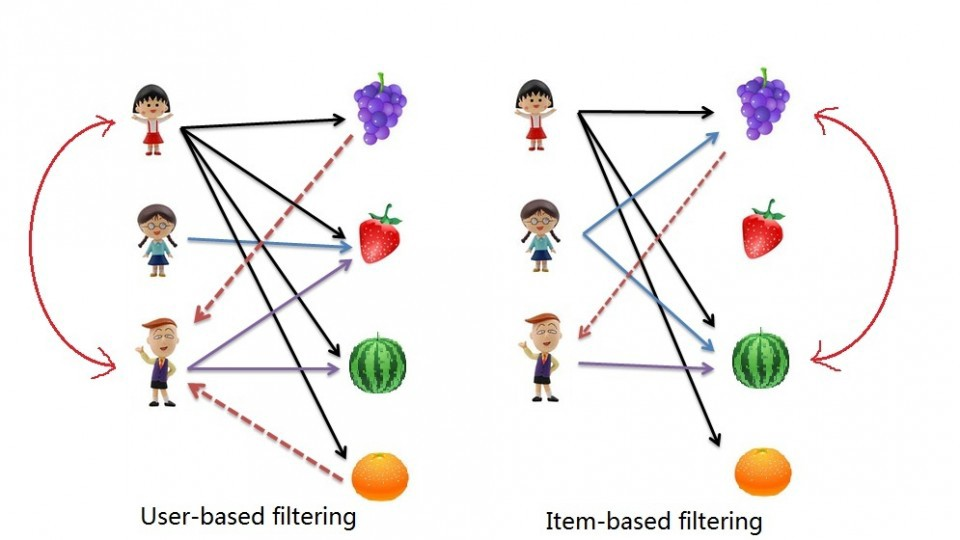

**Problems with Memory-based Collaborative filtering:**
  1. Since the engine has to remember each and every interaction, Scalability is an issue.
  2. It suffers with data sparsity problem. 
  3. As the number of users and items grow, it becomes computationally inefficient. 

### **1. Memory-based approach using KNN (User-based i.e., Similarity among readers basis books read by them)**

**Steps Taken:**
1. Started with reduced smaller subset of potential books (explicit ratings only).
2. Created a user-item matrix (pivot table) with users as rows (user_id as index), book titles as columns and ratings as values.
3. Converted above sparse matrix to a condensed matrix.
4. Built a KNN model using Cosine distances to identify similar users (nearest neighbors approach)
5. Using above KNN-model, extracted a list of similar users and a dictionary containg user id of similar users as keys and respective cosine similarity score as values.
6. To arrive at recommendations, i used 2 logics separately:
    1. **Naive logic**: For a given user, get the top-rated books by 5-most similar users, rank them basis average ratings and recommend top-N books out of this ranked list of books.
    2. **Weighted-average ratings of similar users**: For a given user, after getting similar users, i took weighted average ratings basis similarity-distances, rank ordered them basis weighted-average scores and recommended top-N books from this ranked list of books.

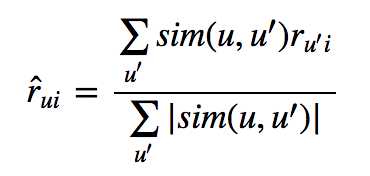

In [ ]:
# Grouping by unique user_Book interactions
new_data = exp_data.groupby(['User_ID','Title_by_of'])['Book_rating'].mean().reset_index()
new_data.head(1)

User_ID                                        Title_by_of  Book_rating
0      243  a map of the world_by_jane hamilton_of_anchor ...          7.0

In [ ]:
# creating a copy of above
data_knn = new_data.copy()
data_knn.head(5)

User_ID                                        Title_by_of  Book_rating
0      243  a map of the world_by_jane hamilton_of_anchor ...          7.0
1      243     a monk swimming_by_malachy mccourt_of_hyperion          5.0
2      243  a painted house_by_john grisham_of_dell publis...          7.0
3      243  chicken soup for the soul (chicken soup for th...          5.0
4      243  legacy of silence_by_belva plain_of_bantam del...          6.0

In [ ]:
# checking shape of above dataset
data_knn.shape

(110213, 3)

In [ ]:
# checking unique values in columns of above dataset
data_knn.nunique()

User_ID         2624
Title_by_of    20727
Book_rating       20
dtype: int64

In [ ]:
# Getting column names
data_knn.columns

Index(['User_ID', 'Title_by_of', 'Book_rating'], dtype='object')

In [ ]:
# Building the User-Item matrix dataframe for the KNN Model
knn_users = pd.pivot_table(data=data_knn, index='User_ID', columns='Title_by_of', values='Book_rating').fillna(0).reset_index()
knn_users.shape

(2624, 20728)

In [ ]:
# Setting user id as index for above user-item matrix
knn_users.index = knn_users["User_ID"]
knn_users.index

Int64Index([   243,    254,    507,    638,    805,    882,   1131,   1211,
              1424,   1435,
            ...
            277639, 277965, 278026, 278137, 278188, 278194, 278202, 278418,
            278582, 278633],
           dtype='int64', name='User_ID', length=2624)

In [ ]:
knn_users.head(1)

Title_by_of  User_ID  \
User_ID                
243              243   

Title_by_of   earth prayers from around the world: 365 prayers, poems, and invocations for honoring the earth_by_elizabeth roberts_of_harpersanfrancisco  \
User_ID                                                                                                                                                    
243                                                        0.0                                                                                             

Title_by_of   good wives: image and reality in the lives of women in northern new england, 1650-1750_by_laurel thatcher ulrich_of_vintage books usa  \
User_ID                                                                                                                                               
243                                                        0.0                                                                                        

Title_by_of   goosebumps monster edition 1: welcome to dead house, stay out of the basement, and say cheese and die!_by_r l stine_of_scholastic paperbacks t  \
User_ID                                                                                                                                                        
243                                                        0.0                                                                                                 

Title_by_of   murder of a sleeping beauty (scumble river mysteries (paperback))_by_denise swanson_of_signet book  \
User_ID                                                                                                            
243                                                        0.0                                                     

Title_by_of   q-space (star trek the next generation, book 47)_by_greg cox_of_star trek  \
User_ID                                                                                   
243                                                        0.0                            

Title_by_of   q-zone (star trek the next generation, book 48)_by_greg cox_of_star trek  \
User_ID                                                                                  
243                                                        0.0                           

Title_by_of   this place has no atmosphere (laurel-leaf books)_by_paula danziger_of_random house childrens pub  \
User_ID                                                                                                          
243                                                        0.0                                                   

Title_by_of  !yo!_by_julia alvarez_of_plume books  \
User_ID                                             
243                                           0.0   

Title_by_of  'a hell of a place to lose a cow': an american hitchhiking odyssey_by_tim brookes_of_national geographic  \
User_ID                                                                                                                 
243                                                        0.0                                                          

Title_by_of  'salem's lot_by_stephen king_of_doubleday books  \
User_ID                                                        
243                                                      0.0   

Title_by_of  'salem's lot_by_stephen king_of_signet book  \
User_ID                                                    
243                                                  0.0   

Title_by_of  'the moon by whale light: and other adventures among bats, penguins, crocodilians, and whales_by_diane ackerman_of_vintage books usa  \
User_ID                                                                                                                                             
243                                                        0.0                            

In [ ]:
from scipy.sparse import csr_matrix
# converting the sparse matrix into condensed matrix using scipy.sparse
knn_users_csr = csr_matrix(knn_users.values)

**Why Cosine Similarity??**

* The cosine similarity is a metric used to find the similarity between the items/products irrespective of their size. We calculate the cosine of an angle by measuring between any two vectors in a multidimensional space. 
* Larger the angle, lower cosine value, so less similarity.
* **Similarity is basically cosine(Angle).**
* It is applicable for datasets of a considerable size (i.e., higher dimensions).
* **cosine similarity = 1 - cosine distance**
* "Cosine" Metric in KNN klearn essentially gives cosine distances. To arrive at similarity, we will subtract distance from 1. 

In [ ]:
# Importing NearestNeighbors class
from sklearn.neighbors import NearestNeighbors
# Building a KNN model with Cosine Similarity for calculating the distances
model_knn = NearestNeighbors(metric='cosine', algorithm = 'brute', n_neighbors=5)
# Using 5 neighbors to recommend maximum 5 similar books to a given user, say User_A
model_knn.fit(knn_users_csr)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
number = int(input("Desired number of similar users to explore for recommendations:"))
user = int(input("ID of reader to whom books to be recommended:"))

Desired number of similar users to explore for recommendations:5
ID of reader to whom books to be recommended:243


In [ ]:
# Building User to user recommendation model for the book readers

# Step 1: Getting k-similar users for given User-A
def sim_users(user, n_values=5):
  ''' This function takes user id of reader for whom we have to generate recommendations,
  and it returns the list of k-similar users basis k-nearest neighbours and a dictionry containing user-weise similarity scores.
  Similarity score = 1 - coine distance
  '''
  # getting distances and indices of k-similar users
  distances, indices = model_knn.kneighbors(knn_users.loc[user,:].values.reshape(1, -1), n_neighbors = n_values+1)
  # list to store indices of similar users
  sim_users = []
  # dictionary to store user id as key and respective cosine similarity as value
  # cosine similarity = (1 - cosine distance)
  sim_dict = {}
  for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'The Top {n_values} similar users for Users {user} are shown below:-')
    else:
        print('{0}: {1}, with distance of {2}.'.format(i, knn_users.index[indices.flatten()[i]], distances.flatten()[i]))
        sim_users.append(knn_users.index[indices.flatten()[i]])
        sim_dict[knn_users.index[indices.flatten()[i]]] = (1-distances.flatten()[i])
  return sim_users, sim_dict

In [ ]:
# Getting similar users and dictionary for User 243
sim_user_243, sim_dict_243 = sim_users(user, number)

The Top 5 similar users for Users 243 are shown below:-
1: 1435, with distance of 0.007797271866404332.
2: 8253, with distance of 0.007805531612513961.
3: 6563, with distance of 0.007813526370175294.
4: 8454, with distance of 0.007824240588097608.
5: 10314, with distance of 0.007841836839294403.


In [ ]:
sim_dict_243

{1435: 0.9922027281335957,
 6563: 0.9921864736298247,
 8253: 0.992194468387486,
 8454: 0.9921757594119024,
 10314: 0.9921581631607056}

In [ ]:
# Getting similar users and dictionary for User 1211
sim_user_1211, sim_dict_1211 = sim_users(1211, 5)

The Top 5 similar users for Users 1211 are shown below:-
1: 28865, with distance of 0.0004152593133874838.
2: 53628, with distance of 0.00041528484818054157.
3: 48217, with distance of 0.00041578953622234405.
4: 39646, with distance of 0.00041579949157666274.
5: 53304, with distance of 0.00041589869333058527.


In [ ]:
# Getting similar users and dictionary for User 16916
sim_user_16916, sim_dict_16916 = sim_users(16916, 5)

The Top 5 similar users for Users 16916 are shown below:-
1: 143964, with distance of 3.3708716821179152e-06.
2: 81298, with distance of 3.3817911604394624e-06.
3: 150124, with distance of 3.429410419308887e-06.
4: 177590, with distance of 3.4327117135468654e-06.
5: 174151, with distance of 3.468493226299607e-06.


### Method 1(a): Recommending top-rated books by 5-most similar users to current user

In [683]:
# Step 2: Finding all top n-rated books of each similar user basis highest score value
def top_n_books(sim_user, user, k):
  ''' This function takes list of k similar user to a given user A and,
  returns list of maximum top-k or less rated books after excluding zero-ratings. 
  '''
  books = {}
  # iterating over each similar user
  for user in sim_user:
    # getting column names for top k-rated books
    top_books = knn_users.loc[knn_users['User_ID']==user,:].reset_index(drop=True)
    top_books = top_books.sort_values(0, axis=1, ascending=False).iloc[:, :k]
    # Only considering explicit ratings for recommendations
    for col in top_books.columns[1:]:
      if top_books.loc[0,col] >0:
        books[col] = top_books.loc[0,col]
  return books

In [ ]:
# Total k*N Books by similar users (i.e., Top-N books by each similar user)
top_n_books(sim_user_243, user, number)

{'a tale of two cities_by_charles dickens_of_signet book': 10.0,
 'bastard out of carolina_by_dorothy allison_of_plume books': 10.0,
 'chicken soup for the soul (chicken soup for the soul)_by_jack canfield_of_health communications': 10.0,
 'encore provence_by_peter mayle_of_alfred a knopf': 10.0,
 'jimmy stewart and his poems_by_jimmy stewart_of_random house inc': 10.0,
 'little altars everywhere: a novel_by_rebecca wells_of_perennial': 9.0,
 'lucky man: a memoir_by_michael j fox_of_hyperion': 9.0,
 'never change_by_elizabeth berg_of_atria': 9.0,
 'nights in rodanthe_by_nicholas sparks_of_warner books': 10.0,
 "patty jane's house of curl_by_lorna landvik_of_ivy books": 10.0,
 'the bean trees_by_barbara kingsolver_of_perennial': 10.0,
 'the cabinet of curiosities_by_douglas preston_of_warner books': 10.0,
 'the curious incident of the dog in the night-time (vintage contemporaries)_by_mark haddon_of_vintage': 10.0,
 'the five people you meet in heaven_by_mitch albom_of_hyperion': 10.0,
 

In [684]:
# Step 3. removing books already read by User-A and find top-N books out of remaining books
def recommend(user, k):
  ''' This function takes User id of given User-A and number k as desired number of similar users to look for.
  It returns top-rated books by above k-similar users, which are not read by given User-A till date.
  '''
  books_read_by_user = []
  books_read = knn_users.loc[knn_users['User_ID']==user,:].reset_index(drop=True)
  books_read = books_read.sort_values(0, axis=1, ascending=False).iloc[:, :k]
  for col in books_read.columns[1:]:
    if books_read.loc[0,col]>0:
      # Only choosing explicit ratings here
      books_read_by_user.append(books_read.loc[0,col])
  sim_user, sim_distance = sim_users(user, k)
  potential_books = top_n_books(sim_user, user, k)
  # Sorting potential books as list of tuples basis scores in descending order
  potential_books = sorted(potential_books.items(), key=lambda x: x[1], reverse=True)
  # storing as dictionary again
  import collections
  potential_books = collections.OrderedDict(potential_books)
  # print(potential_books)
  recommended_books = []
  for book in potential_books.keys():
    if book not in books_read:
      recommended_books.append(book)
  return recommended_books[:k]
  # Basis explicit ratings, it will recommend 0 to k number of books.

In [ ]:
# Generating recommendations for user 243
recommend(user, number)
# It will recommend books basis "number (k)" of similar users and top k-rated books of these similar users with non-zero ratings 
# (only explicit ratings)
# Basis explicit ratings, it may recommend number of books ranging from 0 to k.

The Top 5 similar users for Users 243 are shown below:-
1: 1435, with distance of 0.007797271866404332.
2: 8253, with distance of 0.007805531612513961.
3: 6563, with distance of 0.007813526370175294.
4: 8454, with distance of 0.007824240588097608.
5: 10314, with distance of 0.007841836839294403.


['jimmy stewart and his poems_by_jimmy stewart_of_random house inc',
 'the cabinet of curiosities_by_douglas preston_of_warner books',
 'chicken soup for the soul (chicken soup for the soul)_by_jack canfield_of_health communications',
 'nights in rodanthe_by_nicholas sparks_of_warner books',
 'white oleander : a novel_by_janet fitch_of_little brown']

In [ ]:
# Generating recommendations for user 16916
recommend(16916, 5)

The Top 5 similar users for Users 16916 are shown below:-
1: 143964, with distance of 3.3708716821179152e-06.
2: 81298, with distance of 3.3817911604394624e-06.
3: 150124, with distance of 3.429410419308887e-06.
4: 177590, with distance of 3.4327117135468654e-06.
5: 174151, with distance of 3.468493226299607e-06.


['i kissed dating goodbye: a new attitude toward relationships and romance_by_joshua harris_of_multnomah',
 'the prayer of jabez: breaking through to the blessed life_by_bruce wilkinson_of_multnomah',
 'tribulation force: the continuing drama of those left behind (left behind no. 2)_by_tim lahaye_of_tyndale house publishers',
 'back roads_by_tawni odell_of_viking books',
 'the complete book of essential oils and aromatherapy_by_valerie ann worwood_of_new world library']

### Method 1(b): Recommending books after taking weighted-average of ratings by 5-most similar users **(User Based CF)**

In [682]:
def recommend_item(user_index, similar_users, similar_dict, matrix, items=5):
    ''' This function takes user id, list of its similar users, dictionary of similar users with similarity score,
    user-item matrix and number of recommendations.
    It outputs Top-N recommendations for selected user id.
    '''
    
    # load vectors for 5 similar users
    similar_users = matrix[matrix.index.isin(similar_users)]

    # Creating a dataframe with similarity scores as columns and respective user_ids as index
    # To make multiplication easier
    sim_df = pd.DataFrame([similar_dict]).T
    sim_df.rename(columns={0:'sim_score'}, inplace=True)
    
    # calc avg ratings across the 5 similar users 
    # ---- For basic approach considering average only
    # similar_users = similar_users.mean(axis=0)

    # Calculating weighted average score basis similarity scores of each similar user 
    # --For a little bit advanced approach
    similar_users = similar_users.mul(sim_df['sim_score'], axis=0)
    similar_users_weighted = np.sum(similar_users, axis=0) / sum(similar_dict.values())

    # convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(similar_users_weighted, columns=['weighted_avg'])  # For advanced weifgted-avg approach
    # similar_users_df = pd.DataFrame(similar_users, columns=['normal_avg'])  # for simple average score

    # Getting ratings-vector for the current user as a separate dataframe
    user_df = matrix[matrix.index == user_index]
    # Transposing it, so its easier to filter
    user_df_transposed = user_df.transpose()
    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']

    # remove any rows without a 0 value. Books not rated yet
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    # generate a list of books the user has not seen
    books_unread = user_df_transposed.index.tolist()

    # filter avg ratings of similar users for only book the current user has not read
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(books_unread)]

    # order the dataframe
    similar_users_df_ordered = similar_users_df.sort_values(by=['weighted_avg'], ascending=False)
    # similar_users_df_ordered = similar_users_df.sort_values(by=['normal_avg'], ascending=False)

    # grab the top n anime   
    top_n_books = similar_users_df_ordered[1:items+1]

    return top_n_books #items

In [ ]:
# Using weighted average ratings basis similarity scores
recommend_item(243, sim_user_243, sim_dict_243, knn_users, items=5)

weighted_avg
Title_by_of                                                     
the bean trees_by_barbara kingsolver_of_perennial       5.600064
the pilot's wife : a novel_by_anita shreve_of_b...      5.199965
good in bed_by_jennifer weiner_of_washington sq...      5.199947
atonement : a novel_by_ian mcewan_of_anchor             4.999974
to kill a mockingbird_by_harper lee_of_little b...      3.799976

In [ ]:
# Using simple average of ratings by 5-most similar users
recommend_item(243, sim_user_243, sim_dict_243, knn_users, items=5)

normal_avg
Title_by_of                                                   
the bean trees_by_barbara kingsolver_of_perennial          5.6
good in bed_by_jennifer weiner_of_washington sq...         5.2
the pilot's wife : a novel_by_anita shreve_of_b...         5.2
atonement : a novel_by_ian mcewan_of_anchor                5.0
to kill a mockingbird_by_harper lee_of_little b...         3.8

In [ ]:
# Using weighted average ratings basis similarity scores of 5-most similar users
recommend_item(16916, sim_user_16916, sim_dict_16916, knn_users, items=5)

weighted_avg
Title_by_of                                                     
tribulation force: the continuing drama of thos...           9.2
desecration: antichrist takes the throne (left ...           9.0
the mark: the beast rules the world (left behin...           9.0
nicolae: the rise of antichrist (left behind no...           9.0
soul harvest: the world takes sides (left behin...           8.8

In [ ]:
# Using weighted average ratings basis similarity scores of 5-most similar users
recommend_item(1211, sim_user_1211, sim_dict_1211, knn_users, items=5)

weighted_avg
Title_by_of                                                     
the da vinci code_by_dan brown_of_doubleday             7.799999
fire ice: a novel from the numa files (kurt aus...      2.000001
trojan odyssey_by_clive cussler_of_g p putnams ...      2.000001
red rabbit_by_tom clancy_of_berkley publishing ...      2.000001
shock wave (dirk pitt adventures (paperback))_b...      2.000001

### **2. Memory-based approach using KNN (Item-based i.e., Similarity among books basis ratings by all readers)**

In [ ]:
# Building the User-Item matrix dataframe for the KNN Model
knn_books = pd.pivot_table(data=data_knn, index='Title_by_of', columns='User_ID', values='Book_rating').fillna(0).reset_index()
knn_books.shape

(20727, 2625)

In [ ]:
# checking 1st observation
knn_books.head(1)

User_ID                                        Title_by_of  243  254  507  \
0         earth prayers from around the world: 365 pray...  0.0  0.0  0.0   

User_ID  638  805  882  1131  1211  1424  1435  1674  1733  1848  1903  2030  \
0        0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

User_ID  2033  2110  2276  2313  2766  2891  2977  3145  3167  3346  3363  \
0         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

User_ID  3371  3373  3556  3827  3840  3917  3923  4017  4385  4785  4938  \
0         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

User_ID  5476  5499  5582  6073  6238  6242  6251  6323  6532  6543  6563  \
0         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

User_ID  6575  6662  6772  7082  7125  7158  7210  7283  7286  7346  7841  \
0         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

User_ID  7915  7958  8019  8066  8067  8234  8245  8253  8362  8454  8681  \
0         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

User_ID  8734  8782  8872  8936  9227  9354  9417  9613  9747  9856  9908  \
0         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

User_ID  10118  10314  10354  10447  10560  10819  11224  11245  11400  11601  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  11629  11657  11676  11687  11718  11724  11993  12100  12154  12515  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  12537  12538  12824  12835  12917  12982  13273  13518  13551  13552  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  13582  13850  13995  14079  14387  14422  14456  14461  14521  14638  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  14958  15021  15049  15408  15418  15602  15819  16009  16106  16246  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  16263  16488  16545  16601  16634  16718  16781  16795  16916  16966  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  16996  17003  17183  17190  17282  17667  17859  17950  18067  18082  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  18401  19085  19493  19664  19711  19842  20060  20172  20180  20201  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  20336  20462  20561  20971  21011  21014  21031  21252  21356  21364  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  21404  21484  21576  21618  21659  22045  22074  22252  22365  22521  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  22625  22818  23288  23511  23547  23571  23680  23699  23768  23771  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  23871  23872  23902  24186  24194  24433  24627  24921  24933  25131  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  25395  25409  25410  25436  25601  25827  25919  25981  26057  26145  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  26240  26371  26487  26517  26535  26544  26593  26620  26621  26883  \
0          0.0    0.0    0.0    0.0    0.0    9.0    0.0    0.0    0.0    0.0   

User_ID  27140  27169  27472  27617  27647  27740  27812  27813  27875  28016  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  28177  28204  28255  28451  28523  28591  28594  28619  28634  28667  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User_ID  28865  29209  29259  29526  29855  29974  30029  30035  30052  30081  \
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

In [ ]:
# Setting book title-author-publisher as index
knn_books.index = knn_books['Title_by_of']
knn_books.drop('Title_by_of', axis=1, inplace=True)

In [ ]:
# checking top 2 observations
knn_books.head(2)

User_ID                                             243     254     507     \
Title_by_of                                                                  
 earth prayers from around the world: 365 praye...     0.0     0.0     0.0   
 good wives: image and reality in the lives of ...     0.0     0.0     0.0   

User_ID                                             638     805     882     \
Title_by_of                                                                  
 earth prayers from around the world: 365 praye...     0.0     0.0     0.0   
 good wives: image and reality in the lives of ...     0.0     0.0     0.0   

User_ID                                             1131    1211    1424    \
Title_by_of                                                                  
 earth prayers from around the world: 365 praye...     0.0     0.0     0.0   
 good wives: image and reality in the lives of ...     0.0     0.0     0.0   

User_ID                                             1435    1674    1733    \
Title_by_of                                                                  
 earth prayers from around the world: 365 praye...     0.0     0.0     0.0   
 good wives: image and reality in the lives of ...     0.0     0.0     0.0   

User_ID                                             1848    1903    2030    \
Title_by_of                                                                  
 earth prayers from around the world: 365 praye...     0.0     0.0     0.0   
 good wives: image and reality in the lives of ...     0.0     0.0     0.0   

User_ID                                             2033    2110    2276    \
Title_by_of                                                                  
 earth prayers from around the world: 365 praye...     0.0     0.0     0.0   
 good wives: image and reality in the lives of ...     0.0     0.0     0.0   

User_ID                                             2313    2766    2891    \
Title_by_of                                                                  
 earth prayers from around the world: 365 praye...     0.0     0.0     0.0   
 good wives: image and reality in the lives of ...     0.0     0.0     0.0   

User_ID                                             2977    3145    3167    \
Title_by_of                                                                  
 earth prayers from around the world: 365 praye...     0.0     0.0     0.0   
 good wives: image and reality in the lives of ...     0.0     0.0     0.0   

User_ID                                             3346    3363    3371    \
Title_by_of                                                                  
 earth prayers from around the world: 365 praye...     0.0     0.0     0.0   
 good wives: image and reality in the lives of ...     0.0     0.0     0.0   

User_ID                                             3373    3556    3827    \
Title_by_of                                                                  
 earth prayers from around the world: 365 praye...     0.0     0.0     0.0   
 good wives: image and reality in the lives of ...     0.0     0.0     0.0   

User_ID                                             3840    3917    3923    \
Title_by_of                                                                  
 earth prayers from around the world: 365 praye...     0.0     0.0     0.0   
 good wives: image and reality in the lives of ...     0.0     0.0     0.0   

User_ID                                             4017    4385    4785    \
Title_by_of                                                                  
 earth prayers from around the world: 365 praye...     0.0     0.0     0.0   
 good wives: image and reality in the lives of ...     0.0     0.0     0.0   

User_ID                                             4938    5476    5499    \
Title_by_of                                                                  
 earth prayers from around the world: 365 praye...     0.0     0.0     0.0   
 good wive

In [ ]:
from scipy.sparse import csr_matrix
# converting the sparse matrix into condensed matrix using scipy.sparse
knn_books_csr = csr_matrix(knn_books.values)

In [ ]:
# Importing NearestNeighbors class
from sklearn.neighbors import NearestNeighbors
# Building a KNN model with Cosine Similarity for calculating the distances
model_knn_books = NearestNeighbors(metric='cosine', algorithm = 'brute', n_neighbors=5)
# Using 5 neighbors to recommend 5 similar books to a given user, say User_A
model_knn_books.fit(knn_books_csr)

NearestNeighbors(algorithm='brute', metric='cosine')

### Getting Books similar to a given book (Experimenting)

In [681]:
# Building item-based recommendation model for the readers
def recommend(book, n_values=5):
  ''' This function takes title of a book and number of recommendations as inputs.
  It outputs list of N-similar books basis above knn-model.
  '''
  distances, indices = model_knn_books.kneighbors(knn_books.loc[book,:].values.reshape(1, -1), n_neighbors = n_values+1)
  for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'The Top {n_values} Recommendations for Users who have read book {book} are shown below:-')
    else:
        print('{0}: {1}, with distance of {2}.'.format(i, knn_books.index[indices.flatten()[i]], distances.flatten()[i]))

In [ ]:
# Getting 5 similar books for a given Book Title
recommend(' murder of a sleeping beauty (scumble river mysteries (paperback))_by_denise swanson_of_signet book', n_values=5)

The Top 5 Recommendations for Users who have read book  murder of a sleeping beauty (scumble river mysteries (paperback))_by_denise swanson_of_signet book are shown below:-
1: body of intuition_by_claire daniels_of_prime crime, with distance of 0.247227347290919.
2: murder of a barbie and ken (national bestselling series)_by_denise swanson_of_signet book, with distance of 0.30886705323029884.
3: dying to get her man_by_judy fitzwater_of_fawcett books, with distance of 0.31089622688583607.
4: the elder gods (the dreamers, book 1)_by_david eddings_of_aspect, with distance of 0.32485049133876653.
5: requiem for the sun (the symphony of ages)_by_elizabeth haydon_of_tor books, with distance of 0.32913425193487655.


In [ ]:
# Getting 5 similar books for a given Book Title
recommend(" q-space (star trek the next generation, book 47)_by_greg cox_of_star trek", 5)

The Top 5 Recommendations for Users who have read book  q-space (star trek the next generation, book 47)_by_greg cox_of_star trek are shown below:-
1: q-strike (star trek the next generation, book 49)_by_greg cox_of_pocket books, with distance of 0.3787878787878789.
2: klingon: star trek_by_dean wesley smith_of_star trek, with distance of 0.3845425451033364.
3: the genesis wave book one (star trek the next generation)_by_john vornholt_of_star trek, with distance of 0.3845425451033364.
4: the rising_by_brian keene_of_leisure books, with distance of 0.3845425451033364.
5: ancient blood:  day of honor #1 (star trek the next generation)_by_diane carey_of_star trek, with distance of 0.3845425451033364.


In [ ]:
# Getting 5 similar books for a given Book Title
recommend("2001: a space odyssey_by_arthur c clarke_of_roc",5)

The Top 5 Recommendations for Users who have read book 2001: a space odyssey_by_arthur c clarke_of_roc are shown below:-
1: all the trouble in the world: the lighter side of overpopulation, famine, ecological disaster, ethnic hatred, plague, and poverty_by_pj orourke_of_atlantic monthly press, with distance of 0.5996796154872821.
2: the travel detective: how to get the best service and the best deals from airlines, hotels, cruise ships, and car rental agencies_by_peter greenberg_of_villard, with distance of 0.5996796154872821.
3: cradle_by_gentry lee_of_warner books, with distance of 0.6419425629802835.
4: foundation and earth_by_isaac asimov_of_harper collins  uk, with distance of 0.6500570230984359.
5: fantastic voyage_by_isaac asimov_of_bantam, with distance of 0.6500570230984359.


In [ ]:
# Getting 5 similar books for a given Book Title
recommend("harry potter and the chamber of secrets (book 2)_by_j k rowling_of_scholastic", 5)

The Top 5 Recommendations for Users who have read book harry potter and the chamber of secrets (book 2)_by_j k rowling_of_scholastic are shown below:-
1: harry potter and the prisoner of azkaban (book 3)_by_j k rowling_of_scholastic, with distance of 0.35339312041575044.
2: harry potter and the goblet of fire (book 4)_by_j k rowling_of_scholastic, with distance of 0.47017489974013915.
3: harry potter and the sorcerer's stone (book 1)_by_j k rowling_of_scholastic, with distance of 0.5085386501858488.
4: harry potter and the order of the phoenix (book 5)_by_j k rowling_of_scholastic, with distance of 0.5892430900316172.
5: harry potter and the sorcerer's stone (harry potter (paperback))_by_j k rowling_of_arthur a levine books, with distance of 0.5947637435263268.


### **Getting recommendations for an Item Basid IB-CF**

In [ ]:
# Creating a copy of user-item-ratings datarame
# so that copy can be updated with predicted ratings separartely.
knn_books1 = knn_books.copy()

In [680]:
def recommend_books_IBCF(user, num_recommended_books):
  ''' This functions takes user id and number of recommendations as inputs.
  It outputs Top-N recommendations using Item-based CF.
  '''

  print('The list of the Movies {} Has Watched \n'.format(user))

  for m in knn_books[knn_books[user] > 0][user].index.tolist():
    print(m)
  
  print('\n')

  recommended_books = []
  # Getting predicted ratings for unread books by selected User
  for m in knn_books[knn_books[user] == 0].index.tolist():

    index_df = knn_books.index.tolist().index(m)
    # Getting predicted rating from updated user-item dataframe (knn_books1)
    predicted_rating = knn_books1.iloc[index_df, knn_books1.columns.tolist().index(user)]
    # Getting a list of tuples of all unread books and reseptive prediced rating for seleced user
    recommended_books.append((m, predicted_rating))

  sorted_rb = sorted(recommended_books, key=lambda x:x[1], reverse=True)
  
  print('The list of the Recommended Books \n')
  rank = 1
  for recommended_book in sorted_rb[:num_recommended_books]:
    
    print('{}: {} - predicted rating:{}'.format(rank, recommended_book[0], recommended_book[1]))
    rank = rank + 1

In [679]:
def book_recommender(user, num_neighbors, num_recommendation):
  ''' This function takes user id, number of neighbors for KNN model and number of recommendations as inputs.
  It then predicts ratings for all unread books by given user id using IBCF and accordingly recommends Top-N books.
  '''

  number_neighbors = num_neighbors

  # Fitting KNN model to calculate nearest neighbors basis cosine distances
  knn = NearestNeighbors(metric='cosine', algorithm='brute')
  knn.fit(knn_books_csr)
  # Getting n similar books & indices fo all books
  distances, indices = knn.kneighbors(knn_books_csr, n_neighbors=number_neighbors)

  # Getting index of selected user
  user_index = knn_books.columns.tolist().index(user)

  for m,t in list(enumerate(knn_books.index)):   # iterating over (index, books)
    if knn_books.iloc[m, user_index] == 0:
      # Geting list of similar books for each unread book by selected user 
      sim_books = indices[m].tolist()
      # Geting list of resepctive distances of all similar books for each unread book by selected user
      book_distances = distances[m].tolist()
    
      # If present, Let's Remove the selected unread book from its own list of similar books
      if m in sim_books:
        id_book = sim_books.index(m)   
        sim_books.remove(m)
        book_distances.pop(id_book) 

      # If not present, taking entire list of similar books for further calculation
      else:
        sim_books = sim_books[:number_neighbors-1]
        book_distances = book_distances[:number_neighbors-1]
           
      # Calculating similarity score, i.e., (1 - cosine distnce)  
      book_similarity = [1-x for x in book_distances]
      book_similarity_copy = book_similarity.copy()
      nominator = 0  # Initialising numerator term of predicted ratings

      for s in range(0, len(book_similarity)):
        # checking the availability of ratings for similar books by selected user
        if knn_books.iloc[sim_books[s], user_index] == 0:
          # If selected user has not read the similar book, we will remove that book from list of similar books
          if len(book_similarity_copy) == (number_neighbors - 1):
            book_similarity_copy.pop(s)
          
          else:
            book_similarity_copy.pop(s-(len(book_similarity)-len(book_similarity_copy)))
            
        else:
          # adding weighted book ratings of remaining similar books by selected users
          nominator = nominator + book_similarity[s]*knn_books.iloc[sim_books[s],user_index]
          
      if len(book_similarity_copy) > 0:
        if sum(book_similarity_copy) > 0:
          predicted_r = nominator/sum(book_similarity_copy)
        
        else:
          predicted_r = 0

      else:
        predicted_r = 0
      
      # Updating ratings of all unread books by selected user
      knn_books1.iloc[m,user_index] = predicted_r
  recommend_books_IBCF(user, num_recommendation)

In [ ]:
# Recommending 5 top books using 3 neighbors (3 similar books for each unread book by user 243)
book_recommender(243, 3, 5)

The list of the Movies 243 Has Watched 

a map of the world_by_jane hamilton_of_anchor booksdoubleday
a monk swimming_by_malachy mccourt_of_hyperion
a painted house_by_john grisham_of_dell publishing company
chicken soup for the soul (chicken soup for the soul)_by_jack canfield_of_health communications
legacy of silence_by_belva plain_of_bantam dell pub group
manhattan hunt club_by_john saul_of_ballantine books
me talk pretty one day_by_david sedaris_of_back bay books
memoirs of a geisha_by_arthur golden_of_alfred a knopf
river, cross my heart_by_breena clarke_of_little brown amp company
the bean trees_by_barbara kingsolver_of_perennial
the general's daughter_by_nelson demille_of_warner books
the god of small things_by_arundhati roy_of_perennial
the midnight club_by_james patterson_of_warner vision
the patient_by_michael palmer_of_bantam books
the pilot's wife : a novel_by_anita shreve_of_back bay books
unnatural exposure_by_patricia daniels cornwell_of_berkley publishing group


The l

In [ ]:
# Recommending 10 top books using 5 neighbors (5 similar books for each unread book by user 243)
book_recommender(243, 5, 10)

The list of the Movies 243 Has Watched 

a map of the world_by_jane hamilton_of_anchor booksdoubleday
a monk swimming_by_malachy mccourt_of_hyperion
a painted house_by_john grisham_of_dell publishing company
chicken soup for the soul (chicken soup for the soul)_by_jack canfield_of_health communications
legacy of silence_by_belva plain_of_bantam dell pub group
manhattan hunt club_by_john saul_of_ballantine books
me talk pretty one day_by_david sedaris_of_back bay books
memoirs of a geisha_by_arthur golden_of_alfred a knopf
river, cross my heart_by_breena clarke_of_little brown amp company
the bean trees_by_barbara kingsolver_of_perennial
the general's daughter_by_nelson demille_of_warner books
the god of small things_by_arundhati roy_of_perennial
the midnight club_by_james patterson_of_warner vision
the patient_by_michael palmer_of_bantam books
the pilot's wife : a novel_by_anita shreve_of_back bay books
unnatural exposure_by_patricia daniels cornwell_of_berkley publishing group


The l

In [ ]:
# Recommending 5 top books using 3 neighbors (3 similar books for each unread book by user 16916)
book_recommender(16916, 3, 5)

The list of the Movies 16916 Has Watched 

apollyon: the destroyer is unleashed (left behind no. 5)_by_jerry jenkins_of_tyndale house publishers
assassins: assignment: jerusalem, target: antichrist (left behind #6)_by_tim lahaye_of_tyndale house publishers
death in paradise_by_robert b parker_of_berkley publishing group
desecration: antichrist takes the throne (left behind no. 9)_by_tim lahaye_of_tyndale house publishers
dust to dust_by_tami hoag_of_bantam
left behind: a novel of the earth's last days (left behind no. 1)_by_tim lahaye_of_tyndale house publishers
mcnally's alibi: an archy mcnally novel (archy mcnally novels (paperback))_by_vincent lardo_of_berkley publishing group
mirror maze_by_william bayer_of_jove books
naked prey_by_john sandford_of_putnam publishing group
nicolae: the rise of antichrist (left behind no. 3)_by_tim f lahaye_of_tyndale house publishers
salem falls_by_jodi picoult_of_washington square press
silence of the lambs_by_thomas harris_of_st martins press
soul

### **B. Model-based approach**:

* It uses machine learning algorithms to build models to predict user's ratings, such as Matrix factorization (SVD, PCA), neural networks etc.

**Difference between Memory based and Model-based CF**:
* Memory-based CF memorises all the data in the database to generate a prediction, while the model-based CF uses the data in the database to create a model that can then be used to generate predictions. 
* By accessing database directly, memory-based method is adaptive to data changes, but requires large computational time according to the data
size. As for model-based method, it has a constant computing
time regardless the size of the data, but not adaptive to data
changes

**Matrix Factorisation**:

* The idea behind such models is that attitudes or preferences of a user can be determined by a small number of hidden factors. We can call these factors as Embeddings.
* Matrix factorization can be done by various methods such as Orthogonal factorization (SVD) or Probabilistic factorization (PMF) or Non-negative factorization (NMF)

**SVD approach**:

* For SVD, we decompose our original sparse matrix into product of 2 low rank orthogonal matrices. 
* SVD is a matrix factorisation technique, which reduces the number of features of a dataset by reducing the space dimension from N-dimension to K-dimension (where K is less than N).
* SVD decomposes original user-item matrix into 3 matrices, i.e., user-latent factors, singularity matrix and item-latent factors as below:
image.png
  1. U: Singular matrix of size (#users X #latent_factors)
  2. S: Diagonal matrix of size (#latent_factors X #latent_factors), it specifies the strength of each latent factor
  3. V: Singular matrix of size (#items X #latent_factors)
  
  where A is original user-item matrix.

### **3. Model Based Approach (Basic SVD) using Scipy**

In [ ]:
exp_data.head(1)

index        ISBN         Title                Author  Published_year  \
0      3  0002005018  clara callan  richard bruce wright            2001   

               Publisher                                        Title_by_of  \
0  harperflamingo canada  clara callan_by_richard bruce wright_of_harper...   

   User_ID  Book_rating       Location  Age country age_group  Rating_count  \
0    11676            8  n/a, n/a, n/a   32   Other     youth            14   

   Rating_mean  score  
0         4.93   4.17

In [ ]:
# checking unique values
exp_data.nunique()

index             110362
ISBN               21936
Title              18531
Author              6376
Published_year        68
Publisher           1217
Title_by_of        20727
User_ID             2624
Book_rating           10
Location            1664
Age                   72
country               12
age_group              5
Rating_count         342
Rating_mean          674
score               5387
dtype: int64

In [ ]:
# Getting unique User-Book pairs
svd_data = (exp_data.groupby(['User_ID', 'Title'])['Book_rating'].mean().reset_index(name='Book_rating'))
svd_data.shape

(109740, 3)

In [ ]:
svd_data.head(1)

User_ID               Title  Book_rating
0      243  a map of the world          7.0

In [ ]:
# Getting count of unique Books read by a unique reader
(svd_data.groupby('User_ID').size().reset_index(name='count'))
# Reader of ID 114 has read and rated total 8 unique books.
# Total 6201 unique readers

User_ID  count
0         243     16
1         254     36
2         507     29
3         638     41
4         805     18
...       ...    ...
2619   278194     19
2620   278202     18
2621   278418     40
2622   278582     23
2623   278633     31

[2624 rows x 2 columns]

In [ ]:
# importing svds class from scipy package
from scipy.sparse.linalg import svds

In [ ]:
# Let's first encode book titles for better visualization & understanding
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(svd_data['Title'].unique())

LabelEncoder()

In [ ]:
# Train-test splitting with test size of 20%
from sklearn.model_selection import train_test_split
svd_train1, svd_test1 = train_test_split(svd_data, test_size=0.20,
                                       stratify=svd_data['User_ID'], random_state=42)

In [ ]:
print('# User-Books-interactions in Train set: %d' % len(svd_train1))
print('# User-Books-interactions in Test set: %d' % len(svd_test1))

# User-Books-interactions in Train set: 87792
# User-Books-interactions in Test set: 21948


In [ ]:
# creating copies of train and test datasets
svd_train = svd_train1.copy()
svd_test = svd_test1.copy()

In [ ]:
# Label encoding the book titles
svd_train['Title'] = label_encoder.transform(svd_train['Title'])
svd_test['Title'] = label_encoder.transform(svd_test['Title'])

In [ ]:
svd_train.head(1)

User_ID  Title  Book_rating
20173    46398   3262          9.0

In [ ]:
# Creating a sparse pivot table with users in rows and items in columns (Trainig data)
user_item_matrix = svd_train.pivot(index='User_ID', columns='Title', values='Book_rating').fillna(0)
user_item_matrix.head(2)

Title    0      1      2      3      4      5      6      7      8      9      \
User_ID                                                                         
243        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
254        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Title    10     11     12     13     14     15     16     17     18     19     \
User_ID                                                                         
243        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
254        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Title    20     21     22     23     24     25     26     27     28     29     \
User_ID                                                                         
243        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
254        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Title    30     31     32     33     34     35     36     37     38     40     \
User_ID                                                                         
243        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
254        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    9.0   

Title    41     42     43     44     45     46     47     48     49     50     \
User_ID                                                                         
243        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
254        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Title    51     52     53     54     55     56     57     58     59     60     \
User_ID                                                                         
243        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
254        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Title    61     62     63     64     65     66     67     68     70     71     \
User_ID                                                                         
243        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
254        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Title    73     74     75     76     78     79     80     81     82     83     \
User_ID                                                                         
243        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
254        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Title    84     85     86     87     88     89     90     91     92     93     \
User_ID                                                                         
243        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
254        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Title    94     95     96     97     98     99     100    101    102    103    \
User_ID                                                                         
243        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
254        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Title    104    105    106    107    108    109    110    111    112    113    \
User_ID                                                                         
243        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
254        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Title    115    116    117    118    119    120    121    122    123    124    \
User_ID                                                                         
243        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
254        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Title    125    126    127    128    129    130    131    132    133    134    \
User_ID            

In [ ]:
# Getting list of all user ids
users_ids = list(user_item_matrix.index)
users_ids[:10]

[243, 254, 507, 638, 805, 882, 1131, 1211, 1424, 1435]

In [ ]:
# Number of factors to factor the user-item matrix using SVD
num_factors_mf = 15

# Performing matrix factorization of the user-item matrix for training data
U, sigma, Vt = svds(user_item_matrix.values, k = num_factors_mf)

In [ ]:
type(sigma), sigma.shape
# Its an array. let's convert it to desired Diagonal matrix format.

(numpy.ndarray, (15,))

In [ ]:
# Creating diagonal matrix using singular values of sigma
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [ ]:
# Predicting ratings using above latent factors learned through SVD method
# Only for training dataset
pred_ratings_train = np.dot(np.dot(U, sigma), Vt) 
pred_ratings_train

array([[ 2.59406617e-03,  5.25343965e-03,  1.05683594e-04, ...,
        -3.18288144e-02,  2.72593243e-03,  1.46150345e-03],
       [ 7.21968177e-03,  3.52942859e-02,  2.19517618e-03, ...,
        -1.27778413e-01,  2.58258104e-03,  1.86818238e-03],
       [ 8.95298598e-04,  9.61960959e-03, -1.67549925e-04, ...,
        -4.92599068e-02,  5.96310842e-04,  7.12425763e-03],
       ...,
       [ 8.15274665e-04, -1.87794051e-04,  6.32455271e-05, ...,
         2.63250038e-02,  6.20840127e-05,  7.67432294e-03],
       [-1.16146539e-03,  3.96418695e-03, -5.83605751e-04, ...,
         1.11260381e-01, -6.60129771e-04, -7.14827274e-03],
       [-5.01628614e-04,  1.16225138e-02, -1.02262749e-04, ...,
        -1.23170649e-02,  3.17739053e-03, -7.01726571e-03]])

In [ ]:
# Negative predicted ratings does not make much sense
# Let's Normalize the predicted ratings
pred_ratings_train_norm = (pred_ratings_train - pred_ratings_train.min()) / (pred_ratings_train.max() - pred_ratings_train.min())

In [ ]:
# Converting the reconstructed matrix (i.e., predicted ratings matrix on train dataset) back to a Pandas dataframe
svd_pred_train = pd.DataFrame(pred_ratings_train_norm, columns = user_item_matrix.columns, index=users_ids).transpose()
svd_pred_train.head(2)

243       254       507      638       805       882       1131    \
Title                                                                        
0      0.372950  0.373105  0.372894  0.37315  0.373057  0.373086  0.372908   
1      0.373039  0.374044  0.373185  0.37343  0.373338  0.373064  0.373120   

         1211      1424      1435      1674      1733      1848      1903    \
Title                                                                         
0      0.372951  0.372959  0.372971  0.372987  0.372822  0.372991  0.372883   
1      0.372879  0.373037  0.373084  0.372977  0.372964  0.373319  0.372999   

         2030      2033      2110      2276      2313      2766      2891    \
Title                                                                         
0      0.372900  0.372904  0.372874  0.372967  0.372950  0.373055  0.373007   
1      0.372959  0.374200  0.373280  0.372742  0.373091  0.373595  0.373321   

         2977      3145      3167      3346      3363      3371      3373    \
Title                                                                         
0      0.372936  0.372863  0.372949  0.372871  0.372887  0.372862  0.372869   
1      0.373087  0.372893  0.373031  0.373172  0.373227  0.372885  0.372977   

         3556      3827      3840      3917      3923      4017      4385    \
Title                                                                         
0      0.372972  0.373006  0.372866  0.372936  0.372881  0.373349  0.372902   
1      0.372887  0.373276  0.372858  0.372983  0.372993  0.374459  0.372611   

         4785      4938      5476      5499      5582      6073      6238    \
Title                                                                         
0      0.372882  0.372968  0.372862  0.372840  0.372979  0.373083  0.372930   
1      0.373112  0.372781  0.372957  0.372785  0.373705  0.373080  0.373069   

         6242      6251      6323      6532      6543      6563      6575    \
Title                                                                         
0      0.373148  0.373138  0.372942  0.372929  0.372902  0.373088  0.373474   
1      0.374020  0.375079  0.372801  0.373031  0.374324  0.373942  0.376351   

         6662      6772      7082      7125      7158      7210      7283    \
Title                                                                         
0      0.372831  0.372905  0.372873  0.372964  0.372899  0.372932  0.372873   
1      0.372899  0.372863  0.373086  0.373367  0.372911  0.373031  0.373327   

         7286      7346      7841      7915      7958      8019      8066    \
Title                                                                         
0      0.372942  0.373546  0.372939  0.373032  0.372975  0.372940  0.372978   
1      0.372998  0.374182  0.373232  0.373410  0.373087  0.372891  0.373563   

         8067      8234      8245      8253      8362      8454      8681    \
Title                                                                         
0      0.372672  0.372850  0.373208  0.373315  0.372948  0.373138  0.373044   
1      0.373334  0.372718  0.373721  0.374264  0.372911  0.374243  0.373935   

         8734      8782      8872      8936      9227      9354      9417    \
Title                                                                         
0      0.372990  0.372873  0.372821  0.372810  0.372906  0.372852  0.372947   
1      0.373199  0.373007  0.372801  0.372802  0.372840  0.372826  0.372913   

         9613      9747      9856      9908      10118     10314     10354   \
Title                                                                         
0      0.372794  0.372855  0.372982  0.372805  0.372930  0.372993  0.372847   
1      0.373229  0.373055  0.373180  0.373503  0.373123  0.373520  0.373077   

         10447     10560     10819     11224     11245     11400     11601   \
Title                                                                         
0      0.373009  0.372539  0.372869  0.373057  0.37

In [ ]:
# Creating a recommender class based on SVD predicted ratings
class SVD_CF_Recommender:
  # name of model
  MODEL_NAME = 'Collaborative Filtering using SVD'
    
  def __init__(self, svd_pred_train, items_df=None):
    self.svd_pred_train = svd_pred_train
    self.items_df = items_df
        
  def get_model_name(self):
    return self.MODEL_NAME
        
  def recommend_items(self, user_id, books_to_ignore=[], topn=10, verbose=False):
    # Get and sort the given user's predictions basis SVD reconstructed matrix (new predictions)
    sorted_user_predictions = self.svd_pred_train[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'rec_score_CF'})

    # Recommend Top-N books basis highest scores of SVD predicted ratings (including books that reader has already read)
    # items_to_ignore contains all list of books that user has already read and rated.
    recommendations_df = sorted_user_predictions[~sorted_user_predictions['Title'].isin(books_to_ignore)].sort_values('rec_score_CF', ascending = False).head(topn)

    if verbose:
      if self.items_df is None:
        raise Exception('"items_df" is required in verbose mode')

      recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Title', 
                                                          right_on = 'Title')[['rec_score_CF','Title']]

    return recommendations_df

In [ ]:
# Instantiating SVD based recommender class
cf_recommender_model = SVD_CF_Recommender(svd_pred_train, items_df=exp_data)

In [ ]:
# A function to get list of all books read by a given reader
def get_books_read(user_id, data):
  books_read = data[data['User_ID']==user_id]['Title']
  return set(books_read if type(books_read) == pd.Series else [int(books_read)])

In [ ]:
# Recommending books for User 243 using SVD CF
books_recommended = cf_recommender_model.recommend_items(243, books_to_ignore = get_books_read(40943, svd_train), topn=5)
# Inverse transforming the encoded titles
books_recommended = label_encoder.inverse_transform(books_recommended['Title'])
books_recommended

array(['the secret life of bees', 'the lovely bones: a novel',
       'the da vinci code', "bridget jones's diary",
       'the red tent (bestselling backlist)'], dtype=object)

In [ ]:
# Recommending books for User 40943 using SVD CF
books_recommended = cf_recommender_model.recommend_items(40943, books_to_ignore = get_books_read(40943, svd_train))
books_recommended = label_encoder.inverse_transform(books_recommended['Title'])
books_recommended

array(['the secret life of bees', 'the lovely bones: a novel',
       "bridget jones's diary", 'the red tent (bestselling backlist)',
       "harry potter and the sorcerer's stone (harry potter (paperback))",
       'divine secrets of the ya-ya sisterhood: a novel',
       'to kill a mockingbird',
       'harry potter and the chamber of secrets (book 2)',
       'wicked: the life and times of the wicked witch of the west',
       'snow falling on cedars'], dtype=object)

In [ ]:
# Recommending books for User 638 using SVD CF
books_recommended_1 = cf_recommender_model.recommend_items(638, books_to_ignore = get_books_read(638, svd_train))
books_recommended_1 = label_encoder.inverse_transform(books_recommended_1['Title'])
books_recommended_1

array(['the lovely bones: a novel', 'the secret life of bees',
       'the red tent (bestselling backlist)', "bridget jones's diary",
       'divine secrets of the ya-ya sisterhood: a novel', 'good in bed',
       'life of pi', 'girl with a pearl earring', 'the notebook',
       'harry potter and the chamber of secrets (book 2)'], dtype=object)

In [ ]:
# Checking waht books user-638 read and rated high as per training datasest
train_data = svd_train[svd_train['User_ID']==638].sort_values(by='Book_rating')[-10:]
label_encoder.inverse_transform(train_data.Title)

array(['the guardian', 'the joy luck club (vintage contemporaries)',
       'skipping christmas',
       'the two towers (the lord of the rings, part 2)',
       'me talk pretty one day',
       'barrel fever : stories and essays (barrel fever)',
       'chicken soup for the college soul : inspiring and humorous stories for college students (chicken soup for the soul)',
       'message in a bottle',
       'blue heaven (contemporary american fiction s.)',
       'snow falling on cedars'], dtype=object)

In [ ]:
# Recommending books for User 16916 using SVD CF
books_recommended_2 = cf_recommender_model.recommend_items(16916, books_to_ignore = get_books_read(16916, svd_train), topn=5)
books_recommended_2 = label_encoder.inverse_transform(books_recommended_2['Title'])
books_recommended_2

array(['the partner', 'a time to kill', 'the testament',
       'the runaway jury', 'a painted house'], dtype=object)

In [ ]:
# Indexing by User ID of readers to speed up the searches during evaluation
svd_data_indexed = svd_data.set_index('User_ID')
svd_train_indexed = svd_train.set_index('User_ID')
svd_test_indexed = svd_test.set_index('User_ID')

### **4. Model-Based Approach SVD (considering User and Item Biases) using Surprise Package**

**SVD class of Surprise Library**:

* An estimated rating of user-u on item-i is calculated as:

image.png

where,
* μ is the overall average rating, and 
* bᵤ and bᵢ are scalars, they represent the biases of the user u or item i. For example, user u tends to be bᵤ off from from the grand average rating. 
  > Note: These biases can be switched off when fitting the model, that is basically what the NMF model is.

* Parameters other than μ are calculated from the model using **gradient descent** method. So the model will try to fit this estimated rating on all the known ratings, minimise the MSE, and return the closest fit.

* **pᵤ and qᵢ** are vectors, and their length is a hyperparameter of the model, n (number of latent factors). They are the actual **matrix-factorisation part** of the model, that is where the magic happens. Each user and item will be represented by their vector, that tries to capture their essence in n number of latent factors.

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 6.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633744 sha256=826899ae868c4c3ca4dc6cfce5a0243caee428ac885bd2e330c20df38eeec9d3
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic
from surprise import KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

In [ ]:
# Reducing the size of data further to speed up the process
new_data2 = exp_data[exp_data['Rating_count']>50]

In [ ]:
# checking shape of original and new datasets
exp_data.shape, new_data2.shape

((110362, 16), (45631, 16))

In [ ]:
# Setting reader with column names and ratings range
reader = Reader(line_format='user item rating', rating_scale=(1, 10))
# Loading dataset
data = Dataset.load_from_df(new_data2[['User_ID', 'Title', 'Book_rating']], reader)

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBaseline(), KNNBasic(), KNNWithMeans()]:
  # Perform cross validation
  results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
  # Get results & append algorithm name
  tmp = pd.DataFrame.from_dict(results).mean(axis=0)
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
  benchmark.append(tmp)

# Sorting the dataframe using RMSE values
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


test_rmse  fit_time  test_time
Algorithm                                   
SVD            1.544819  2.135352   0.123236
KNNWithMeans   1.695131  0.448784   0.873865
KNNBaseline    1.696237  0.632962   0.977388
KNNBasic       1.832719  0.369870   0.920029
NMF            2.508441  2.582924   0.200230

Basis above RMSE scores, we can see that SVD is the best performing model with lowest RMSE value.

Let's do hyper-parameter Tuning of SVD.

In [ ]:
raw_ratings = data.raw_ratings
import random
random.shuffle(raw_ratings)                    # shuffle dataset

threshold = int(len(raw_ratings)*0.8)

train_raw_ratings = raw_ratings[:threshold]   # 80% of data is trainset
test_raw_ratings = raw_ratings[threshold:]    # 20% of data is testset

data.raw_ratings = train_raw_ratings          # data is now the trainset
trainset = data.build_full_trainset() 
testset = data.construct_testset(test_raw_ratings)

The four hyperparameters that i decided to tune are:

* **n_factors**: This parameter determines the size of pᵤ and qᵢ vectors. This determines how many latent factors the model will try to find. 
> **The higher the number is, the more power the model has, but it also comes with a higher chance of overfitting**.
* **n_epochs**: This factor determines how many times the gradient descent calculations are repeated. 
> **Increasing this number makes predictions more accurate, but requires longer to calculate**.
* **lr_all**: Learning rate factor for all of the parameters, i.e., the step sizes the model will use to minimise the cost function.
* **reg_all**: Regularisation factor for all of the parameters. Surprise uses an L2 regularisation, which roughly means that it will try to minimise the differences between the squared value of the parameters. (The parameters being all the bᵤ, bᵢ, pᵤ and qᵢ.)

In [ ]:
# Hyperparameter tuning - SVD
param_grid = {"n_factors": range(10,100,20),
              "n_epochs" : [5, 10, 20],
              "lr_all"   : [0.002, 0.005],
              "reg_all"  : [0.2, 0.5]}

# Using GridSearchCV to do cross-validation and hyper-parameter tuning
gridsearchSVD = GridSearchCV(SVD, param_grid, measures=['RMSE'], cv=5, n_jobs=-1)
                                    
gridsearchSVD.fit(data)

# Getting best value for hyperparamaters
print(f'RMSE Best Parameters: {gridsearchSVD.best_params["rmse"]}')
# Best RMSE value achieved
print(f'RMSE Best Score:      {gridsearchSVD.best_score["rmse"]}\n')

RMSE Best Parameters: {'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}
RMSE Best Score:      1.5391929285666084



In [ ]:
# Model fit & prediction - SVD
final_model = SVD(n_factors=10, n_epochs=20, lr_all=0.005, reg_all= 0.2)

# Fitting the model on trainset & predicting on testset, printing test accuracy
final_model.fit(trainset)
pred = final_model.test(testset)

print(f'Unbiased Testing Performance')
print(f'RMSE: {accuracy.rmse(pred)}')

Unbiased Testing Performance
RMSE: 1.5220
RMSE: 1.522039270597106


In [ ]:
# Getting test data having only those pairs of users & items, that are not in the trainset
testset = trainset.build_anti_testset()

In [ ]:
# Predicting on test dataset
predictions = final_model.test(testset)
predictions_df = pd.DataFrame(predictions)

In [ ]:
# Generating recommendations using SVD
def gen_recomm_SVD(predictions_df, userID, get_recommend =10):
    ''' This function generates "get_recommend" number of book recommendations 
        using Singular value decomposition. The function needs as input two 
        different parameters:
        (1) userID i.e., userID for which recommendations need to be generated 
        (2) get_recommend i.e., number of recommendations to generate for the userID
        Default values are: userID=13552, get_recommend=10
    '''
    # get the top-N (get_recommend) predictions for userID 
    predictions_userID = predictions_df[predictions_df['uid'] == userID].sort_values(by="est", ascending = False).head(get_recommend)
    recommendations = []
    recommendations.append(list(predictions_userID['iid']))
    recommendations = recommendations[0]
    
    return(recommendations)

In [ ]:
# Generating recommendations for user 13552
gen_recomm_SVD(predictions_df, userID=13552, get_recommend =5)

["east of eden (oprah's book club)",
 '84 charing cross road',
 "ender's game (ender wiggins saga (paperback))",
 'the two towers (the lord of the rings, part 2)',
 'seabiscuit: an american legend']

In [ ]:
# Generating recommendations for user 243
gen_recomm_SVD(predictions_df, 243, 5)

["east of eden (oprah's book club)",
 '84 charing cross road',
 'where the red fern grows',
 'the poisonwood bible',
 "ender's game (ender wiggins saga (paperback))"]

### **5. Content Based Filtering**

* It uses only information about the description and attributes of the items that a given user has previously consumed to model user's preferences.
* This is best suited when there is known data on an item (name, location, description, etc.), but not on the user.
* It recommends items similar to those that a user liked in the past or is examining in the present. 
* In a nutshell, various candidate items are compared with items previously rated by the given user, and the best-matching items are recommended.

In [ ]:
# Importing nltk library
import nltk
nltk.download('stopwords')
# Downloading stopwords from English
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# complete data for SVD
svd_data.head(1)

User_ID               Title  Book_rating
0      243  a map of the world          7.0

In [ ]:
# unique values
svd_data['Title'].nunique(), svd_data['User_ID'].nunique(), len(svd_data['Title'].tolist()), len(list(set(svd_data['Title'])))

(18531, 2624, 109740, 18531)

In [ ]:
# creating a dataset of unique book titles and their ratings
items_df = svd_data.copy()
items_df.drop_duplicates(subset='Title', keep='first',inplace=True)
items_df.nunique(), len(items_df)

(User_ID         2143
 Title          18531
 Book_rating       18
 dtype: int64, 18531)

In [ ]:
# Getting all details such as Author of above unique books
items_df=items_df.merge(books, how = 'left', left_on = 'Title', right_on = 'Title')[['User_ID','Title','Author','Book_rating']]
items_df.drop_duplicates( keep='first',inplace=True)
items_df.nunique(), len(items_df)

(User_ID         2143
 Title          18531
 Author          8196
 Book_rating       18
 dtype: int64, 21914)

In [ ]:
items_df.head(1)

User_ID               Title         Author  Book_rating
0      243  a map of the world  jane hamilton          7.0

**Steps Taken**:
1. Vectorized the textual information available for books after text cleaning such as removing stopwords, punctuations, lower-casing etc. This step will give us information/content about each book in vector (numerical) format.
2. For each user, built user-profile basis vectorized contents of all the books rated by that user.
3. Calculated weighted average user profiles basis ratings by users.
4. For getting recommendations for a given user, using the profile of that user found similar item profiles using cosine similarity. Recommended top-n books with similar item profiles.

In [ ]:
# Trains a model composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     stop_words=stopwords_list)
# getting list of all book titles
item_ids = items_df['Title'].tolist()
# creating TFIDF vectoized matrix using Book title and author
tfidf_matrix = vectorizer.fit_transform(items_df['Title']+ " "+ items_df['Author'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<21914x270 sparse matrix of type '<class 'numpy.float64'>'
	with 36877 stored elements in Compressed Sparse Row format>

In [ ]:
# shape of vectorized matrix
tfidf_matrix.shape

(21914, 270)

In [ ]:
# Function for Geting profile of each book from above TFIDF matrix
def get_book_profile(book_title):
    idx = item_ids.index(book_title)
    book_profile = tfidf_matrix[idx:idx+1]
    return book_profile

import scipy
# Function for Geting profile of all books rated by a user from above TFIDF matrix
def get_item_profiles(book_titles):
    book_profiles_list = [get_book_profile(x) for x in book_titles]
    book_profiles = scipy.sparse.vstack(book_profiles_list)
    return book_profiles

# Function for Building user profile for a user basis weighted-item-profiles of all books rated by him/her
def build_users_profile(person_id, interactions_df):
    interactions_person_df = interactions_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['Title'])
    
    user_item_strengths = np.array(interactions_person_df['Book_rating']).reshape(-1,1)
    # print(user_item_profiles.shape[0],len(user_item_strengths))
    # Weighted average of book profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    # Normalize ratings
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

In [ ]:
# Function for Building user profiles for all users
def build_users_profiles(): 
    interactions_indexed_df = svd_train1[svd_train1['Title'].isin(books['Title'])].set_index('User_ID')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [ ]:
svd_train1.head(1)

User_ID Title  Book_rating
20173    46398  cujo          9.0

In [ ]:
# Building user profiles for all users
user_profiles = build_users_profiles()
len(user_profiles)  # Total number of unique users

2624

In [ ]:
# Class for generating recommendations using Content-based filtering
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, item_ids=None, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=10000):

        # Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)

        # Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]

        # Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, books_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        
        # Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in books_to_ignore, similar_items))

        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['Title', 'rec_score_CB']).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Title', 
                                                          right_on = 'Title')[['rec_score_CB', 'Title']]
        return recommendations_df

In [ ]:
# Instantiating content based recommender class
content_based_recommender_model = ContentBasedRecommender(item_ids, svd_data)

In [ ]:
# setting maximum display option for columns
pd.options.display.max_colwidth = 100

In [ ]:
# Generating recommendations for User 243
content_based_recommender_model.recommend_items(243)

Title  rec_score_CB
0                                                 the club      0.459949
1                                     secrets of the heart      0.451222
2                                              golden lies      0.444769
3  miles from nowhere: a round the world bicycle adventure      0.397277
4                                             mother's day      0.389037
5                                        the hammer of god      0.378532
6                                   memoirs of a geisha uk      0.377072
7                                      memoirs of a geisha      0.377072
8                                      memoirs of a geisha      0.377072
9                                           the bean trees      0.377072

In [ ]:
# Generating recommendations for User 16916
content_based_recommender_model.recommend_items(16916)

Title  \
0                       nicolae: the rise of antichrist (left behind no. 3)   
1                                                           expiration date   
2  assassins: assignment: jerusalem, target: antichrist (left behind no. 6)   
3                                                                  the cave   
4                                                          the anubis gates   
5                                                                the riders   
6                                                            babylon rising   
7                                                                   declare   
8            the indwelling: the beast takes possession (left behind no. 7)   
9                                                     the nature of balance   

   rec_score_CB  
0      0.913266  
1      0.913266  
2      0.913266  
3      0.913266  
4      0.913266  
5      0.913266  
6      0.913266  
7      0.913266  
8      0.913266  
9      0.913266

### **6. Hybrid Recommendation System**

* Combining Collaborative and Content based recommender systems, i.e., hybrid models gives better results than individual approaches and is being extensively used by researchers and practioners.
* To arrive at hybrid model (i.e., an ensemble) that i have decide to take the weighted average of the normalized CF scores with the Content-Based scores, and ranking by resulting score. 
* In this project, as the Collaborative Filtering model is much more accurate than the Content-Based model, the weights for the CF and CB models are 90 and 10, respectivelly.

In [ ]:
# Class for generating recommendations using hybrid filtering
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        # weight for content-based method
        self.cb_ensemble_weight = cb_ensemble_weight
        # weight for collaborative-based method
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, books_to_ignore=[], topn=10, verbose=False):
        # Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, books_to_ignore=books_to_ignore, verbose=verbose,
                                                       topn=1000).rename(columns={'rec_score_CB': 'recStrengthCB'})
        # print(cb_recs_df.head(1))

        # Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, books_to_ignore=books_to_ignore, verbose=verbose, 
                                                       topn=1000).rename(columns={'rec_score_CF': 'recStrengthCF'})
        
        cf_recs_df.Title = label_encoder.inverse_transform(cf_recs_df.Title)
        # print(cf_recs_df.head(1))
        
        
        # Combining the results by Title
        recs_df = cb_recs_df.merge(cf_recs_df, how = 'outer', left_on = 'Title', right_on = 'Title').fillna(0)
        # print(recs_df.head(1))
        
        # Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)
        # print(recommendations_df)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]

        return recommendations_df

In [ ]:
# Instantiating Hybrid recommender class
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, svd_data,
                                             cb_ensemble_weight=10.0, cf_ensemble_weight=90.0)

In [ ]:
# Generating recommendations for user 243
hybrid_recommender_model.recommend_items(243)

Title  recStrengthCB  \
17                                       the bean trees       0.377072   
113                              me talk pretty one day       0.339365   
65                                 the poisonwood bible       0.377072   
90                                        animal dreams       0.377072   
62                                       falling angels       0.377072   
178  where the heart is (oprah's book club (paperback))       0.330858   
15                                  memoirs of a geisha       0.377072   
16                                  memoirs of a geisha       0.377072   
121                                  unnatural exposure       0.339365   
120                                  unnatural exposure       0.339365   

     recStrengthCF  recStrengthHybrid  
17        0.381448          38.101014  
113       0.380516          37.640050  
65        0.376282          37.636134  
90        0.376108          37.620414  
62        0.375845          37.596773  
178       0.380939          37.593125  
15        0.375570          37.572044  
16        0.375570          37.572044  
121       0.379670          37.563979  
120       0.379670          37.563979

In [ ]:
# Generating recommendations for user 243
hybrid_recommender_model.recommend_items(16916)

Title  \
26                      desecration: antichrist takes the throne (left behind no. 9)   
29                       the indwelling: the beast takes possession (left behind #7)   
0                                nicolae: the rise of antichrist (left behind no. 3)   
28  tribulation force: the continuing drama of those left behind (left behind no. 2)   
17                      the remnant: on the brink of armageddon (left behind no. 10)   
38                                                       guinness world records 2001   
44                              the mark: the beast rules the world (left behind #8)   
43                           soul harvest: the world takes sides (left behind no. 4)   
51                                                                       angel falls   
64                 left behind: a novel of the earth's last days (left behind no. 1)   

    recStrengthCB  recStrengthCF  recStrengthHybrid  
26       0.913266       0.378289          43.178697  
29       0.913266       0.377320          43.091490  
0        0.913266       0.377194          43.080146  
28       0.913266       0.376903          43.053960  
17       0.913266       0.375940          42.967265  
38       0.799737       0.375269          41.771597  
44       0.695491       0.377140          40.897503  
43       0.696513       0.375989          40.804186  
51       0.657914       0.375846          40.405268  
64       0.537256       0.380474          39.615212

## Step 7. Evaluation Metrics for Recommender Systems:

### **1. Mean Average Precision@K:**

* **Precision@K** is the fraction of total recommendations (K) that are relevant to the user.
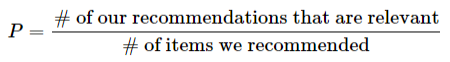
* **AP@K**: To better assess the performance of a recommender basis positions of relevant recommendations, we take average of precisions at every position (1 to K).
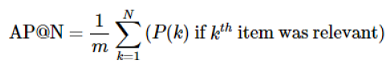

* **MAP@K** is the mean of “average precisions at each position” for all users.
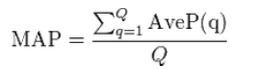


### **2. Mean Average Recall@K:**

* **Recall@K** is the fraction of total relevant items captured in Top-K recommendations.
* **Average Recall@K** is the average of recalls at each position of Top-K recommendations.
* **MAR@K** is the mean of AR@K for all users.

### **3. Catalogue Coverage**:

* Coverage is the percent of items in the training data, that model is able to recommend on a test set.
* Coverage does not evaluate if the user enjoys the recommendation or not, instead, it assess the system in terms of its ability to bring unexpectedness to the user.
* Low coverage may lead to users’ dissatisfaction.

### **Modular functions**

In [ ]:
def _ark(actual: list, predicted: list, k=10) -> int:
    """
    Computes the average recall at k.
    Parameters
    ----------
    actual :     A list of actual items to be predicted (we will get this from test dataset)
    predicted :  An ordered list of predicted items
    k : int, default = 10, Number of predictions to consider
    ------
    Returns:  score : int, The average recall at k.
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (len(actual))

    if not actual:
        return 0.0

    return score / len(actual)

In [ ]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of items.
    Parameters
    ----------
    actual : A list of elements that are to be predicted (order doesn't matter)
    predicted : A list of predicted elements (order does matter)
    k : int, The maximum number of predicted elements
    ----------
    Returns:  score : The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

In [ ]:
def catalog_coverage(predicted, catalog):
    """ Computes the prediction coverage for a list of recommendations
    Parameters
    ----------
    predicted : a list of lists, Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    Returns
    ----------
    prediction_coverage: The prediction coverage of the recommendations as a percent
        rounded to 2 decimal places.
    """
    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_predictions = len(set(predicted_flattened))
    prediction_coverage = round(unique_predictions/(len(catalog)* 1.0)*100,2)
    return prediction_coverage

In [ ]:
class Mar_Map_Coverage_K:

  def __init__(self, test_data=None):
    self.test_data = test_data
    
  # Function to evaluate the performance of model for each user
  def ark_apk_per_user(self, model, user_id, k=10):
        
    # Getting all books for given user from the test set
    books_read_test = self.test_data.loc[user_id]
        
    if type(books_read_test['Title']) == pd.Series:
        books_read_test = list(set(books_read_test['Title']))
    else:
        books_read_test = list(set([int(books_read_test['Title'])]))
            
    # Total number of books read by user in test dataset
    num_books_read_test = len(books_read_test) 

    # Getting a ranked recommendation list of books from the model for a given user
    books_rec_df = model.recommend_items(user_id, books_to_ignore=get_books_read(user_id, svd_train), topn=12000)

    avg_recall_k = _ark(books_read_test, list(books_rec_df['Title']), k)
    avg_precision_k = apk(books_read_test, list(books_rec_df['Title']), k)
    predictions_k = list(books_rec_df[:k]['Title'])

    return avg_recall_k, avg_precision_k, predictions_k

  # Function to evaluate the performance of model at global level
  def mean_ark_apk(self, model, k=10):
    ark_metrics = []
    apk_metrics = []
    predictions = []
        
    for idx, user_id in enumerate(list(self.test_data.index.unique().values)):    
      person_arks,person_apks,predictions_list   = self.ark_apk_per_user(model, user_id, k)  
      predictions.append(predictions_list)
      ark_metrics.append(person_arks)
      apk_metrics.append(person_apks)
            
    print('%d users processed' % idx)
        
    mean_avg_recall_at_k = sum(ark_metrics)/len(ark_metrics)
    mean_avg_precision_at_k = sum(apk_metrics)/len(apk_metrics)
    coverage_catalogue = catalog_coverage(predictions, set(svd_train['Title']))
 
    return mean_avg_recall_at_k, mean_avg_precision_at_k, coverage_catalogue

**Recall@N metric by treating all users equally (Mixing 1 relevant item with 100 random non-interacted items for all users)**

**For each user**
* For each item the user has interacted in test set, Sample 100 other items the user has never interacted. 
Ps. Here we naively assume that those non interacted items are not relevant to the user, which might not be true, as the user may simply not be aware of those not interacted items. But let's keep this assumption.
* Ask the recommender model to produce a ranked list of recommended items, from a set composed of one interacted item and the 100 non-interacted items
* Compute the Top-N recall metrics for this user and interacted item from the recommendations ranked list
* Aggregate the global Top-N recall metrics

**Reason for choosing 100 random non-interacted Books for each user in test data**:
* This evaluation strategy, **where each user's relevant item are mixed individually with other random non-interacted item, makes it possible to treat equally very active users and users with few interactions**. 
* For example, if I choose to form the user's evaluation list using all user interactions and complete the list with non-interacted items to reach 100 items, users with more interacted items will have better measures for ranking metrics (greater chance that relevant items appear in the Top-N items). 
* With the proposed approach, we can ignore the total number of interacted items and actually measure whether the recommendation algorithm is able to rank the list, and surface, among the Top-N items, the one relevant item from a set with 100 other irrelevant items.

In [ ]:
# Top-N accuracy metrics constant
EVAL_RANDOM_SAMPLE_UNREAD_BOOKS = 100

class ModelEvaluator:
  def __init__(self, test_data=None):
    self.test_data = test_data
  
  # Function for getting the set of items which a user has not interacted with from the full dataset
  def get_unread_books_sample(self, user_id, sample_size, seed=42):
    books_read = get_books_read(user_id, svd_data)
    all_items = set(books['Title'])
    unread_books = all_items - books_read
    # setting random seed to ensure reproducibility of results
    random.seed(seed)
    # taking a sample of 100 books at random from the set of unread books of given user
    random_unread_books_sample = random.sample(unread_books, sample_size)
    return set(random_unread_books_sample)

  # Function to verify whether a particular book was present in the set of top-N recommended books
  def _verify_hit_top_n(self, Title, recommended_items, topn):        
    try:
      index = next(i for i, c in enumerate(recommended_items) if c == Title)
    except:
      index = -1
    hit = int(index in range(0, topn))
    return hit, index
    
  # Function to evaluate the performance of model for each user
  def evaluate_model_for_user(self, model, user_id):
        
    # Getting all books for given user from the test set
    books_read_test = self.test_data.loc[user_id]
        
    if type(books_read_test['Title']) == pd.Series:
        books_read_test = set(books_read_test['Title'])
    else:
        books_read_test = set([int(books_read_test['Title'])])
            
    # Total number of books read by user in test dataset
    num_books_read_test = len(books_read_test) 

    # Getting a ranked recommendation list of books from the model for a given user
    books_rec_df = model.recommend_items(user_id, books_to_ignore=get_books_read(user_id, svd_train1), topn=12000)

    hits_at_5_count = 0
    hits_at_10_count = 0
        
    # For each item the user has interacted in the test set
    for title in books_read_test:
      # Getting a random sample of 100 items the user has not interacted with
      if type(title) != str:
        random_unread_books_sample = self.get_unread_books_sample(user_id, sample_size=EVAL_RANDOM_SAMPLE_UNREAD_BOOKS, seed=title%(2**32))
      else:
        random_unread_books_sample = self.get_unread_books_sample(user_id, sample_size=EVAL_RANDOM_SAMPLE_UNREAD_BOOKS, seed=(len(title)*2))

      # Combining the current interacted item with the 100 random items
      items_to_filter_recs = random_unread_books_sample.union(set([title]))

      # Filtering only recommendations that are either the book read in test set or from a random sample of 100 unread books
      valid_recs_df = books_rec_df[books_rec_df['Title'].isin(items_to_filter_recs)]                    
      valid_recs = valid_recs_df['Title'].values
            
      # Verifying if the current read book (test set) is among the Top-N recommended books
      hit_at_5, index_at_5 = self._verify_hit_top_n(title, valid_recs, 5)
      hits_at_5_count += hit_at_5
      hit_at_10, index_at_10 = self._verify_hit_top_n(title, valid_recs, 10)
      hits_at_10_count += hit_at_10

    # Recall is the rate of the read books that are ranked among the Top-N recommended books
    recall_at_5 = hits_at_5_count / float(num_books_read_test)
    recall_at_10 = hits_at_10_count / float(num_books_read_test)

    person_metrics = {'hits@5_count':hits_at_5_count, 
                      'hits@10_count':hits_at_10_count,
                      'interacted_count': num_books_read_test,
                      'recall@5': recall_at_5,
                      'recall@10': recall_at_10}
    return person_metrics

  # Function to evaluate the performance of model at global level
  def evaluate_model(self, model):
    people_metrics = []
        
    for idx, user_id in enumerate(list(self.test_data.index.unique().values)):    
      person_metrics = self.evaluate_model_for_user(model, user_id)  
      person_metrics['_person_id'] = user_id
      people_metrics.append(person_metrics)
            
    print('%d users processed' % idx)

    detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
    global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
    global_metrics = {'modelName': model.get_model_name(),
                      'recall@5': global_recall_at_5,
                      'recall@10': global_recall_at_10}    
    return global_metrics, detailed_results_df

### **A. Collaborative Filtering Recommender System Using SVD**

In [ ]:
# Instantiating class for calculation of MAR@K, MAP@K and coverage
Mar_Map_K = Mar_Map_Coverage_K(svd_test_indexed)

In [ ]:
# Checking results for K=1 (K: Number of recommendations)
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
mar_1_cf, map_1_cf, cov_1_cf = Mar_Map_K.mean_ark_apk(cf_recommender_model, 1)

print('\nMean Average Recall at k=1:\n%s' % mar_1_cf)
print('\nMean Average Precision at k=1:\n%s' % map_1_cf)
print('\nCatalogue Coverage in percentage at k=1:\n%s' % cov_1_cf)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
2623 users processed

Mean Average Recall at k=1:
0.00151122755920578

Mean Average Precision at k=1:
0.052972560975609755

Catalogue Coverage in percentage at k=1:
0.5


In [ ]:
# Checking results for K=5 (K: Number of recommendations)
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
mar_5_cf, map_5_cf, cov_5_cf = Mar_Map_K.mean_ark_apk(cf_recommender_model, 5)

print('\nMean Average Recall at k=5:\n%s' % mar_5_cf)
print('\nMean Average Precision at k=5:\n%s' % map_5_cf)
print('\nCatalogue Coverage in percentage at k=5:\n%s' % cov_5_cf)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
2623 users processed

Mean Average Recall at k=5:
0.005057814705080347

Mean Average Precision at k=5:
0.02280403116531168

Catalogue Coverage in percentage at k=5:
1.33


In [ ]:
# Checking results for K=10 (K: Number of recommendations)
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
mar_10_cf, map_10_cf, cov_10_cf = Mar_Map_K.mean_ark_apk(cf_recommender_model, 10)

print('\nMean Average Recall at k=10:\n%s' % mar_10_cf)
print('\nMean Average Precision at k=10:\n%s' % map_10_cf)
print('\nCatalogue Coverage in percentage at k=10:\n%s' % cov_10_cf)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
2623 users processed

Mean Average Recall at k=10:
0.009028895467685226

Mean Average Precision at k=10:
0.019568514012848856

Catalogue Coverage in percentage at k=10:
2.32


In [ ]:
# Checking results for K=50 (K: Number of recommendations)
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
mar_50_cf, map_50_cf, cov_50_cf = Mar_Map_K.mean_ark_apk(cf_recommender_model, 50)

print('\nMean Average Recall at k=50:\n%s' % mar_50_cf)
print('\nMean Average Precision at k=50:\n%s' % map_50_cf)
print('\nCatalogue Coverage in percentage at k=50:\n%s' % cov_50_cf)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
2623 users processed

Mean Average Recall at k=50:
0.025820450559750092

Mean Average Precision at k=50:
0.021202822271613447

Catalogue Coverage in percentage at k=50:
8.29


In [ ]:
# Checking results for K=100 (K: Number of recommendations)
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
mar_100_cf, map_100_cf, cov_100_cf = Mar_Map_K.mean_ark_apk(cf_recommender_model, 100)

print('\nMean Average Recall at k=100:\n%s' % mar_100_cf)
print('\nMean Average Precision at k=100:\n%s' % map_100_cf)
print('\nCatalogue Coverage in percentage at k=100:\n%s' % cov_100_cf)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
2623 users processed

Mean Average Recall at k=100:
0.03929853804706974

Mean Average Precision at k=100:
0.022319134994026595

Catalogue Coverage in percentage at k=100:
14.12


In [ ]:
# Checking results for K=200 (K: Number of recommendations)
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
mar_200_cf, map_200_cf, cov_200_cf = Mar_Map_K.mean_ark_apk(cf_recommender_model, 200)

print('\nMean Average Recall at k=200:\n%s' % mar_200_cf)
print('\nMean Average Precision at k=200:\n%s' % map_200_cf)
print('\nCatalogue Coverage in percentage at k=200:\n%s' % cov_200_cf)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
2623 users processed

Mean Average Recall at k=200:
0.05972165527811367

Mean Average Precision at k=200:
0.023236304260065888

Catalogue Coverage in percentage at k=200:
22.82


In [ ]:
# Instantiating model evaluator class 
# basis hitting a book read in test data in Top-5 and Top-10 recommendations out of total 101 recommendations 
# (100 random unread books + 1 book actually read in test dataset)
model_evaluator = ModelEvaluator(svd_test_indexed)

In [ ]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
2623 users processed

Global metrics:
{'modelName': 'Collaborative Filtering using SVD', 'recall@5': 0.8470020047384728, 'recall@10': 0.8470020047384728}


hits@5_count  hits@10_count  interacted_count  recall@5  recall@10  \
15            431            431               698  0.617479   0.617479   
34            202            202               290  0.696552   0.696552   
115           100            100               135  0.740741   0.740741   
348            81             81               105  0.771429   0.771429   
304            85             85                93  0.913978   0.913978   
291            62             62                90  0.688889   0.688889   
184            53             53                70  0.757143   0.757143   
52             62             62                69  0.898551   0.898551   
373            58             58                69  0.840580   0.840580   
93             53             53                68  0.779412   0.779412   

     _person_id  
15        11676  
34        98391  
115      153662  
348       16795  
304      114368  
291       95359  
184      235105  
52       158295  
373      104636  
93        35859

### **B. Content-Based Recommender System**

In [ ]:
svd_test2 = svd_test1.set_index('User_ID')
svd_test2.loc[16916]

Title  \
User_ID                                                                      
16916                                                  the burden of proof   
16916                                                           naked prey   
16916    left behind: a novel of the earth's last days (left behind no. 1)   
16916                                                             the maze   
16916                                                          the wedding   

         Book_rating  
User_ID               
16916           10.0  
16916           10.0  
16916           10.0  
16916           10.0  
16916           10.0

In [ ]:
# Instantiating class for calculation of MAR@K, MAP@K and coverage
Mar_Map_K_CB = Mar_Map_Coverage_K(svd_test2)

In [ ]:
# Checking results for K=1 (K: Number of recommendations)
print('Evaluating content based recommender model...')
mar_1_cb, map_1_cb, cov_1_cb = Mar_Map_K_CB.mean_ark_apk(content_based_recommender_model, 1)

print('\nMean Average Recall at k=1:\n%s' % mar_1_cb)
print('\nMean Average Precision at k=1:\n%s' % map_1_cb)
print('\nCatalogue Coverage in percentage at k=1:\n%s' % cov_1_cb)

Evaluating content based recommender model...
2623 users processed

Mean Average Recall at k=1:
0.0005232680726144631

Mean Average Precision at k=1:
0.012957317073170731

Catalogue Coverage in percentage at k=1:
9.65


In [ ]:
# Checking results for K=5 (K: Number of recommendations)
print('Evaluating content based recommender model...')
mar_5_cb, map_5_cb, cov_5_cb = Mar_Map_K_CB.mean_ark_apk(content_based_recommender_model, 5)

print('\nMean Average Recall at k=5:\n%s' % mar_5_cb)
print('\nMean Average Precision at k=5:\n%s' % map_5_cb)
print('\nCatalogue Coverage in percentage at k=5:\n%s' % cov_5_cb)

Evaluating content based recommender model...
2623 users processed

Mean Average Recall at k=5:
0.0022073338106576076

Mean Average Precision at k=5:
0.006808731368563678

Catalogue Coverage in percentage at k=5:
29.43


In [ ]:
# Checking results for K=10 (K: Number of recommendations)
print('Evaluating content based recommender model...')
mar_10_cb, map_10_cb, cov_10_cb = Mar_Map_K_CB.mean_ark_apk(content_based_recommender_model, 10)

print('\nMean Average Recall at k=10:\n%s' % mar_10_cb)
print('\nMean Average Precision at k=10:\n%s' % map_10_cb)
print('\nCatalogue Coverage in percentage at k=10:\n%s' % cov_10_cb)

Evaluating content based recommender model...
2623 users processed

Mean Average Recall at k=10:
0.004244187850708773

Mean Average Precision at k=10:
0.006699701063098005

Catalogue Coverage in percentage at k=10:
42.56


In [ ]:
# Checking results for K=50 (K: Number of recommendations)
print('Evaluating content based recommender model...')
mar_50_cb, map_50_cb, cov_50_cb = Mar_Map_K_CB.mean_ark_apk(content_based_recommender_model, 50)

print('\nMean Average Recall at k=50:\n%s' % mar_50_cb)
print('\nMean Average Precision at k=50:\n%s' % map_50_cb)
print('\nCatalogue Coverage in percentage at k=50:\n%s' % cov_50_cb)

Evaluating content based recommender model...
2623 users processed

Mean Average Recall at k=50:
0.015489103786595364

Mean Average Precision at k=50:
0.008549177880412111

Catalogue Coverage in percentage at k=50:
72.55


In [ ]:
# Checking results for K=100 (K: Number of recommendations)
print('Evaluating content based recommender model...')
mar_100_cb, map_100_cb, cov_100_cb = Mar_Map_K_CB.mean_ark_apk(content_based_recommender_model, 100)

print('\nMean Average Recall at k=100:\n%s' % mar_100_cb)
print('\nMean Average Precision at k=100:\n%s' % map_100_cb)
print('\nCatalogue Coverage in percentage at k=100:\n%s' % cov_100_cb)

Evaluating content based recommender model...
2623 users processed

Mean Average Recall at k=100:
0.02684995350782083

Mean Average Precision at k=100:
0.009463421321624609

Catalogue Coverage in percentage at k=100:
82.26


In [ ]:
# Checking results for K=200 (K: Number of recommendations)
print('Evaluating content based recommender model...')
mar_200_cb, map_200_cb, cov_200_cb = Mar_Map_K_CB.mean_ark_apk(content_based_recommender_model, 200)

print('\nMean Average Recall at k=200:\n%s' % mar_200_cb)
print('\nMean Average Precision at k=200:\n%s' % map_200_cb)
print('\nCatalogue Coverage in percentage at k=200:\n%s' % cov_200_cb)

Evaluating content based recommender model...
2623 users processed

Mean Average Recall at k=200:
0.03872726940517765

Mean Average Precision at k=200:
0.010006810594350766

Catalogue Coverage in percentage at k=200:
85.52


In [ ]:
# Instantiating model evaluator class 
# basis hitting a book read in test data in Top-5 and Top-10 recommendations out of total 101 recommendations 
# (100 random unread books + 1 book actually read in test dataset)
model_evaluator_CB = ModelEvaluator(svd_test2)

In [ ]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator_CB.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
2623 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.6645708037178786, 'recall@10': 0.7086750501184618}


hits@5_count  hits@10_count  interacted_count  recall@5  recall@10  \
15            337            354               698  0.482808   0.507163   
34            176            186               290  0.606897   0.641379   
115            86             92               135  0.637037   0.681481   
348            70             77               105  0.666667   0.733333   
304            75             77                93  0.806452   0.827957   
291            50             56                90  0.555556   0.622222   
184            44             46                70  0.628571   0.657143   
52             53             54                69  0.768116   0.782609   
373            57             60                69  0.826087   0.869565   
93             43             50                68  0.632353   0.735294   

     _person_id  
15        11676  
34        98391  
115      153662  
348       16795  
304      114368  
291       95359  
184      235105  
52       158295  
373      104636  
93        35859

### **C. Hybrid Recommender System**

In [ ]:
# Instantiating class for calculation of MAR@K, MAP@K and coverage
Mar_Map_K_CB = Mar_Map_Coverage_K(svd_test2)

In [ ]:
# Checking results for K=1 (K: Number of recommendations)
print('Evaluating Hybrid recommender model...')
mar_1_hy, map_1_hy, cov_1_hy = Mar_Map_K_CB.mean_ark_apk(hybrid_recommender_model, 1)

print('\nMean Average Recall at k=1:\n%s' % mar_1_hy)
print('\nMean Average Precision at k=1:\n%s' % map_1_hy)
print('\nCatalogue Coverage in percentage at k=1:\n%s' % cov_1_hy)

Evaluating Hybrid recommender model...
2623 users processed

Mean Average Recall at k=1:
0.009255690401202202

Mean Average Precision at k=1:
0.06364329268292683

Catalogue Coverage in percentage at k=1:
4.36


In [ ]:
# Checking results for K=5 (K: Number of recommendations)
print('Evaluating Hybrid recommender model...')
mar_5_hy, map_5_hy, cov_5_hy = Mar_Map_K_CB.mean_ark_apk(hybrid_recommender_model, 5)

print('\nMean Average Recall at k=5:\n%s' % mar_5_hy)
print('\nMean Average Precision at k=5:\n%s' % map_5_hy)
print('\nCatalogue Coverage in percentage at k=5:\n%s' % cov_5_hy)

Evaluating Hybrid recommender model...
2623 users processed

Mean Average Recall at k=5:
0.018234676438657546

Mean Average Precision at k=5:
0.028814892445799465

Catalogue Coverage in percentage at k=5:
11.94


In [ ]:
# Checking results for K=10 (K: Number of recommendations)
print('Evaluating Hybrid recommender model...')
mar_10_hy, map_10_hy, cov_10_hy = Mar_Map_K_CB.mean_ark_apk(hybrid_recommender_model, 10)

print('\nMean Average Recall at k=10:\n%s' % mar_10_hy)
print('\nMean Average Precision at k=10:\n%s' % map_10_hy)
print('\nCatalogue Coverage in percentage at k=10:\n%s' % cov_10_hy)

Evaluating Hybrid recommender model...
2623 users processed

Mean Average Recall at k=10:
0.02116505931666077

Mean Average Precision at k=10:
0.02432273447149867

Catalogue Coverage in percentage at k=10:
16.62


In [ ]:
# Checking results for K=50 (K: Number of recommendations)
print('Evaluating Hybrid recommender model...')
mar_50_hy, map_50_hy, cov_50_hy = Mar_Map_K_CB.mean_ark_apk(hybrid_recommender_model, 50)

print('\nMean Average Recall at k=50:\n%s' % mar_50_hy)
print('\nMean Average Precision at k=50:\n%s' % map_50_hy)
print('\nCatalogue Coverage in percentage at k=50:\n%s' % cov_50_hy)

Evaluating Hybrid recommender model...
2623 users processed

Mean Average Recall at k=50:
0.025119726399847168

Mean Average Precision at k=50:
0.025247184868957415

Catalogue Coverage in percentage at k=50:
27.57


In [ ]:
# Checking results for K=100 (K: Number of recommendations)
print('Evaluating Hybrid recommender model...')
mar_100_hy, map_100_hy, cov_100_hy = Mar_Map_K_CB.mean_ark_apk(hybrid_recommender_model, 100)

print('\nMean Average Recall at k=100:\n%s' % mar_100_hy)
print('\nMean Average Precision at k=100:\n%s' % map_100_hy)
print('\nCatalogue Coverage in percentage at k=100:\n%s' % cov_100_hy)

Evaluating Hybrid recommender model...
2623 users processed

Mean Average Recall at k=100:
0.026395875546831263

Mean Average Precision at k=100:
0.026413732554263908

Catalogue Coverage in percentage at k=100:
31.69


In [ ]:
# Checking results for K=200 (K: Number of recommendations)
print('Evaluating Hybrid recommender model...')
mar_200_hy, map_200_hy, cov_200_hy = Mar_Map_K_CB.mean_ark_apk(hybrid_recommender_model, 200)

print('\nMean Average Recall at k=200:\n%s' % mar_200_hy)
print('\nMean Average Precision at k=200:\n%s' % map_200_hy)
print('\nCatalogue Coverage in percentage at k=200:\n%s' % cov_200_hy)

Evaluating Hybrid recommender model...
2623 users processed

Mean Average Recall at k=200:
0.027640936675545014

Mean Average Precision at k=200:
0.027647059167752133

Catalogue Coverage in percentage at k=200:
35.27


In [ ]:
# Instantiating model evaluator class 
# basis hitting a book read in test data in Top-5 and Top-10 recommendations out of total 101 recommendations 
# (100 random unread books + 1 book actually read in test dataset)
model_evaluator_HyB = ModelEvaluator(svd_test2)

In [ ]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator_HyB.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
2623 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.4912064880626936, 'recall@10': 0.4912064880626936}


hits@5_count  hits@10_count  interacted_count  recall@5  recall@10  \
15             47             47               698  0.067335   0.067335   
34             33             33               290  0.113793   0.113793   
115            57             57               135  0.422222   0.422222   
348            32             32               105  0.304762   0.304762   
304            73             73                93  0.784946   0.784946   
291            22             22                90  0.244444   0.244444   
184            25             25                70  0.357143   0.357143   
52             29             29                69  0.420290   0.420290   
373            42             42                69  0.608696   0.608696   
93             24             24                68  0.352941   0.352941   

     _person_id  
15        11676  
34        98391  
115      153662  
348       16795  
304      114368  
291       95359  
184      235105  
52       158295  
373      104636  
93        35859

### **D. Comparing all 3 Models basis evaluation metrics**

In [ ]:
# an empty dataframe to append results of all 3 recommenders
comparison = pd.DataFrame(columns=['Model_name', 'Num_Recommendation_K', 'MAR_K(%)', 'MAP_K(%)', 'Cat_Coverage_K(%)'])
comparison.head()

Empty DataFrame
Columns: [Model_name, Num_Recommendation_K, MAR_K(%), MAP_K(%), Cat_Coverage_K(%)]
Index: []

In [ ]:
# Appending results for Collaborative filtering for all K
comparison.loc[0,:] = ['Collaborative', 1, mar_1_cf*100, map_1_cf*100, cov_1_cf]
comparison.loc[1,:] = ['Collaborative', 5, mar_5_cf*100, map_5_cf*100, cov_5_cf]
comparison.loc[2,:] = ['Collaborative', 10, mar_10_cf*100, map_10_cf*100, cov_10_cf]
comparison.loc[3,:] = ['Collaborative', 50, mar_50_cf*100, map_50_cf*100, cov_50_cf]
comparison.loc[4,:] = ['Collaborative', 100, mar_100_cf*100, map_100_cf*100, cov_100_cf]
comparison.loc[5,:] = ['Collaborative', 200, mar_200_cf*100, map_200_cf*100, cov_200_cf]

In [ ]:
# Appending results for Content-based filtering for all K
comparison.loc[6,:] = ['Content_Based', 1, mar_1_cb*100, map_1_cb*100, cov_1_cb]
comparison.loc[7,:] = ['Content_Based', 5, mar_5_cb*100, map_5_cb*100, cov_5_cb]
comparison.loc[8,:] = ['Content_Based', 10, mar_10_cb*100, map_10_cb*100, cov_10_cb]
comparison.loc[9,:] = ['Content_Based', 50, mar_50_cb*100, map_50_cb*100, cov_50_cb]
comparison.loc[10,:] = ['Content_Based', 100, mar_100_cb*100, map_100_cb*100, cov_100_cb]
comparison.loc[11,:] = ['Content_Based', 200, mar_200_cb*100, map_200_cb*100, cov_200_cb]

In [ ]:
# Appending results for Hybrid filtering for all K
comparison.loc[12,:] = ['Hybrid',1, mar_1_hy*100, map_1_hy*100, cov_1_hy]
comparison.loc[13,:] = ['Hybrid',5, mar_5_hy*100, map_5_hy*100, cov_5_hy]
comparison.loc[14,:] = ['Hybrid',10, mar_10_hy*100, map_10_hy*100, cov_10_hy]
comparison.loc[15,:] = ['Hybrid',50, mar_50_hy*100, map_50_hy*100, cov_50_hy]
comparison.loc[16,:] = ['Hybrid',100, mar_100_hy*100, map_100_hy*100, cov_100_hy]
comparison.loc[17,:] = ['Hybrid',200, mar_200_hy*100, map_200_hy*100, cov_200_hy]

In [ ]:
# Entire dataframe
comparison.head(18)

Model_name Num_Recommendation_K  MAR_K(%)  MAP_K(%) Cat_Coverage_K(%)
0   Collaborative                    1  0.151123  5.297256               0.5
1   Collaborative                    5  0.505781  2.280403              1.33
2   Collaborative                   10   0.90289  1.956851              2.32
3   Collaborative                   50  2.582045  2.120282              8.29
4   Collaborative                  100  3.929854  2.231913             14.12
5   Collaborative                  200  5.972166   2.32363             22.82
6   Content_Based                    1  0.052327  1.295732              9.65
7   Content_Based                    5  0.220733  0.680873             29.43
8   Content_Based                   10  0.424419   0.66997             42.56
9   Content_Based                   50   1.54891  0.854918             72.55
10  Content_Based                  100  2.684995  0.946342             82.26
11  Content_Based                  200  3.872727  1.000681             85.52
12         Hybrid                    1  0.925569  6.364329              4.36
13         Hybrid                    5  1.823468  2.881489             11.94
14         Hybrid                   10  2.116506  2.432273             16.62
15         Hybrid                   50  2.511973  2.524718             27.57
16         Hybrid                  100  2.639588  2.641373             31.69
17         Hybrid                  200  2.764094  2.764706             35.27

In [ ]:
# Storing the file
comparison = comparison.to_csv('/content/drive/MyDrive/Book Recommendation - Kumari Rashmi/Problem Info & Data/comparison.csv')

In [ ]:
# Loading the file
comparison = pd.read_csv('/content/drive/MyDrive/Book Recommendation - Kumari Rashmi/Problem Info & Data/comparison.csv')

In [ ]:
# looking into comparison dataframe
comparison.head(2)

Unnamed: 0     Model_name  Num_Recommendation_K  MAR_K(%)  MAP_K(%)  \
0           0  Collaborative                     1  0.151123  5.297256   
1           1  Collaborative                     5  0.505781  2.280403   

   Cat_Coverage_K(%)  
0               0.50  
1               1.33

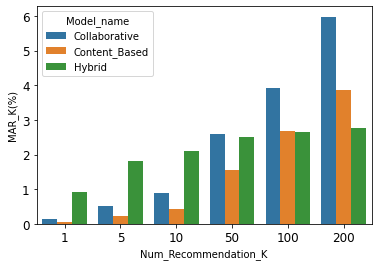

In [ ]:
# Plotting MAR@K for all 3 models at different K values
sns.barplot(x='Num_Recommendation_K', hue='Model_name', y='MAR_K(%)', data=comparison)

**Observation**: As k increases, MAR@K increases for all models.

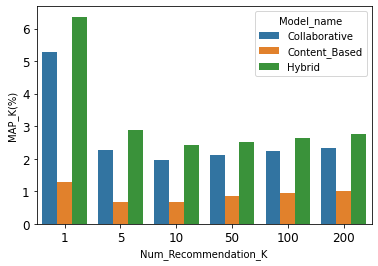

In [ ]:
# Plotting MAP@K for all 3 models at different K values
sns.barplot(x='Num_Recommendation_K', hue='Model_name', y='MAP_K(%)', data=comparison)

**Observation**: 
1. As k increases, MAP@K first decreases drastically and however, later slightly increases for all models.
2. Hybrid models are performing better than individual collaborative and content-based models.

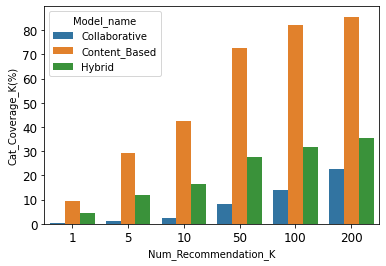

In [ ]:
# Plotting Catalogue coverage@K for all 3 models at different K values
sns.barplot(x='Num_Recommendation_K', hue='Model_name', y='Cat_Coverage_K(%)', data=comparison)

**Observation**: As k increases, Catalogue Coverage increases for all models. Catalogue coverage is highest for Content-based model.

Let's pick required number of recommendations to be 10, as choosing too few recommendations (such as 1 or 5) will not give satisfactory performance. However, recommending too many books (such as 50 or more) will also cause chaos and will repel readers.

Basis Top-10 recommendations, let's compare all 03 models basis Mean Average Recall and Mean Average Precision.

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

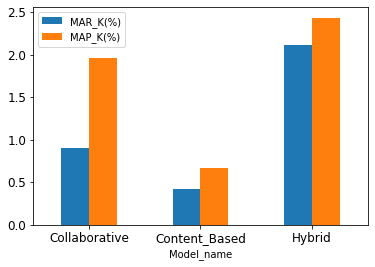

In [ ]:
# Comapring all 3 models at K=10 basis MAR@10 and MAP@10
comparison[comparison['Num_Recommendation_K']==10][['Model_name', 'MAR_K(%)','MAP_K(%)']].plot(kind='bar', x= 'Model_name')
plt.xticks(rotation=0)

**Observation**:

* Basis MAR@10 and MAP@10, Hybrid recommender model is giving the best performance out of three models.

## Step 6. After Selecting a Book: Second page recommendations

## **A. Books with Similar Titles: Using Cosine Similarity**

In [ ]:
# Importing TFIDF vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
# downloading stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#  stopwords of english
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
both_data.head(1)

ISBN         Title                Author  Published_year  \
0  0002005018  clara callan  richard bruce wright            2001   

               Publisher  \
0  harperflamingo canada   

                                                     Title_by_of  User_ID  \
0  clara callan_by_richard bruce wright_of_harperflamingo canada    11400   

   Book_rating                 Location  Age country age_group  Rating_count  \
0            0  ottawa, ontario, canada   49  canada     adult            14   

   Rating_mean  
0         4.93

In [ ]:
# Getting a dataset copy for all ratings (implicit included)
popular_book = both_data.copy()
# creating new feature combining title and author
popular_book['Title_author'] = both_data['Title'].astype(str)+'_by_'+both_data['Author'].astype(str)
popular_book.head(1)

ISBN         Title                Author  Published_year  \
0  0002005018  clara callan  richard bruce wright            2001   

               Publisher  \
0  harperflamingo canada   

                                                     Title_by_of  User_ID  \
0  clara callan_by_richard bruce wright_of_harperflamingo canada    11400   

   Book_rating                 Location  Age country age_group  Rating_count  \
0            0  ottawa, ontario, canada   49  canada     adult            14   

   Rating_mean                          Title_author  
0         4.93  clara callan_by_richard bruce wright

In [ ]:
popular_book.shape, popular_book['Title_author'].nunique()

((329199, 15), 20817)

In [ ]:
# threshold for count of ratings
popularity_threshold =50
popular_book = popular_book[popular_book['Rating_count'] >= popularity_threshold]
# Filtering observations above minimum ratings
popular_book = popular_book.reset_index(drop = True)
popular_book.shape

(132320, 15)

In [ ]:
popular_book.head(1)

ISBN  \
0  1558746226   

                                                                           Title  \
0  a second chicken soup for the woman's soul (chicken soup for the soul series)   

          Author  Published_year              Publisher  \
0  jack canfield            1998  health communications   

                                                                                           Title_by_of  \
0  a second chicken soup for the woman's soul (chicken soup for the soul series)_by_jack canfield_o...   

   User_ID  Book_rating       Location  Age country age_group  Rating_count  \
0    11676            9  n/a, n/a, n/a   32   Other     youth            56   

   Rating_mean  \
0         3.89   

                                                                                     Title_author  
0  a second chicken soup for the woman's soul (chicken soup for the soul series)_by_jack canfield

In [ ]:
# getting unique values
popular_book['Title_author'].nunique(), popular_book['Title'].nunique()

(2028, 2011)

In [ ]:
# Getting unique books 
popular_book = popular_book.groupby(['ISBN','Title','Title_author']).size().to_frame().reset_index()
popular_book.shape

(2605, 4)

In [ ]:
popular_book.tail()

ISBN              Title                    Title_author  0
2600  B00008WFXL  the da vinci code  the da vinci code_by_dan brown  1
2601  B00009ANY9         cane river     cane river_by_lalita tademy  1
2602  B0000E63CJ       dreamcatcher    dreamcatcher_by_stephen king  1
2603  B0000T6KIM          faking it    faking it_by_jennifer crusie  1
2604  B0001GMSV2            find me       find me_by_rosie odonnell  2

In [ ]:
# Vectorizing book using Title
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Title'])
tfidf_matrix.shape

(2605, 5673)

In [ ]:
type(tfidf_matrix)

scipy.sparse.csr.csr_matrix

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
normalized_df = tfidf_matrix.astype(np.float32)
# calculating cosine similarities for all books
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
cosine_similarities.shape

(2605, 2605)

In [ ]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

# Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

Enter a book name: brave new world
Enter number of books to recommend: 5


In [ ]:
popular_book.head(1)

ISBN          Title                    Title_author   0
0  000649840X  angelas ashes  angelas ashes_by_frank mccourt  29

In [ ]:
cosine_similarities[11].argsort()[::-1]

array([  11, 1692, 1956, ..., 1732, 1731,    0])

In [ ]:
def context_books(bookName, number):
  print("Recommended Books:\n")
  # getting ISBN number of selected book
  isbn = books.loc[books['Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
  content = []
  # Getting index at which given book (ISBN) is present in popular books dataframe 
  # (as we are trying to get recommendations of only popular books)
  idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
  # getting indexes of most similar books (reverse order for descending) basis cosine similarity as calculated above
  similar_indices = cosine_similarities[idx].argsort()[::-1]
  similar_items = []
  for i in similar_indices:
    # Getting n number of unique similar books for the selected book
    if popular_book['Title'][i] != bookName and popular_book['Title'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['Title'][i])
        content.append(popular_book['Title_author'][i])
  return similar_items

In [ ]:
# Generating recommendation for a new book
context_books('brave new world', 5)

Recommended Books:



['the lost world',
 'a map of the world',
 'the lost world: a novel',
 'pandora: new tales of the vampires (new tales of the vampires)',
 'world of pies : a novel']

In [ ]:
# Generating recommendation for a new book
context_books("the return of the king (the lord of the rings, part 3)", 5)

Recommended Books:



['the two towers (the lord of the rings, part 2)',
 'the fellowship of the ring (the lord of the rings, part 1)',
 'the lord of the rings (movie art cover)',
 'the hobbit : the enchanting prelude to the lord of the rings',
 'the return journey']

In [ ]:
# Generating recommendation for a new book
context_books("cane river", 5)

Recommended Books:



["cane river (oprah's book club (paperback))",
 'the river king',
 "river's end",
 'mystic river',
 'stones from the river']

## **B. Books with similar ratings by Readers: Using Correlation Coefficients**

In [ ]:
knn_users.head()

Title_by_of  User_ID  \
User_ID                
243              243   
254              254   
507              507   
638              638   
805              805   

Title_by_of   earth prayers from around the world: 365 prayers, poems, and invocations for honoring the earth_by_elizabeth roberts_of_harpersanfrancisco  \
User_ID                                                                                                                                                    
243                                                                                                          0.0                                           
254                                                                                                          0.0                                           
507                                                                                                          0.0                                           
638                                                                                                          0.0                                           
805                                                                                                          0.0                                           

Title_by_of   good wives: image and reality in the lives of women in northern new england, 1650-1750_by_laurel thatcher ulrich_of_vintage books usa  \
User_ID                                                                                                                                               
243                                                                                                          0.0                                      
254                                                                                                          0.0                                      
507                                                                                                          0.0                                      
638                                                                                                          0.0                                      
805                                                                                                          0.0                                      

Title_by_of   goosebumps monster edition 1: welcome to dead house, stay out of the basement, and say cheese and die!_by_r l stine_of_scholastic paperbacks t  \
User_ID                                                                                                                                                        
243                                                                                                          0.0                                               
254                                                                                                          0.0                                               
507                                                                                                          0.0                                               
638                                                                                                          0.0                                               
805                                                                                                          0.0                                               

Title_by_of   murder of a sleeping beauty (scumble river mysteries (paperback))_by_denise swanson_of_signet book  \
User_ID                                                                                                            
243                                                                                                          0.0   
254                                                                                                          0.0   
507                                                                                            

In [ ]:
def sim_books_corr(Title, topn = 5):
  book_ratings = knn_users[Title]
  # getting similar books with similar ratings using correlation coefficients
  similar_books = knn_users.corrwith(book_ratings)
  corr_books = pd.DataFrame(similar_books, columns=['Correlation'])
  corr_books.dropna(inplace=True)
  # sorting similar books basis correlation coefficients
  corr_books = corr_books.sort_values('Correlation', ascending=False)
  return corr_books[1:topn+1]

In [ ]:
# Generating recommendation for a new book
sim_books_corr(' earth prayers from around the world: 365 prayers, poems, and invocations for honoring the earth_by_elizabeth roberts_of_harpersanfrancisco')

Correlation
Title_by_of                                                                                                
teach us, amelia bedelia (hello reader)_by_peggy parish_of_scholastic paperbacks                   0.677144
slow burn_by_heather graham_of_mira                                                                0.609362
what to expect when you're expecting_by_sandee eisenberg hathaway_of_workman publishing co inc     0.528439
the sound of waves_by_yukio mishima_of_vintage books usa                                           0.509256
don't sweat the small stuff in love_by_richard carlson_of_hyperion press                           0.445481

In [ ]:
# Generating recommendation for a new book
sim_books_corr('1812 (the american story)_by_david nevin_of_forge books')

Correlation
Title_by_of                                                            
west of dodge_by_louis lamour_of_bantam                        0.749175
deep water_by_s v date_of_berkley publishing group             0.749175
the day after tomorrow_by_whitley strieber_of_pocket books     0.749175
the hancock boys_by_thomas william simpson_of_bantam books     0.749175
road to perdition_by_max allan collins_of_onyx books           0.749175

In [ ]:
# Generating recommendation for a new book
sim_books_corr("harry potter and the chamber of secrets (book 2)_by_j k rowling_of_scholastic", 5)

Correlation
Title_by_of                                                                                                      
harry potter and the prisoner of azkaban (book 3)_by_j k rowling_of_scholastic                           0.623534
harry potter and the goblet of fire (book 4)_by_j k rowling_of_scholastic                                0.508680
harry potter and the sorcerer's stone (book 1)_by_j k rowling_of_scholastic                              0.465734
harry potter and the order of the phoenix (book 5)_by_j k rowling_of_scholastic                          0.376051
harry potter and the sorcerer's stone (harry potter (paperback))_by_j k rowling_of_arthur a levin...     0.368440

## **C. Top-N rated Books by Same Author**

In [ ]:
# creating a copy of explicit dataset
author_data = exp_data.copy()
# creating a feature combining title and author
author_data['Title_Author'] = author_data['Title'].astype(str)+'_by_'+ author_data['Author'].astype(str)
author_data.tail()

index        ISBN                   Title         Author  \
110357  969934  0586062009       robots and empire   isaac asimov   
110358  969939  0586062009       robots and empire   isaac asimov   
110359  976751  2266120158  le silence des agneaux  thomas harris   
110360  976752  2266047442  le silence des agneaux  thomas harris   
110361  991410  3492121527   in search of (german)       hauptman   

        Published_year          Publisher  \
110357            1986      harpercollins   
110358            1986      harpercollins   
110359            2002             pocket   
110360            1992             pocket   
110361            1998  piper verlag gmbh   

                                                   Title_by_of  User_ID  \
110357      robots and empire_by_isaac asimov_of_harpercollins   145109   
110358      robots and empire_by_isaac asimov_of_harpercollins    37168   
110359       le silence des agneaux_by_thomas harris_of_pocket     1211   
110360       le silence des agneaux_by_thomas harris_of_pocket   259155   
110361  in search of (german)_by_hauptman_of_piper verlag gmbh   141203   

        Book_rating                      Location  Age  country age_group  \
110357           10   barcelona, barcelona, spain   45    spain     adult   
110358           10  bakersfield, california, usa   46      usa     adult   
110359            9      rennes, bretagne, france   22   france     youth   
110360            8  paris, ile de france, france   25   france     youth   
110361           10     hamburg, hamburg, germany   38  germany     adult   

        Rating_count  Rating_mean     score  \
110357             8         5.50  4.170000   
110358             8         5.50  4.170000   
110359             9         5.56  4.280000   
110360             9         5.56  4.280000   
110361            10         3.50  3.206667   

                                   Title_Author  
110357        robots and empire_by_isaac asimov  
110358        robots and empire_by_isaac asimov  
110359  le silence des agneaux_by_thomas harris  
110360  le silence des agneaux_by_thomas harris  
110361        in search of (german)_by_hauptman

In [ ]:
def get_books(title_author, n):
    print("\nBooks by same Author:\n")
    # getting author name of selected book
    au = author_data[author_data['Title_Author'] == title_author]['Author'].unique()
    # getting all books of title other than selected book
    data = author_data[author_data['Title_Author'] != title_author]
    # print(au)

    if au[0] in list(data['Author'].unique()):
      # getting all remaining books by same author
      k2 = data[data['Author'] == au[0]]
    # Sorting other books by same author using weighted-average ratings
    k2 = k2.sort_values(by=['score'])
    # dropping duplicate titles
    k2.drop_duplicates(subset='Title', keep='first', inplace=True)
    print(k2[['Title']].head(n))

In [ ]:
# Generating recommendation for a new book
get_books('harry potter and the chamber of secrets (book 2)_by_j k rowling', 5)


Books by same Author:

                                                                                                   Title
44311   harry potter schoolbooks: quidditch through the ages and fantastic beasts and where to find them
107331                                                harry potter and the order of the phoenix (book 5)
54817                                                            harry potter et le prisonnier d'azkaban
52751                                                                harry potter a l'ecole des sorciers
102218                                                           fantastic beasts and where to find them


In [ ]:
# Generating recommendation for a new book
get_books('robots and empire_by_isaac asimov', 5)


Books by same Author:

                                                       Title
97262                                      edge of tommorrow
60424                    winds of change...and other stories
59939      foundation's edge (foundation novels (paperback))
31594  prelude to foundation (foundation novels (paperback))
91933                  foundation (foundation series ; bk 1)


In [ ]:
# Generating recommendation for a new book
get_books("towards zero_by_agatha christie", 5)


Books by same Author:

                                                           Title
90133                                            halloween party
80177  peril at end house (hercule poirot mysteries (paperback))
60400                                          death on the nile
43731                                      the sittaford mystery
79070                               murder on the orient express


In [ ]:
# Generating recommendation for a new book
get_books("the girl who loved tom gordon_by_stephen king", 5)


Books by same Author:

                                             Title
98819   apt pupil : a novella in different seasons
107680   wizard and glass (the dark tower, book 4)
68299                            dolores claiborne
52876                                       it (r)
56511                               needful things
